In [1]:
import astropy
from astropy.io import fits 
from astropy.time import Time
from astropy.visualization import time_support
from astropy.timeseries import LombScargle
from astropy.convolution import Box1DKernel
from astropy.convolution import convolve
import matplotlib.pyplot as plt
import astropy.units as u
from astroquery.gaia import Gaia
from astroquery.simbad import Simbad
import astropy.coordinates as coord
import numpy as np
import numpy.ma as ma
import os
import pandas as pd
import scipy.signal as sig
from astropy.stats import sigma_clip
import warnings
import time 

In [2]:
from functools import partial

import matplotlib as mpl
from scipy import signal, stats
from scipy.ndimage import center_of_mass

# install moonbow first. in repo root:
# pip install -e . --no-deps
from moonbow.fit import Fit

rng = np.random.default_rng()

In [3]:
def dataClean(filename): 
    
    """ This function removes nan values and corrects time values for TESS 20 second cadence data. 
        Also corrects TESS flux to energy in ergs."""
    
    #Create an array of time and flux data with nans removed    
    with fits.open(filename, mode="readonly",ignore_missing_simple=True) as hdulist:
        raw_time = hdulist[1].data['TIME']
        raw_flux = hdulist[1].data['PDCSAP_FLUX']
        raw_err = hdulist[1].data['PDCSAP_FLUX_ERR']
        ontime = hdulist[1].header['LIVETIME']
    data = np.vstack((raw_time, raw_flux, raw_err))
    nonan_data = data[:, ~np.isnan(data).any(axis=0)]

    times = nonan_data[0]
    flux = nonan_data[1]
    error = nonan_data[2]
    
    #Create Dataframe of cleaned data
    time = np.array(times)
    flux = np.array(flux)
    err = np.array(error)
   

    #Convert energy to ergs
    #dist_cm = distance_pc * 3.086e+18
    #ergs = []
    #ergs_err = []
    
    #for i in flux: 
    #    fluence = i * eff_width
    #    energy = (4 * np.pi * (dist_cm**2) * fluence)
    #    ergs.append(energy*1.95829e-9) #AB system zero point
        
    #for i in err:
    #    fluence_err = i*eff_width
    #    energy_err = (4 * np.pi * (dist_cm**2) * fluence_err)
    #    ergs_err.append(energy_err*1.95829e-9) #AB system zero point
        
    #energy = np.asarray(ergs)
    #error = np.asarray(ergs_err)

    
    #Return cleaned data
    return pd.DataFrame({
                        'Time': time,
                        #'Energy': energy,
                        #'Energy Error': error,
                        'Flux': flux,
                        'Flux Error': err
    }),ontime

In [4]:
#Using only until large flare function is completed, need more stars to get a better idea for a good
#model for stellar quiescence generation

def generate_Qcurve(clean_dataframe):
    """ This function takes cleaned data to create a dataframe of the estimated quiescent light curve"""

    q_time = clean_dataframe['Time'] # time associated w/ quiescent flux
    
    #Set and index variables
    fluxes = clean_dataframe['Flux']
    times = clean_dataframe['Time']
    F_err = clean_dataframe['Flux Error'] 

    #Smooth
    smooth_1 = sig.savgol_filter(fluxes,1400,3)
    q_flux = sig.savgol_filter(smooth_1,2000,3)
    
    #Create/return dataframe
    
    return pd.DataFrame({
                'Time': q_time,
                'Quiescent Flux':q_flux
    })


In [5]:
def find_ix_ranges(ix, buffer=False):
    """ Finds indexes in the range.
    
        From MC GALEX function defs"""
    
    foo, bar = [], []
    for n, i in enumerate(ix):
        if len(bar) == 0 or bar[-1] == i-1:
            bar += [i]
        else:
            if buffer:
                bar.append(min(bar)-1)
                bar.append(max(bar)+1)
            foo += [np.sort(bar).tolist()]
            bar = [i]
        if n == len(ix)-1:
            if buffer:
                bar.append(min(bar)-1)
                bar.append(max(bar)+1)
            foo += [np.sort(bar).tolist()]
    return foo

In [6]:
def get_inff(lc, clipsigma=3, quiet=True, band='NUV',
             binsize=20.):
    """ Calculates the Instantaneous Non-Flare Flux values.
    
        From MC GALEX function defs"""
    
    sclip = sigma_clip(np.array(lc['Flux']), sigma=clipsigma)
    inff = np.ma.median(sclip)
    inff_err = np.sqrt(inff*len(sclip)*binsize)/(len(sclip)*binsize)
    if inff and not quiet:
        print('Quiescent at {m} AB mag.'.format(m=gt.counts2mag(inff, band)))
    return inff, inff_err

In [7]:
def find_flare_ranges(curve,q_curve,sig,quiescence=None):
    """This function will run through the data to find 
    flares and ranges of flares. This function will return
    a table of flares ranges. 
    
    Adapted from MC GALEX function defs.
    Stage: complete"""
    
    tranges = [[min(curve['Time']), max(curve['Time'])]] 
    if not quiescence:
        q, q_err = get_inff(curve)
    else:
        q, q_err = quiescence
    flare_ranges = []
    for trange in tranges:
        ix = np.where(((np.array(curve['Flux'].values)-(sig*np.array(curve['Flux Error'].values)) >= q_curve['Quiescent Flux'])))[0]
        flareFlux = ix
        if not len(ix):
            continue
        flux_ix = []
        
        for ix_range in find_ix_ranges(ix):
            # go backwards
            consec = 0 
            err = curve.iloc[ix_range[0]]['Flux Error'] 
            
            #while flux - err > quiescence, find 2 consecutive points within quiescent curve
            while (curve.iloc[ix_range[0]]['Flux']-err >= q_curve.iloc[ix_range[0]]['Quiescent Flux']) and ix_range[0] > 0 or (consec < 1 and ix_range[0] >0):
                err = curve.iloc[ix_range[0]]['Flux Error']

                if curve.iloc[ix_range[0]]['Flux']- err < q_curve.iloc[ix_range[0]]['Quiescent Flux']:
                    consec +=1
                else: 
                    consec = 0
                if (curve.iloc[ix_range[0]+1]['Time']-curve.iloc[ix_range[0]]['Time']) > 1000: 
                    break               
                ix_range = [ix_range[0] - 1] + ix_range
                
                # go forwards
            consec = 0 
            err = curve.iloc[ix_range[-1]]['Flux Error']
            while(curve.iloc[ix_range[-1]]['Flux'] - err >= q_curve.iloc[ix_range[-1]]['Quiescent Flux']) and ix_range[-1] != len(curve)-1 or (consec <1 and ix_range[:-1]!= len(curve)-1):
                err = curve.iloc[ix_range[-1]]['Flux Error']
                if curve.iloc[ix_range[-1]]['Flux']-err < q_curve.iloc[ix_range[-1]]['Quiescent Flux']:
                    consec += 1
                else: 
                    consec = 0
                if curve.iloc[ix_range[0]]['Time']-curve.iloc[ix_range[-1]]['Time'] > 1000: 
                    break
                ix_range = ix_range + [ix_range[-1] + 1]
                
            flux_ix += ix_range
        ix = np.unique(flux_ix)
        flare_ranges += find_ix_ranges(list(np.array(ix).flatten()))
    return(flare_ranges,flareFlux)


In [8]:
def refine_flare_ranges(curve,q_curve, sig=3., flare_ranges=None):
    """ Identify the start and stop indexes of a flare event after
    refining the INFF by masking out the initial flare detection indexes. 
    From MC GALEX function defs."""
    time_support()
    if not flare_ranges:
        flare_ranges, _ = find_flare_ranges(curve, q_curve, sig)
    flare_ix = list(itertools.chain.from_iterable(flare_ranges))
    quiescience_mask = [False if i in flare_ix else True for i in
                        np.arange(len(curve['Time']))]
    quiescence = q_curve
    quiescence_err = (np.sqrt(curve['Flux'][quiescience_mask].sum())/curve['Flux'].sum())
    flare_ranges, flare_3sigs = find_flare_ranges(curve,q_curve,
                                                  quiescence=(quiescence,
                                                              quiescence_err),
                                                  sig=sig)
    flare_ix = list(itertools.chain.from_iterable(flare_ranges))
    not_flare_ix = list(set([x for x in range(len(curve['Time']))]) - set(flare_ix))
      
    return flare_ranges, flare_ix

In [9]:
def qpp_find(flaring_frame,ranges_ix,energy_ix):
    
    ranges = []
    for i,v in enumerate(ranges_ix):
        t = flaring_frame['Time'][v]
        f = flaring_frame['Flux'][v]
        ranges.append([i,t,f])

        #Select Large Flares

    large_flares = []
    for i,v in enumerate(ranges_ix):
        if len(v)>=45:                    #~15 minute minimum                    
            large_flares.append((v))
        else:
            continue

#Match Data to Large Flares

    large_flare_data = []
    for i,v in enumerate(large_flares):
        data = flaring_frame['Energy'][large_flares[i]]
        large_flare_data.append(data)
    
    norm_flares=[] #normalize flare values
    for i in range(len(large_flare_data)):
        mx = max(large_flare_data[i])
        norm_flares.append(large_flare_data[i]/mx)
    
    times=[]
    for i in range(len(large_flares)):
        t = flaring_frame['Time'][large_flare_data[i].index]
        times.append(t)
        
    lg_flare_data=[]
    lg_flare_time=[]
    lg_flare_det=[]
    lg_flare_params = []
    flare_fits = []

    for i in range(len(large_flares)):
        model = aflare2
        x = flaring_frame['Time'][large_flares[i]]
        y = norm_flares[i]
        data = pd.DataFrame({'time': x, 'energy': y})
    
        rise = x[0:np.argmax(y)].values
        fwhm = (max(rise)-min(rise))*2
    
        fitter = Fit(
        underlying_function=model,
        dimensionality=1,
        data=data,
        dependent_variable='energy')
    
        fitter.make_vector(independent_variables=['time'])
        fitter.fit(guess=np.array((max(rise),fwhm,1,
                              1.00000, 1.94053, -0.175084, -2.3769, -1.12498,
                              0.689008, -1.600536, 0.302963, -0.278318))) 
        if fitter.det > 0.70:
            lg_flare_time.append(x)
            lg_flare_data.append(y)
            lg_flare_det.append(fitter.det)
            fit_params, covariance_matrix = fitter.curve_fit
            lg_flare_params.append((fit_params))
            fit = fitter.fitted_curve 
            flare_fits.append((fit))
    return lg_flare_data, lg_flare_time, lg_flare_det, lg_flare_params, flare_fits

In [10]:
def fit_residuals(lg_flare_data,flare_fits):
    residuals = []
    for i in range(len(lg_flare_data)):
        res_i = lg_flare_data[i]-flare_fits[i]
        residuals.append((res_i))

    kernel = Box1DKernel(8)
    res_fits = []
    for i in range(len(residuals)):
        res_fit = sig.savgol_filter(residuals[i],21,3)
        fit2 = convolve(res_fit,kernel,boundary='extend')
        res_fits.append(fit2)
    
    return(residuals, res_fits)


#to view/plot residual fits: 
    
#fig,ax = plt.subplots((len(lg_flare_data)))
#for i in range(len(res_fits)):
#    ax.flat[i].plot(range(len(residuals[i])),residuals[i],c='grey')
#    ax.flat[i].plot(range(len(res_fits[i])),res_fits[i],c='black')

In [11]:
def energyCalculation2(flaring_frame,q_frame,flare_ranges,dist_pc,binsize=20):
    """This function will calculate the energies of each flare.
        Stage: complete"""

    distance_cm = dist_pc*3.086e+18
    eff_width = 3.898e-5 
    flare_flux = flaring_frame['Flux'][flare_ranges[1]]-q_frame['Quiescent Flux'][flare_ranges[1]]
    flare_flux_error = flaring_frame['Flux Error'][flare_ranges[1]]
    
    
    energy_error=[]
    energies=[]
    flare_flux[flare_flux<0]=0
    
    for i,v in enumerate(flare_ranges[0]):
        integrated_flux = (flare_flux[v]*binsize).sum()
        fluence_error = np.sqrt(((flare_flux_error[v]*binsize)**2).sum())*eff_width
        fluence = integrated_flux*eff_width
        energy = (4 * np.pi * (distance_cm**2) * fluence)
        energy_err = (4 * np.pi * (distance_cm**2) * fluence_error)
        energy_error.append(energy_err*1.95829e-9 )
        energies.append(energy*1.95829e-9) 
        
    #Using AB system zero point (1.95829e-9 erg/cm2/s/A) from 
    #http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php?id=TESS/TESS.Red&&mode=browse&gname=TESS&gname2=TESS
    
    return(energies,energy_error)

In [12]:
def FlareTable(flaring_frame,flare_ranges):#,energies):
    """This function will build a table of all flares.
        Stage: complete"""
    #Define variables
    times = flaring_frame['Time']
    energy = energies[0]
    energy_error = energies[1]
    
    #find peaks
    peak_energy = np.argmax(energy)
    peak_time = times(np.where(np.argmax(energy)))
    duration = []
    
    for flare in flare_ranges[0]:
        start_ix = times[flare[0]]
        stop_ix = times[flare[-1]]
        duration.append(((times[flare[-1]]-times[flare[0]])).sec)
    
    #Build flare table
    flareTable = pd.DataFrame({
                                "Peak Time": peak_time,
                                "Peak Energy": peak_energy,
                                "Duration (s)": duration,
                                "Total Energy": energy,
                                "Energy Error": energy_error
    })
    
    return(flareTable)
        

In [13]:
def aflare2(t, tpeak, fwhm, ampl,
            c0,c1,c2,c3,c4,
            d0,d1,d2,d3):
#    t : 1-d array
#        The time array to evaluate the flare over
#    tpeak : float
#        The time of the flare peak
#    fwhm : float
#        The "Full Width at Half Maximum", timescale of the flare
#   ampl : float
#        The amplitude of the flare
#    Returns
#    flare : 1-d array
#        The flux of the flare model evaluated at each time
    #_fr = [1.00000, 1.94053, -0.175084, -2.24588, -1.12498]
    _fr = [c0,c1,c2,c3,c4]
    #_fd = [0.689008, -1.60053, 0.302963, -0.278318]
    _fd = [d0,d1,d2,d3]
    
    t = np.array(t)
    flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
                                (t > tpeak)],
                            [lambda x: (_fr[0]+                       # 0th order
                                        _fr[1]*((x-tpeak)/fwhm)+      # 1st order
                                        _fr[2]*((x-tpeak)/fwhm)**2.+  # 2nd order
                                        _fr[3]*((x-tpeak)/fwhm)**3.+  # 3rd order
                                        _fr[4]*((x-tpeak)/fwhm)**4. ),# 4th order
                             lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
                                        _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
                            ) * np.abs(ampl) # amplitude

    return flare

### Af Psc Analysis

In [14]:
#rawdata = '/Users/katborski/Documents/GitHub/AFPSC/TESS/tess2021232031932-s0042-0000000250081915-0213-a_fast-lc.fits'
#flaring_frame = dataClean(rawdata,35,3.898e-5) #35=dist in pc, 3.898e-5=eff width for Af Psc
#q_frame = generate_Qcurve(flaring_frame)

In [15]:
#ranges_ix,energy_ix = find_flare_ranges(flaring_frame, q_frame, 3,35, quiescence=None)

In [16]:
#qpps = qpp_find(flaring_frame, ranges_ix, energy_ix)

In [17]:
#res_fit = fit_residuals(qpps[0],qpps[4])

In [18]:
###to view/plot davenport fit: 

#fig,ax = plt.subplots((len(lg_flare_data)))
#for i in range(len(lg_flare_data)):    
#    ax.flat[i].plot(lg_flare_time[i],lg_flare_data[i])
#    ax.flat[i].plot(lg_flare_time[i],fits_[i],c='black')
#    ax.flat[i].set_title(lg_flare_det[i])
#    plt.setp(ax, xticks=[]) 

In [19]:
###to view/plot residual fits: 
    
#fig,ax = plt.subplots((len(lg_flare_data)))
#for i in range(len(res_fits)):
#    ax.flat[i].plot(range(len(residuals[i])),residuals[i],c='grey')
#    ax.flat[i].plot(range(len(res_fits[i])),res_fits[i],c='black')

### Test Analysis w/ EV Lac

In [20]:
#test_rawdata = '/Users/katborski/Documents/GitHub/QPPs/moonbow-main/tess2022244194134-s0056-0000000154101678-0243-a_fast-lc.fits'
#test_flaring_frame = dataClean(test_rawdata,5.05,3.898e-5) #5.05=dist in pc to EV Lac, 3.898e-5=eff width for TESS
#test_q_frame = generate_Qcurve(test_flaring_frame)


In [21]:
#test_ranges_ix,test_energy_ix = find_flare_ranges(test_flaring_frame,test_q_frame,4,5.05,quiescence=None)

In [22]:
#test_qpps = qpp_find(test_flaring_frame, test_ranges_ix, test_energy_ix)

In [23]:
#test_res_fit = fit_residuals(test_qpps[0],test_qpps[4])

In [24]:
###to view/plot davenport fit: 

#fig,ax = plt.subplots((len(test_qpps[0])))
#for i in range(len(test_qpps[0])):    
#    ax.flat[i].plot(test_qpps[1][i],test_qpps[0][i])
#    ax.flat[i].plot(test_qpps[1][i],test_qpps[4][i],c='black')
#    ax.flat[i].set_title(test_qpps[2][i])
#    plt.setp(ax, xticks=[]) 
#plt.show()

In [25]:
###to view/plot residual fits: 
    
#fig,ax = plt.subplots((len(test_res_fit[0])))
#for i in range(len(test_res_fit[0])):
#    ax.flat[i].plot(range(len(test_res_fit[0][i])),test_res_fit[0][i],c='grey')
#    ax.flat[i].plot(range(len(test_res_fit[1][i])),test_res_fit[1][i],c='black')
#plt.show()

In [26]:
#ALL WORKING, uncomment singular '#' lines to run.

In [27]:
### CROSSMATCH DATA W/ GAIA ###
warnings.filterwarnings('ignore')

In [28]:
dataset = pd.read_csv('/Users/katborski/Documents/GitHub/QPPs/all_targets_20s_S039_v1_1.csv')


In [29]:
skypos = []
for i in range(len(dataset)):
    ra = dataset['RA'][i]
    dec = dataset['Dec'][i]
    skypos.append((ra,dec))

In [30]:
#dataset

In [31]:
Gaia.MAIN_GAIA_TABLE = "gaiaedr3.gaia_source"

In [32]:
def angularSeparation(ra1, dec1, ra2, dec2):
    d2r = np.pi/180.
    ra2deg = 1./d2r
    d1 = dec1*d2r,
    d2 = dec2*d2r
    r1 = ra1*d2r
    r2 = ra2*d2r
    a = np.sin((d2-d1)/2.)**2.+np.cos(d1)*np.cos(d2)*np.sin((r2-r1)/2.)**2.
    r = 2*np.arcsin(np.sqrt(a))
    return r*ra2deg

In [33]:
# define the search box
width = u.Quantity(0.05, u.deg)
height = u.Quantity(0.05, u.deg)

rs = []
for i in range(len(skypos)):
    query_success=0
    while query_success==0:
        #print(ra[i],dec[i])
        try:
            r = Gaia.query_object_async(coordinate=coord.SkyCoord(ra=skypos[i][0], dec=skypos[i][1], unit=(u.degree, u.degree),
                                                          frame='icrs'), width=width, height=height)
            rs.append(r)
            query_success=1
        except TimeoutError:
            pass

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


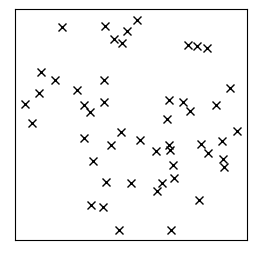

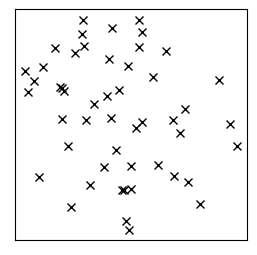

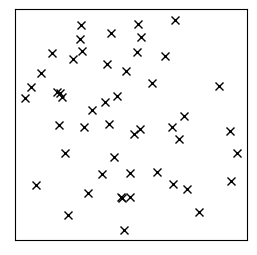

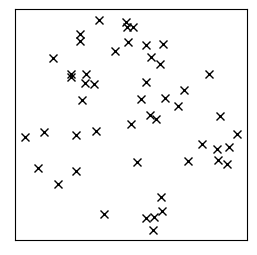

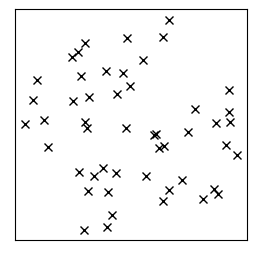

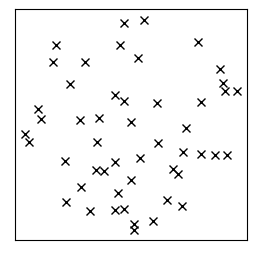

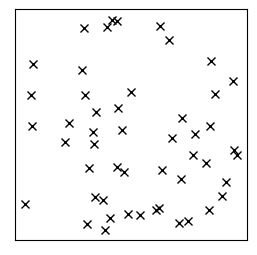

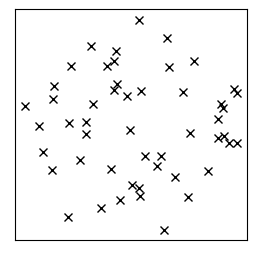

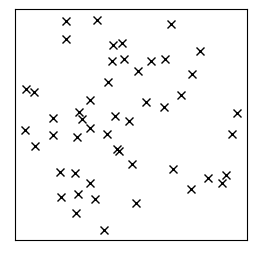

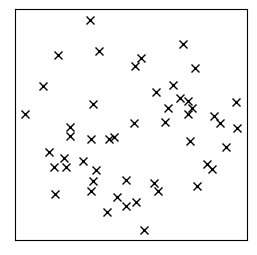

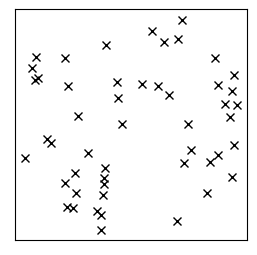

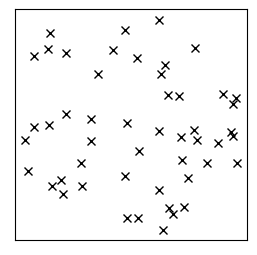

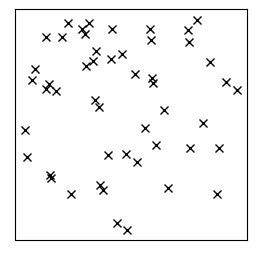

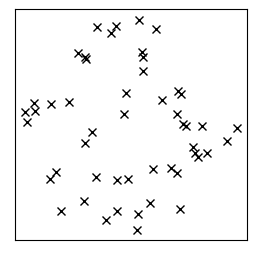

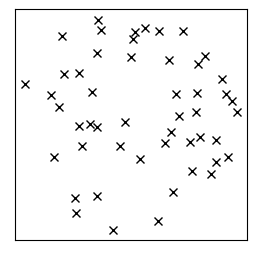

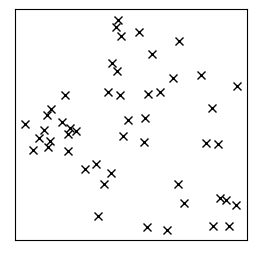

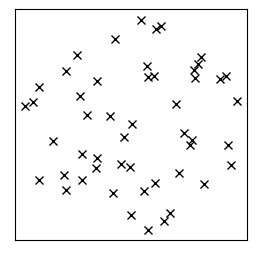

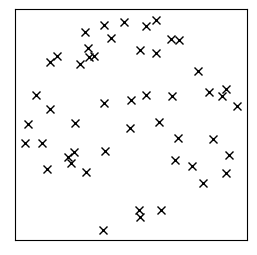

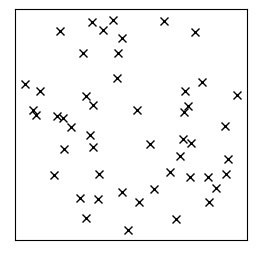

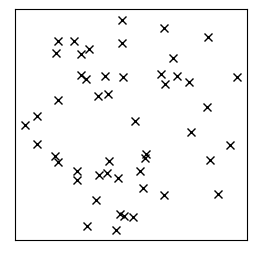

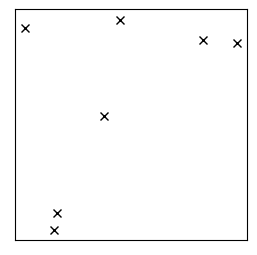

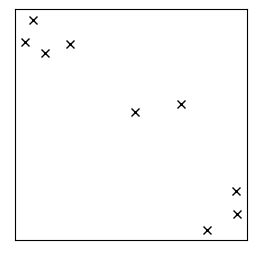

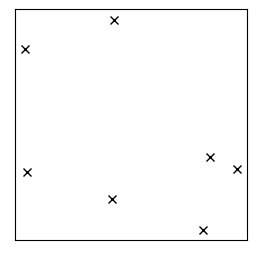

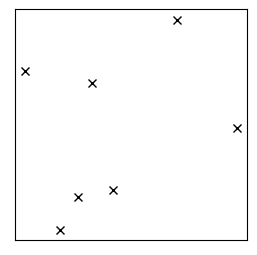

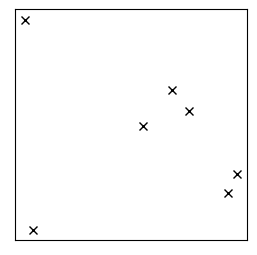

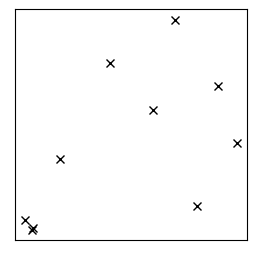

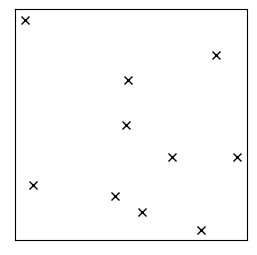

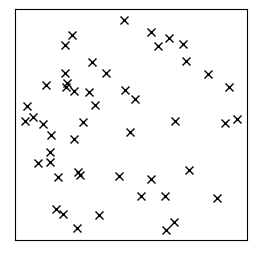

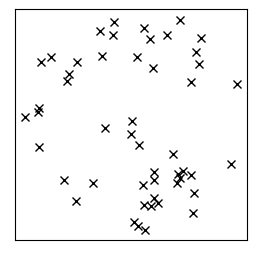

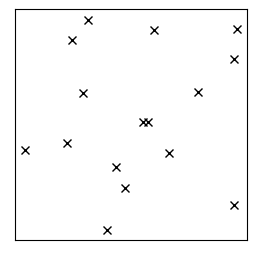

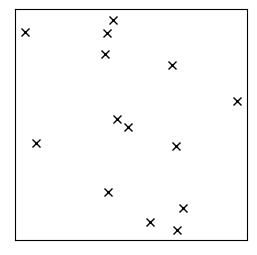

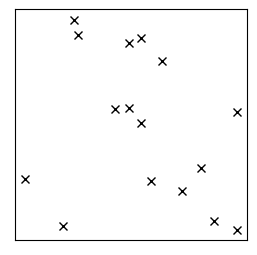

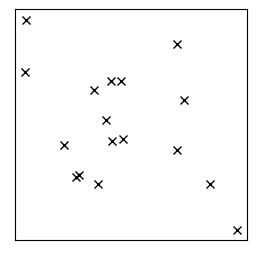

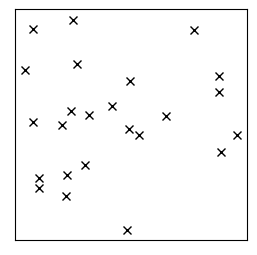

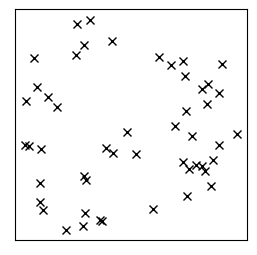

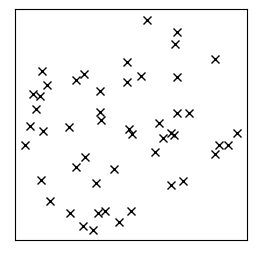

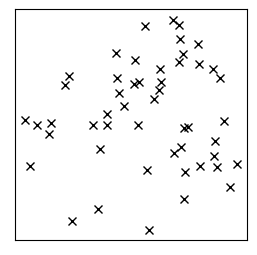

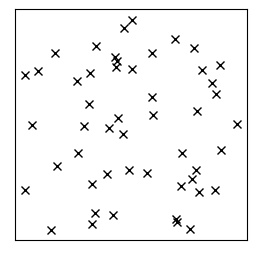

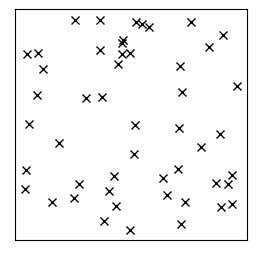

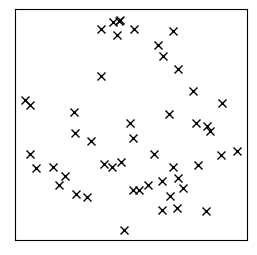

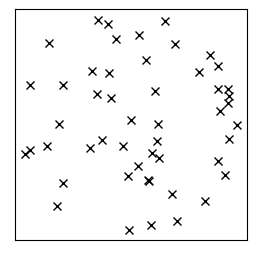

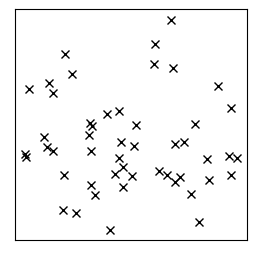

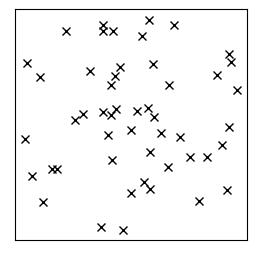

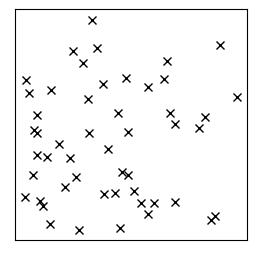

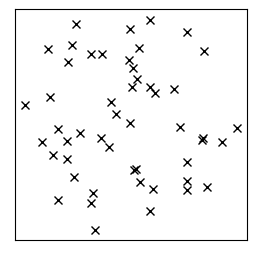

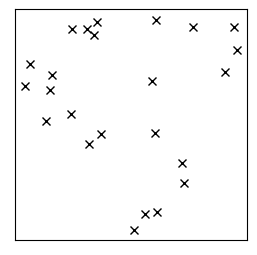

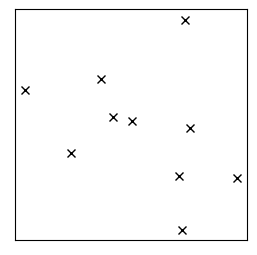

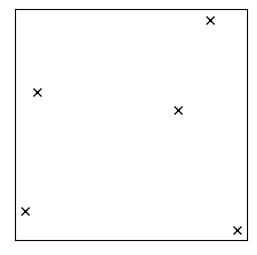

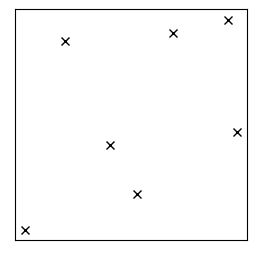

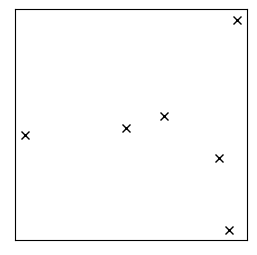

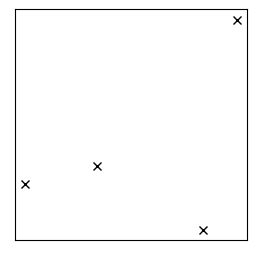

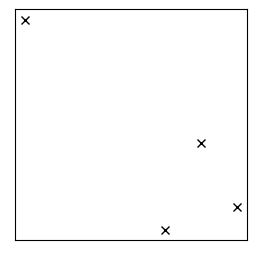

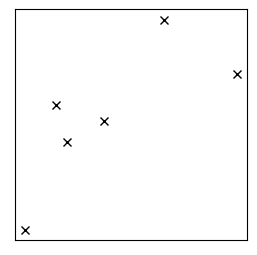

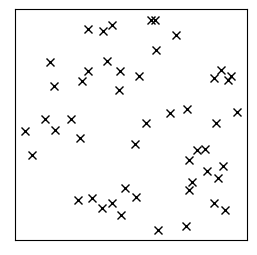

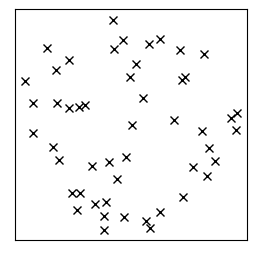

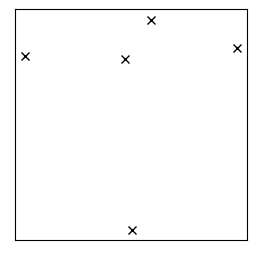

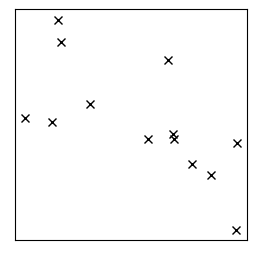

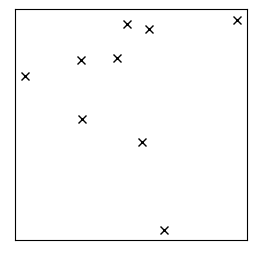

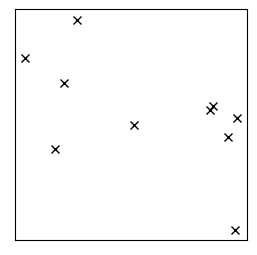

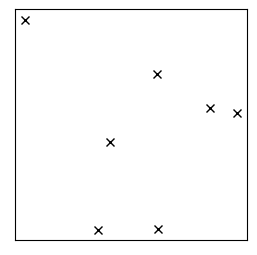

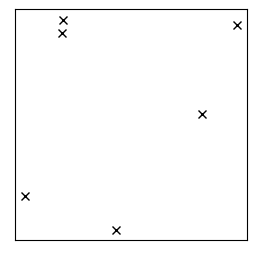

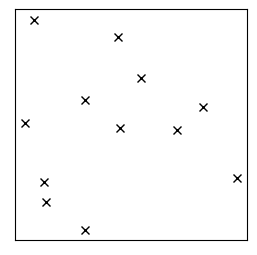

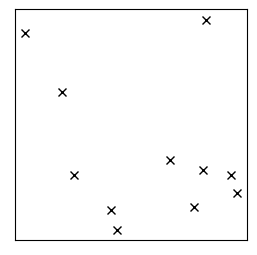

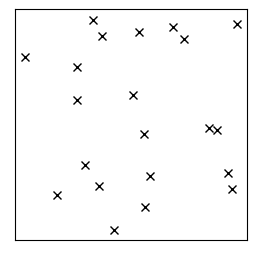

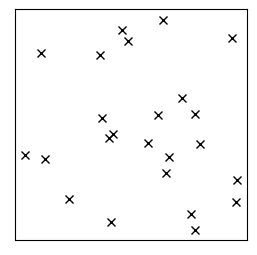

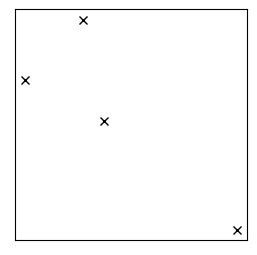

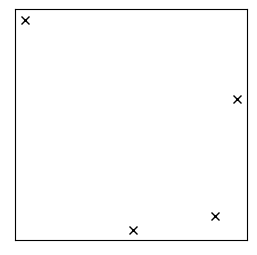

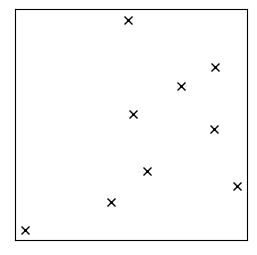

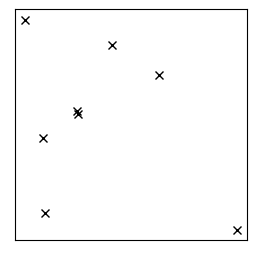

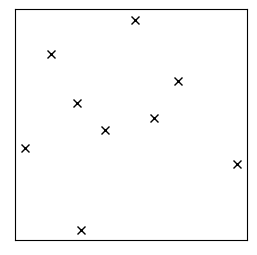

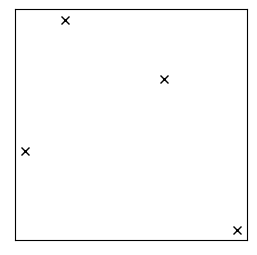

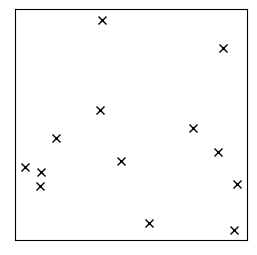

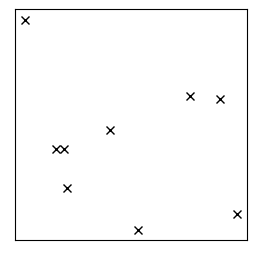

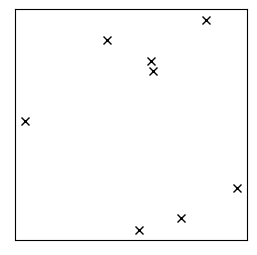

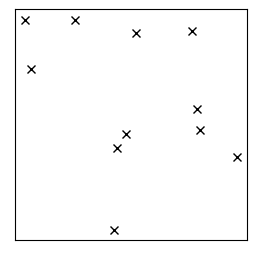

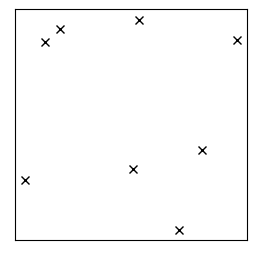

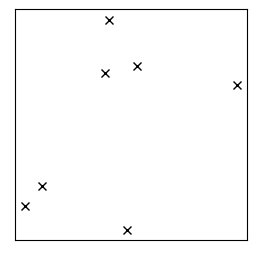

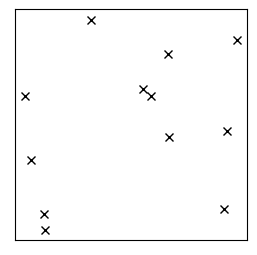

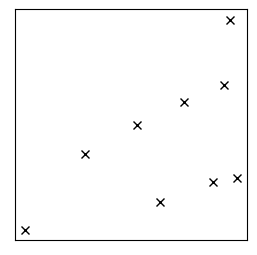

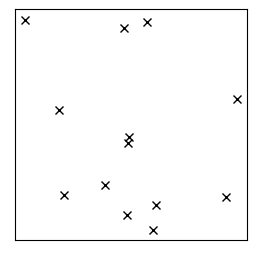

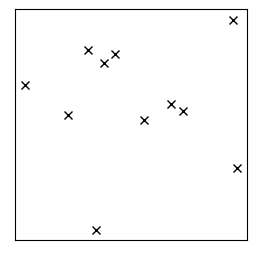

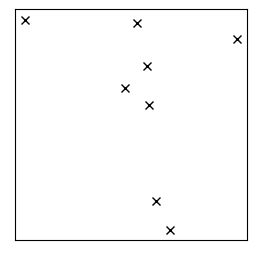

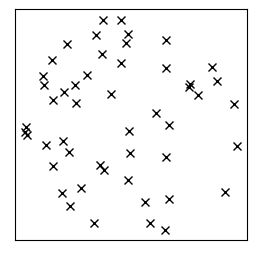

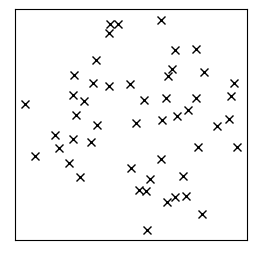

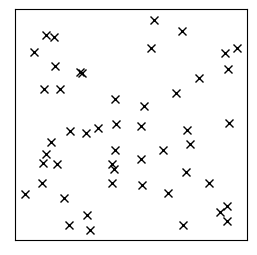

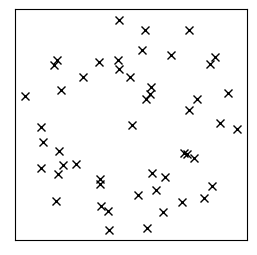

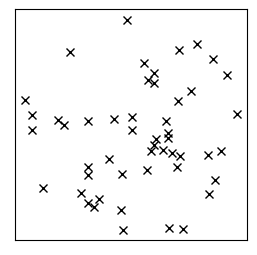

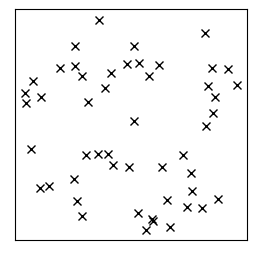

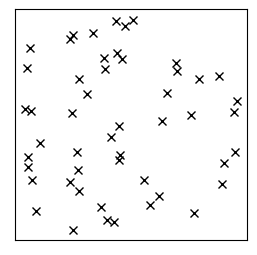

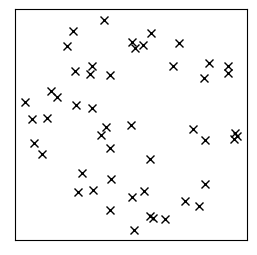

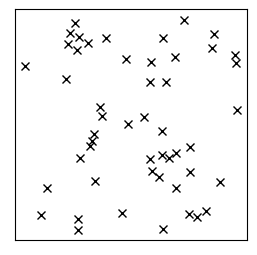

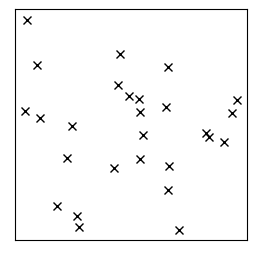

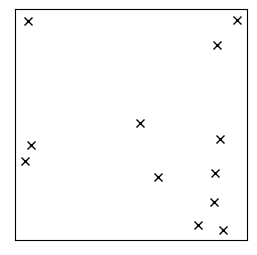

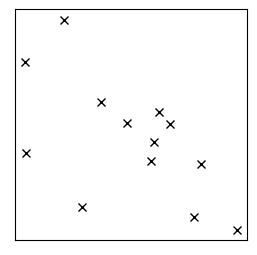

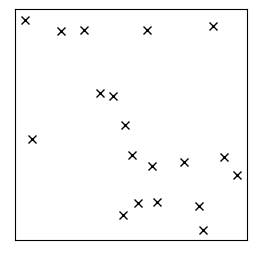

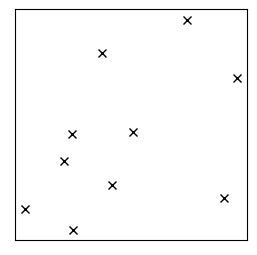

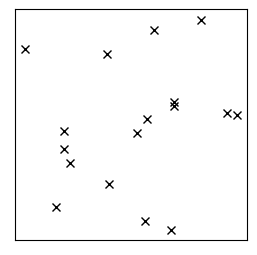

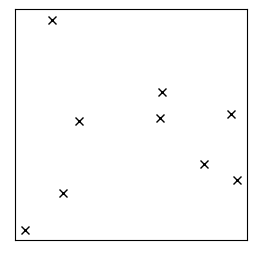

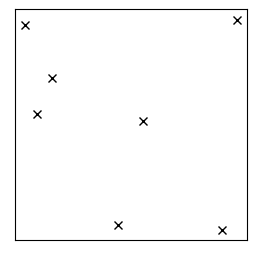

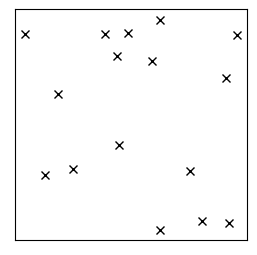

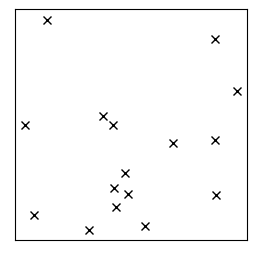

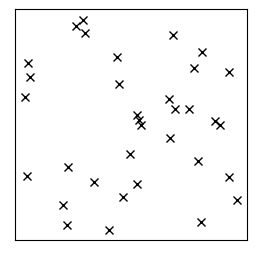

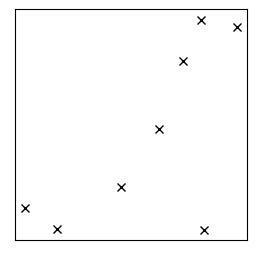

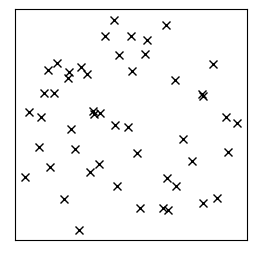

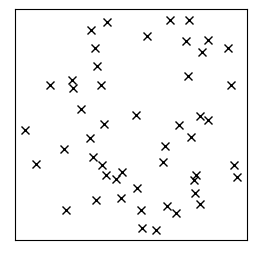

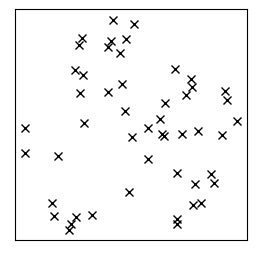

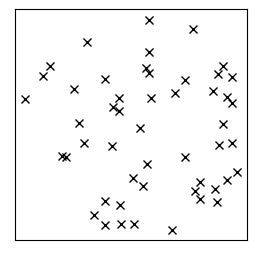

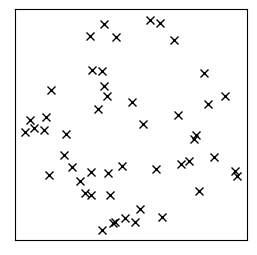

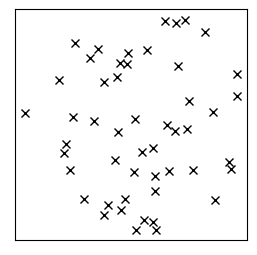

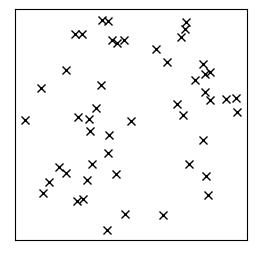

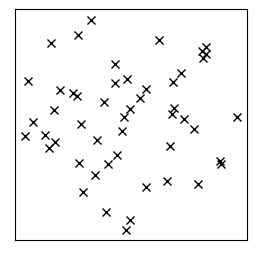

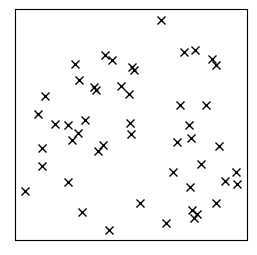

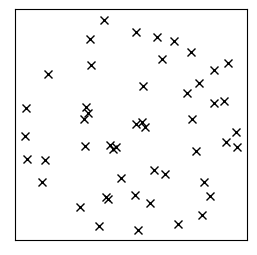

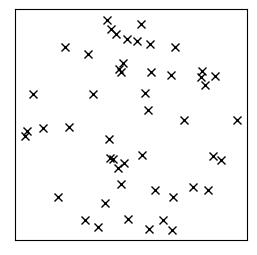

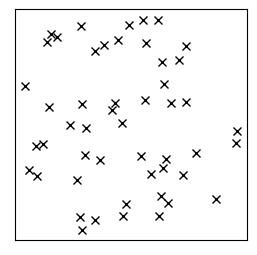

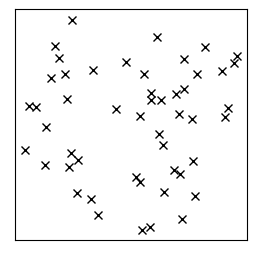

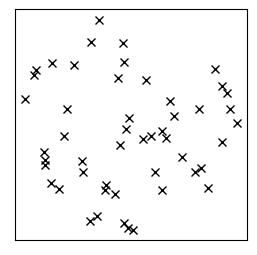

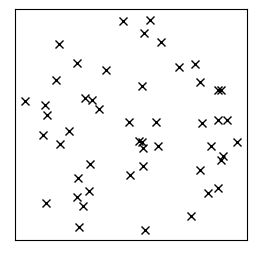

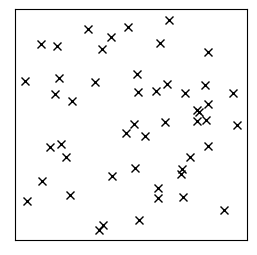

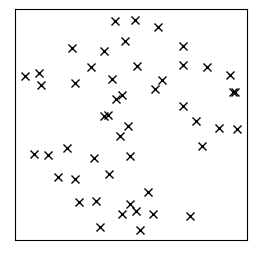

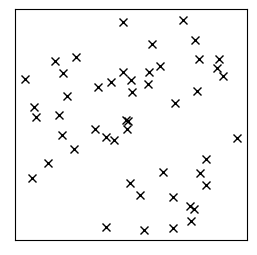

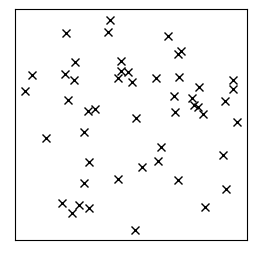

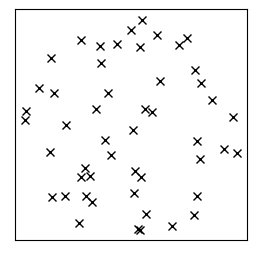

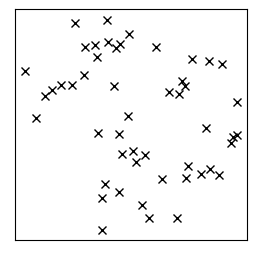

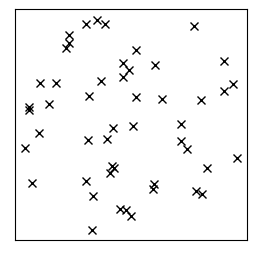

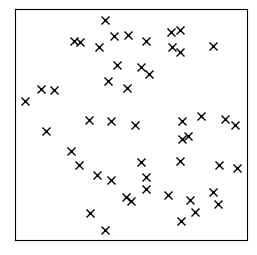

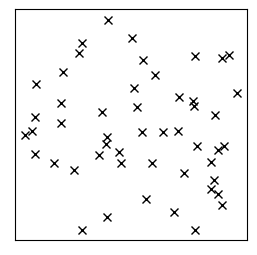

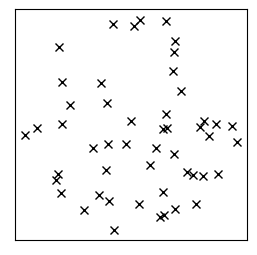

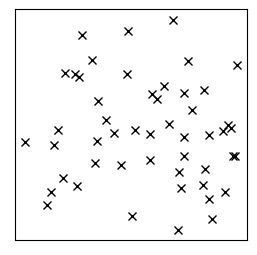

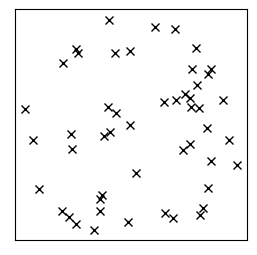

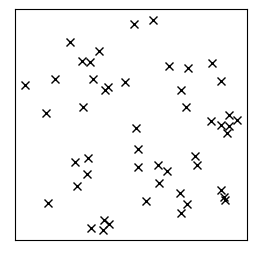

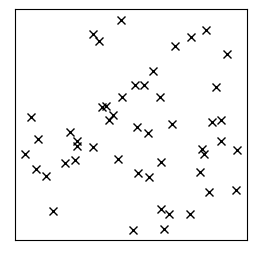

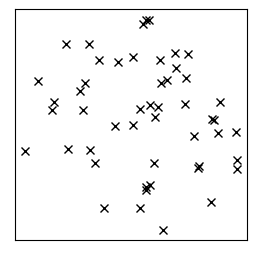

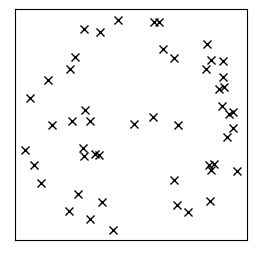

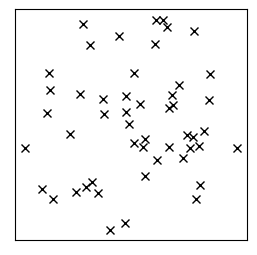

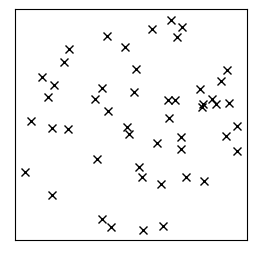

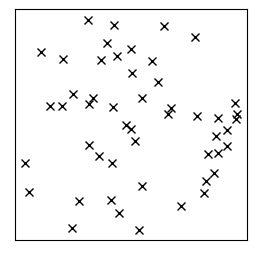

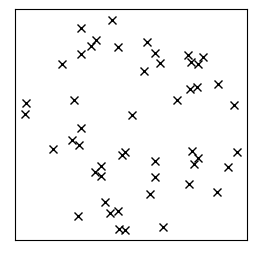

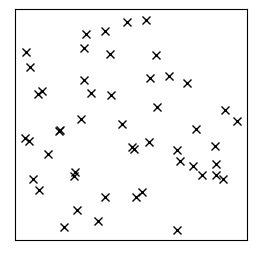

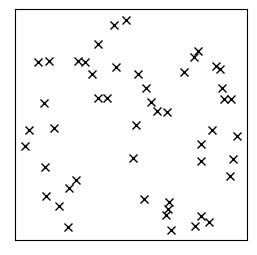

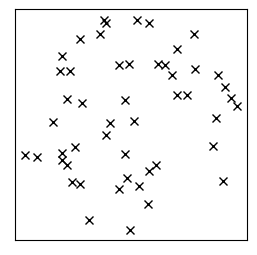

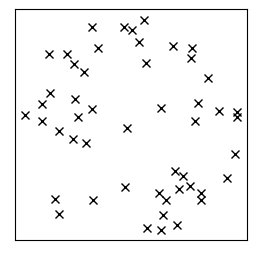

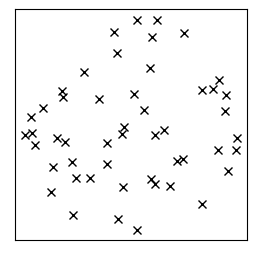

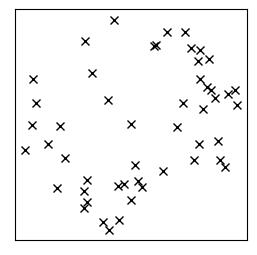

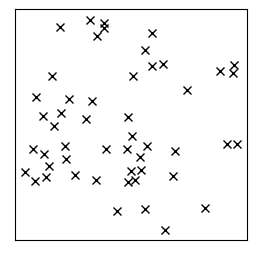

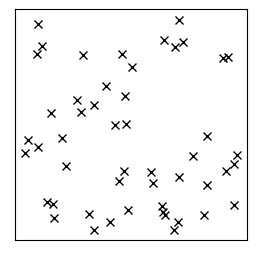

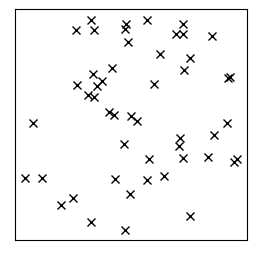

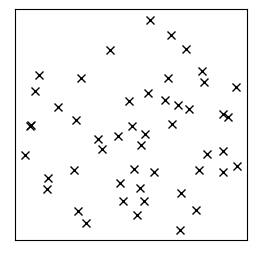

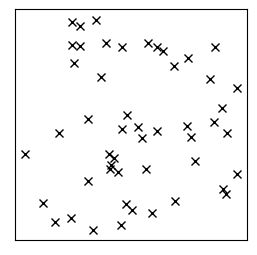

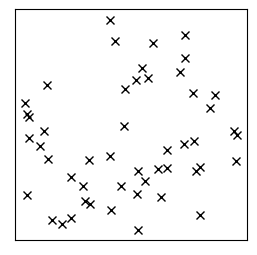

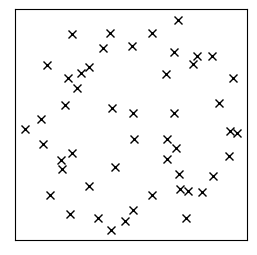

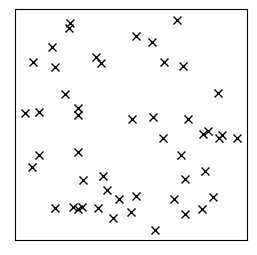

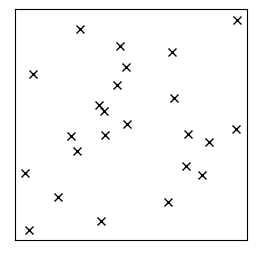

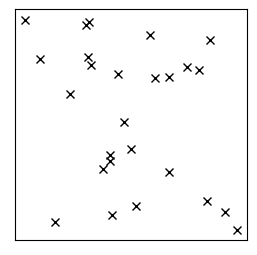

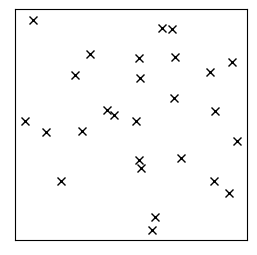

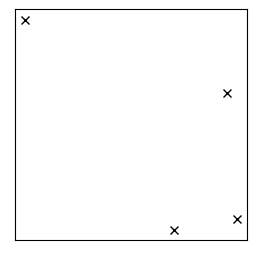

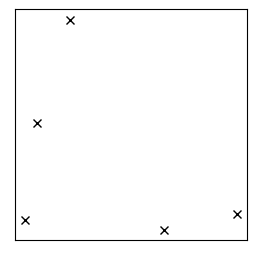

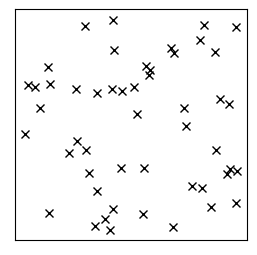

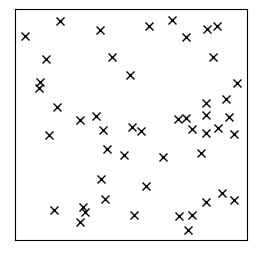

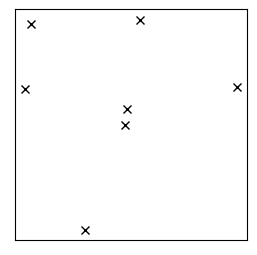

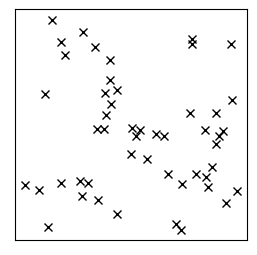

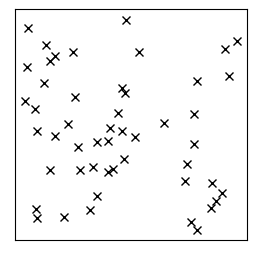

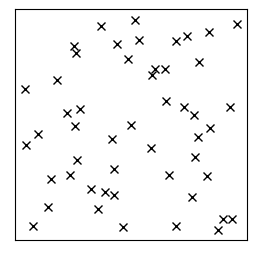

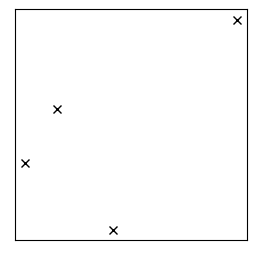

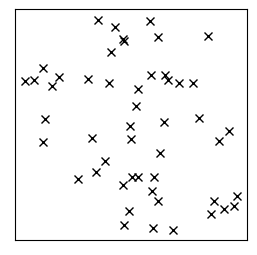

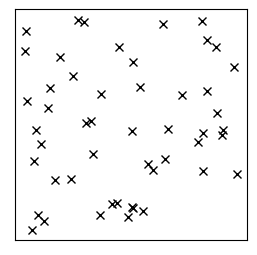

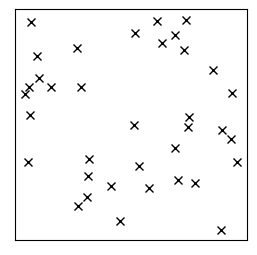

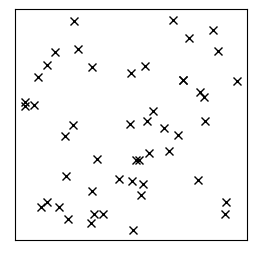

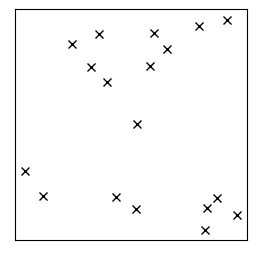

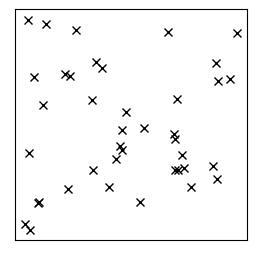

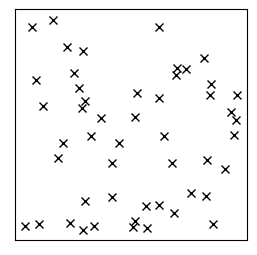

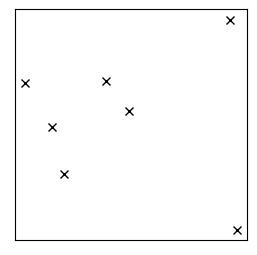

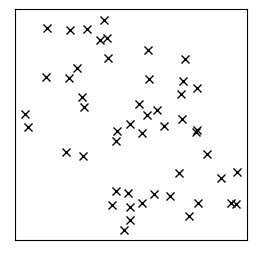

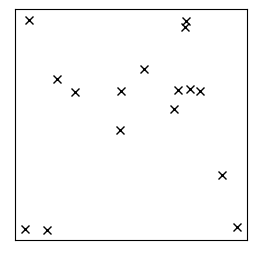

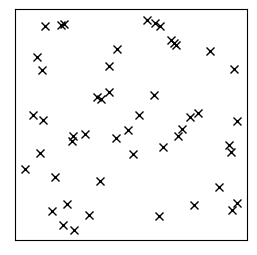

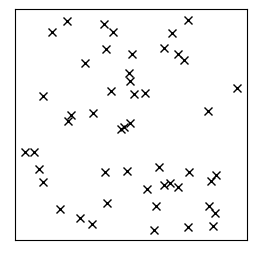

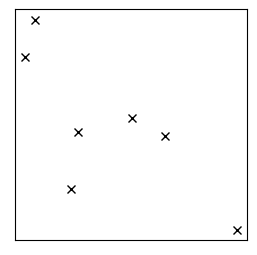

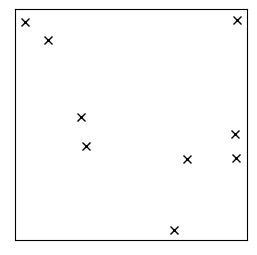

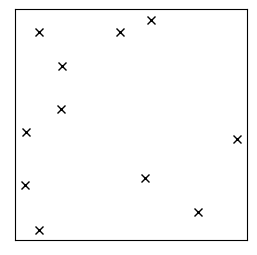

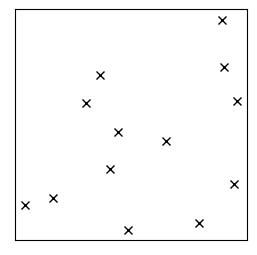

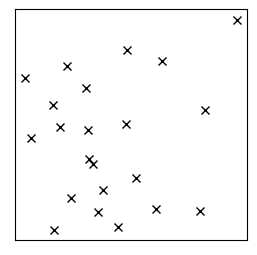

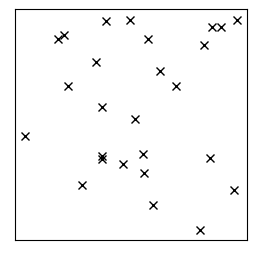

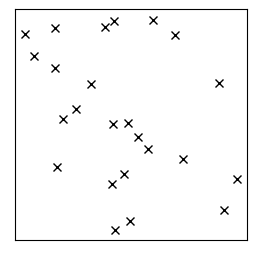

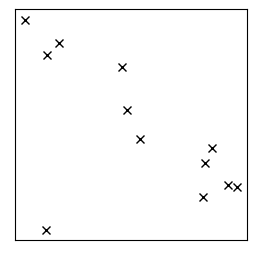

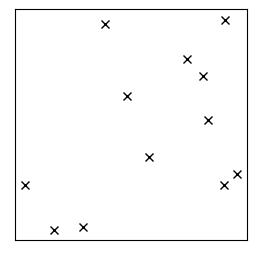

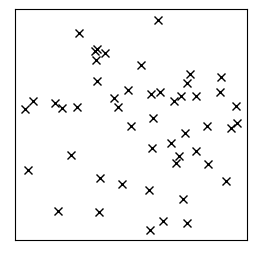

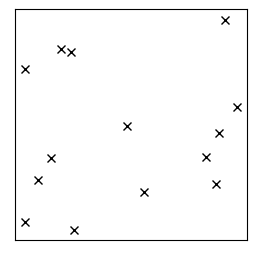

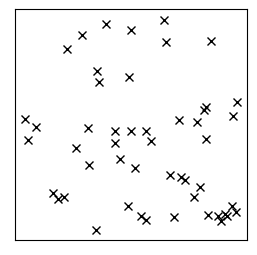

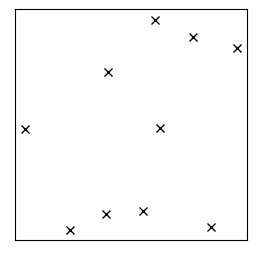

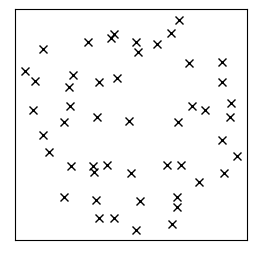

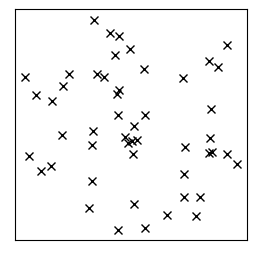

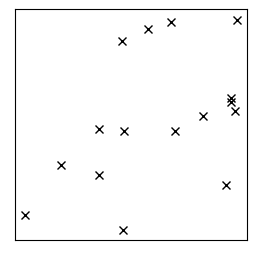

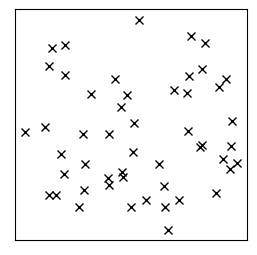

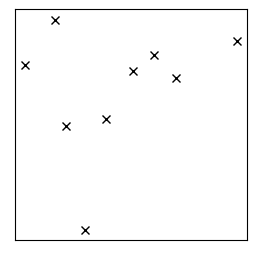

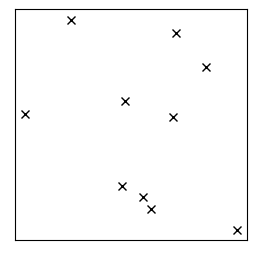

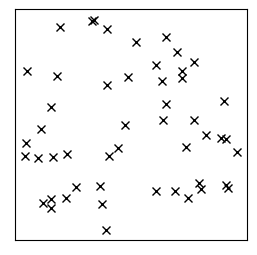

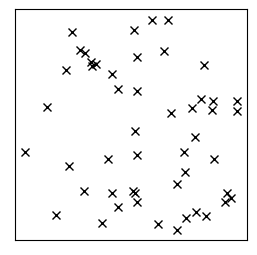

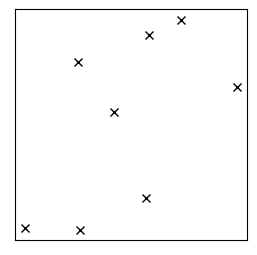

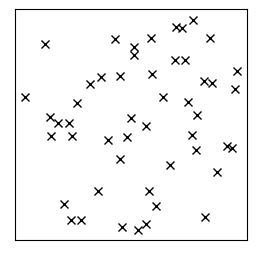

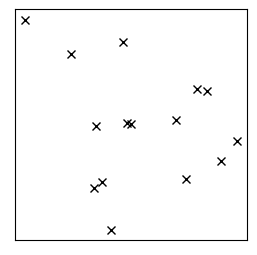

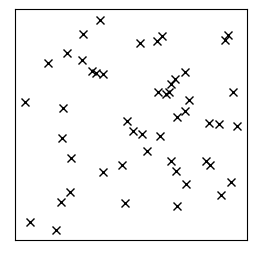

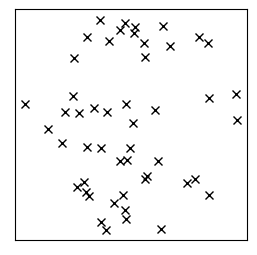

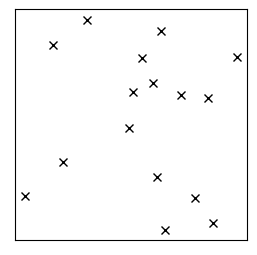

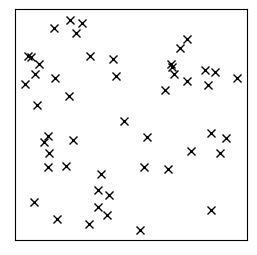

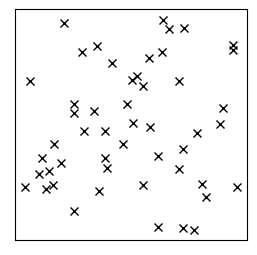

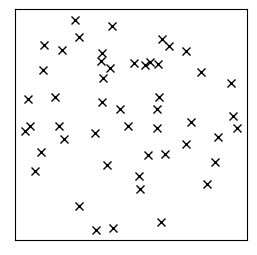

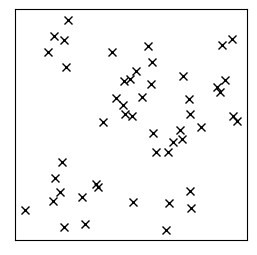

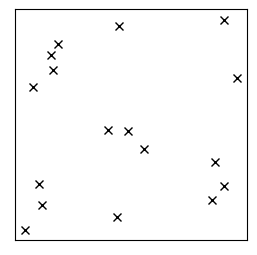

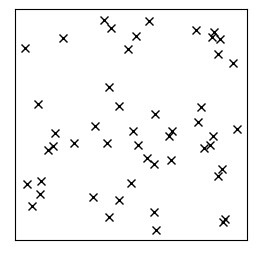

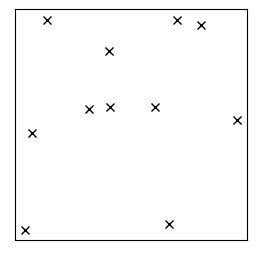

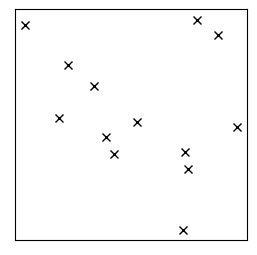

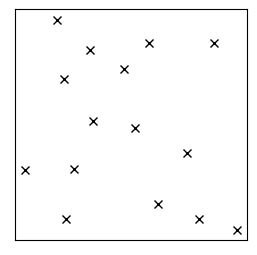

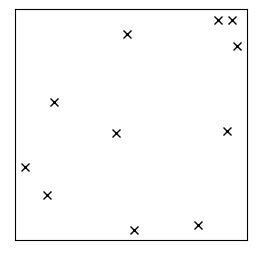

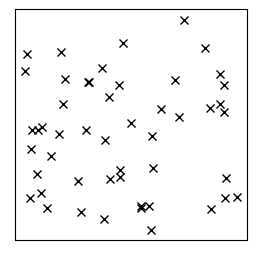

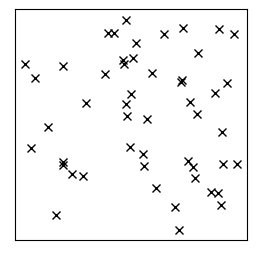

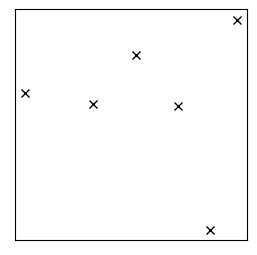

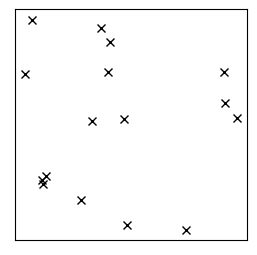

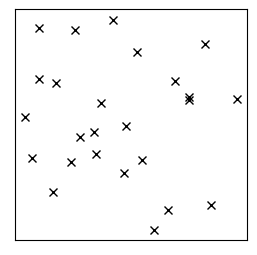

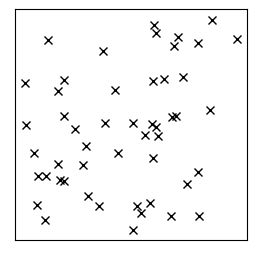

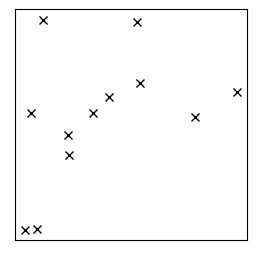

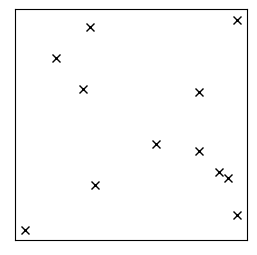

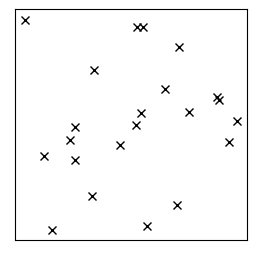

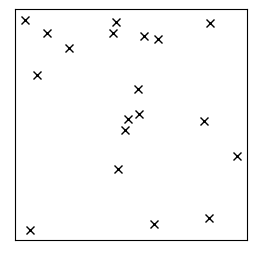

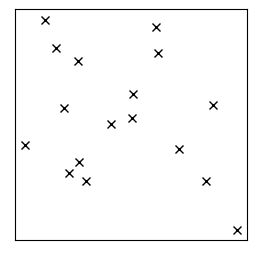

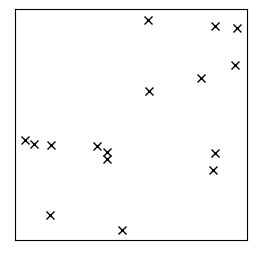

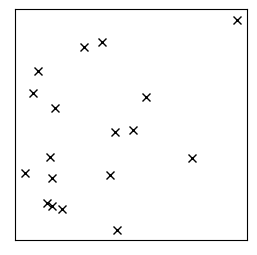

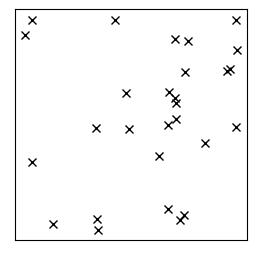

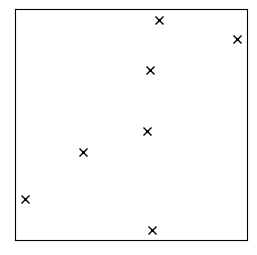

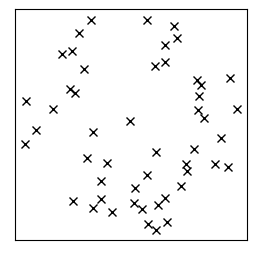

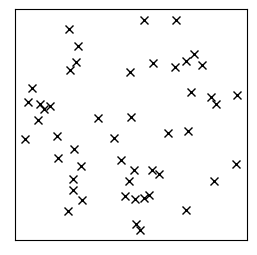

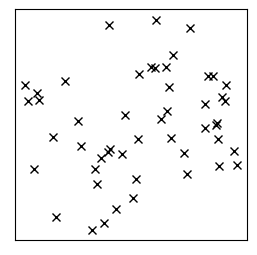

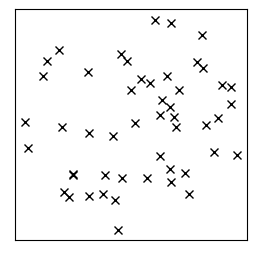

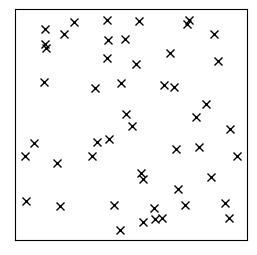

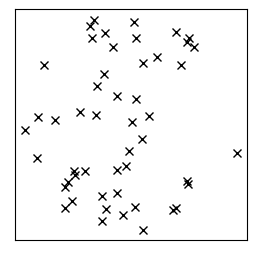

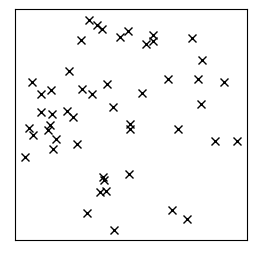

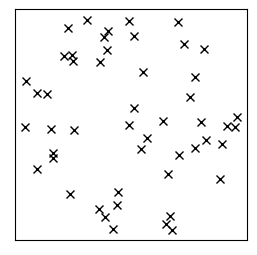

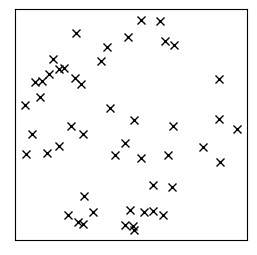

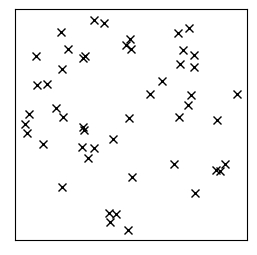

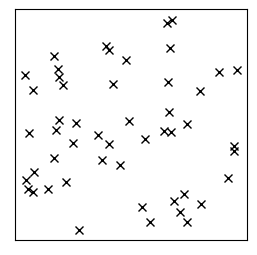

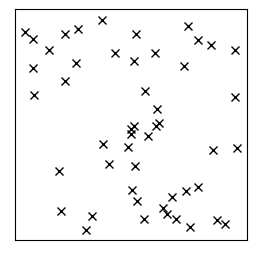

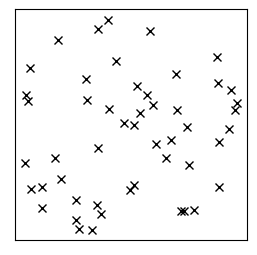

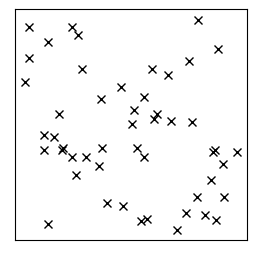

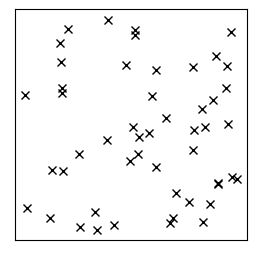

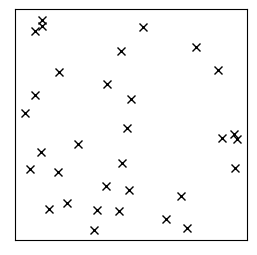

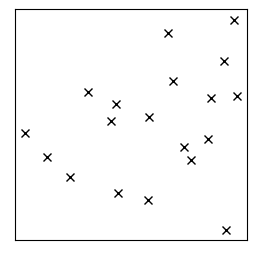

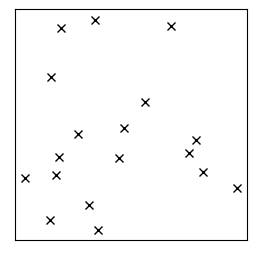

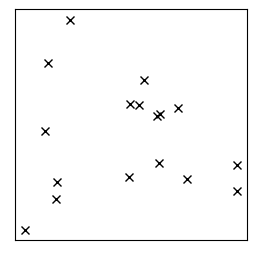

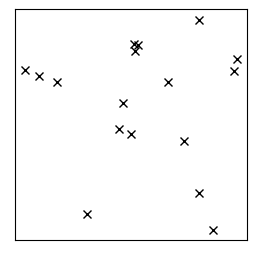

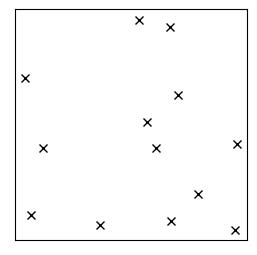

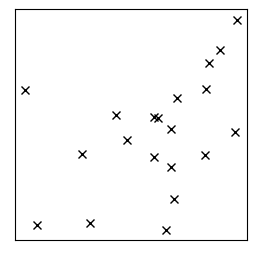

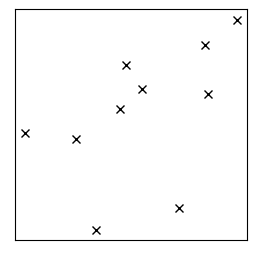

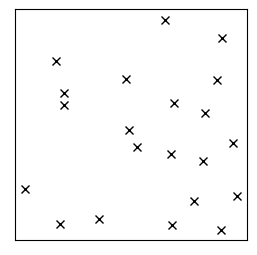

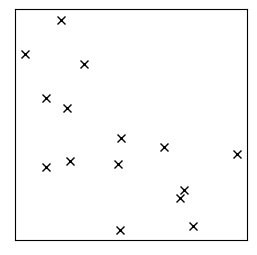

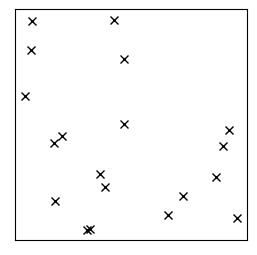

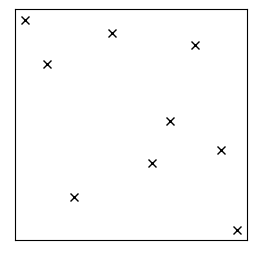

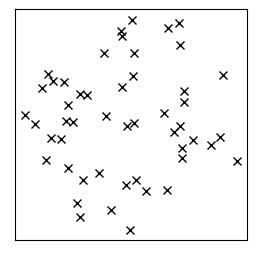

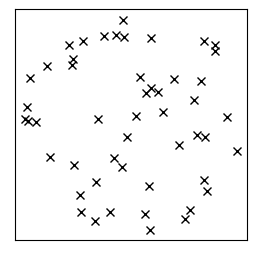

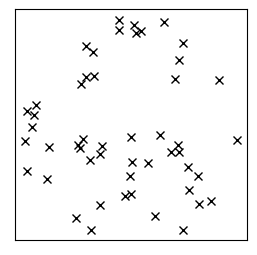

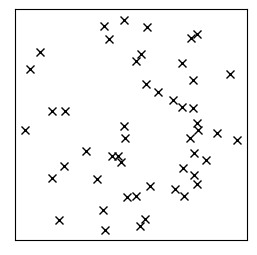

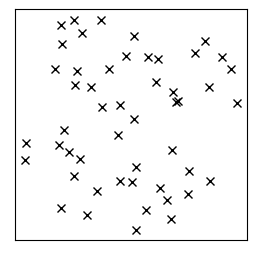

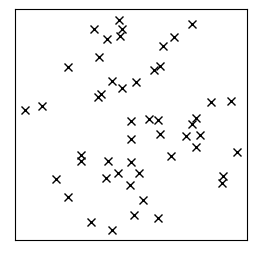

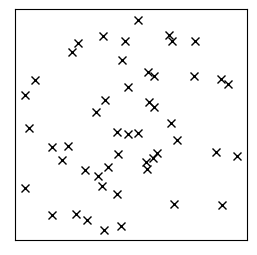

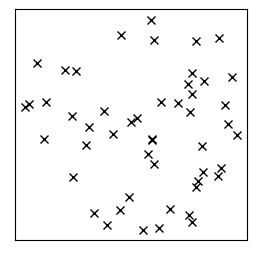

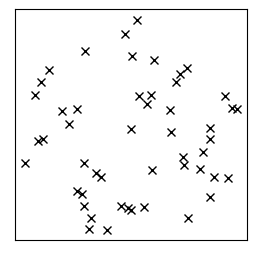

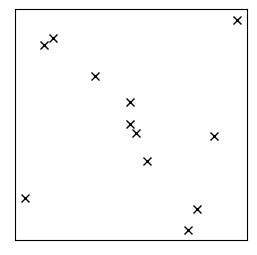

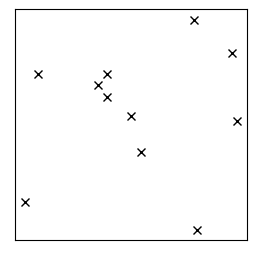

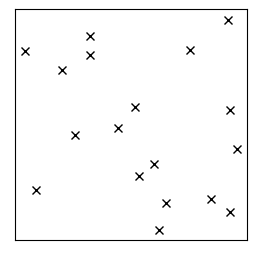

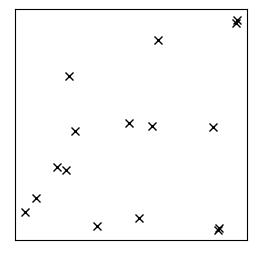

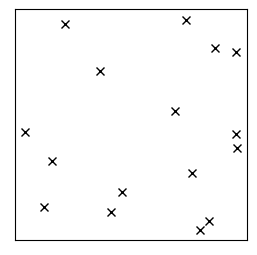

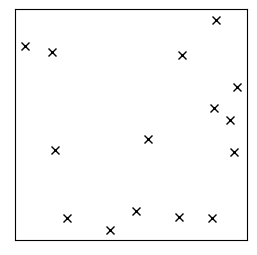

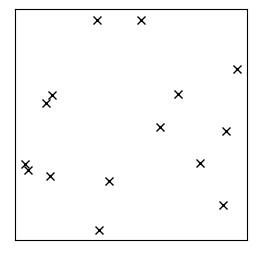

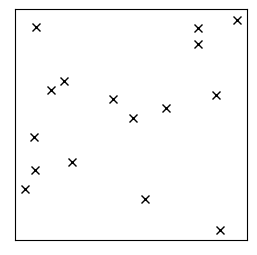

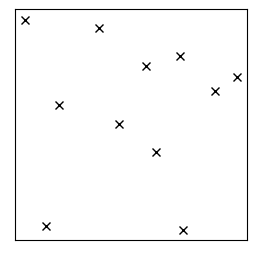

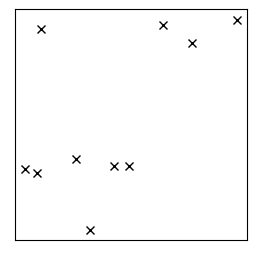

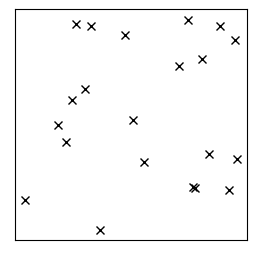

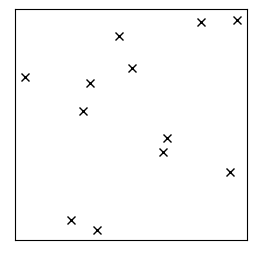

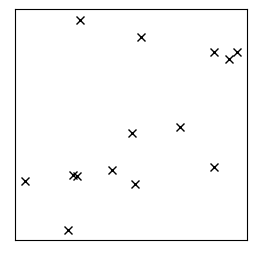

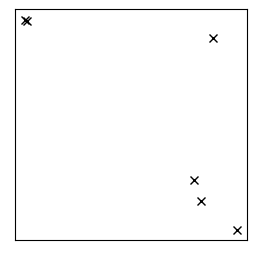

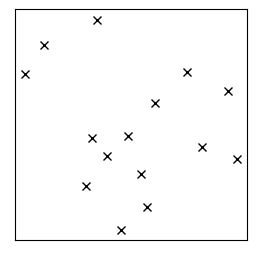

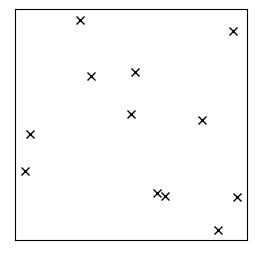

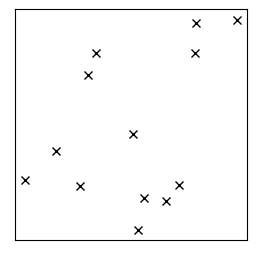

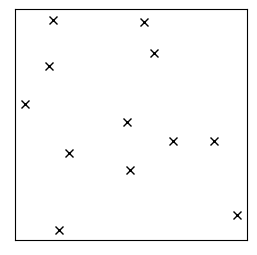

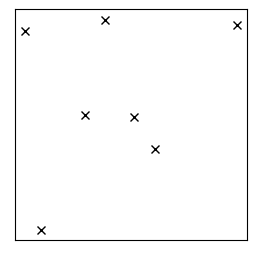

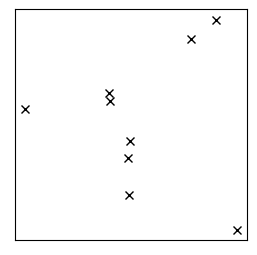

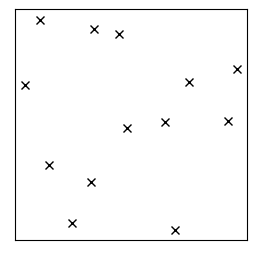

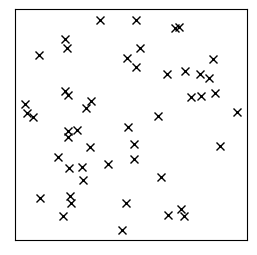

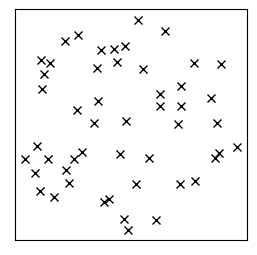

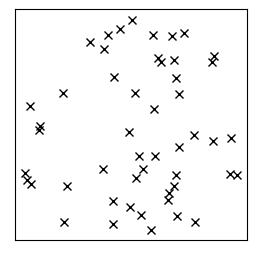

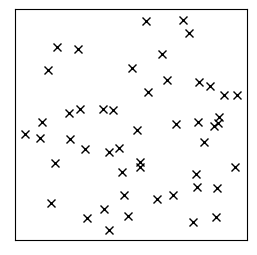

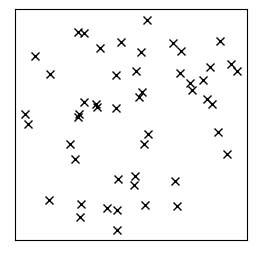

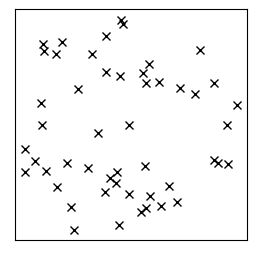

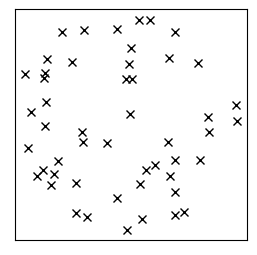

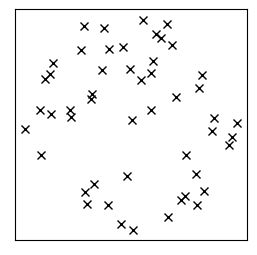

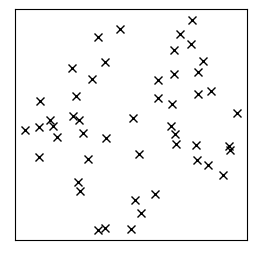

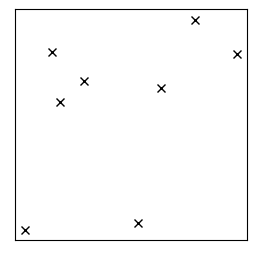

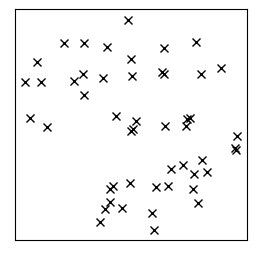

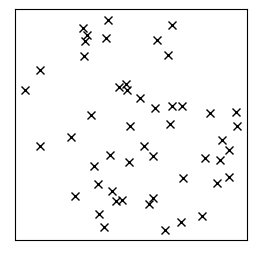

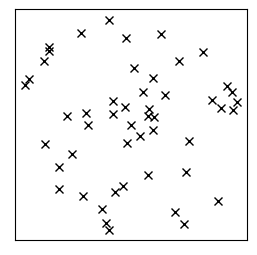

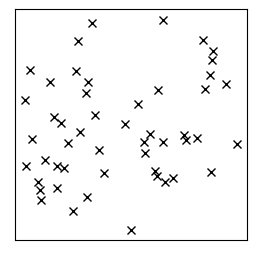

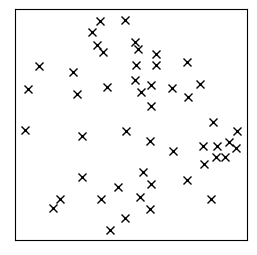

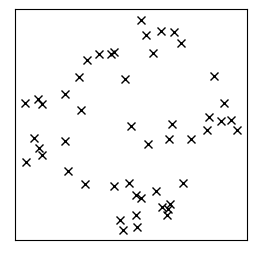

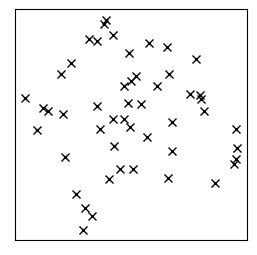

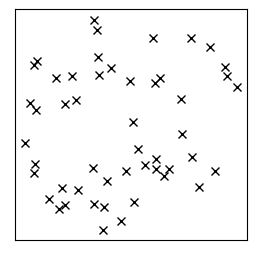

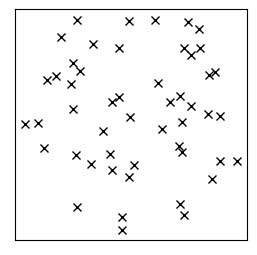

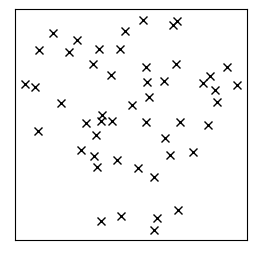

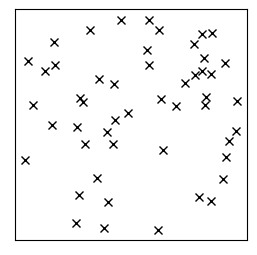

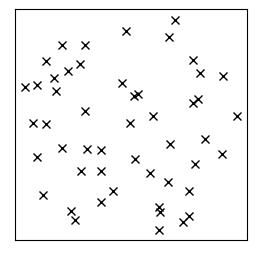

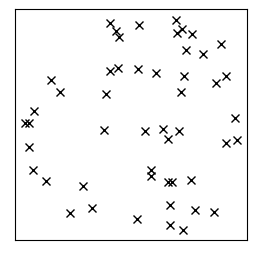

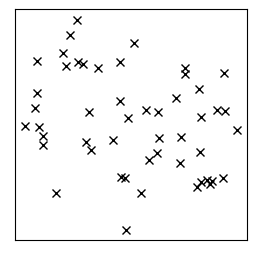

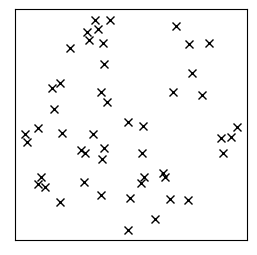

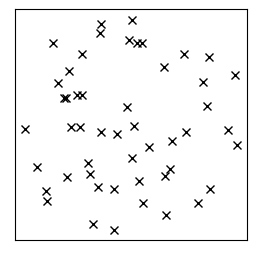

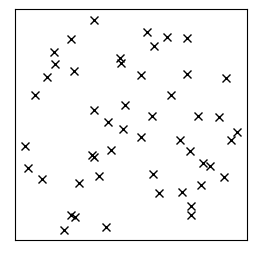

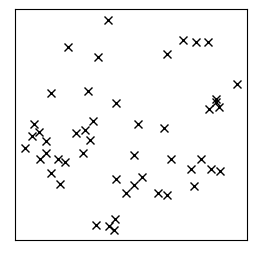

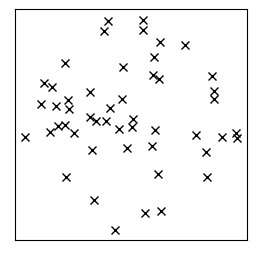

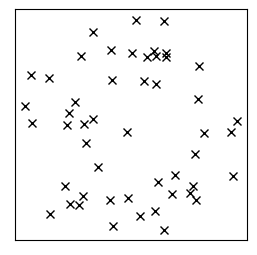

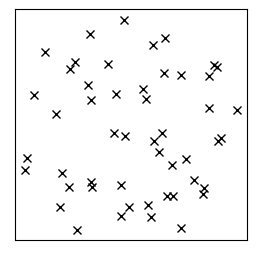

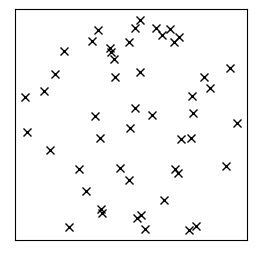

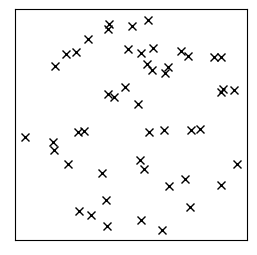

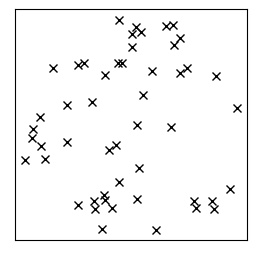

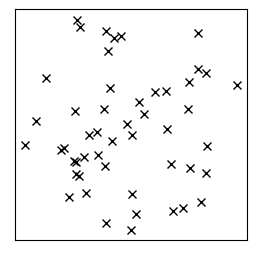

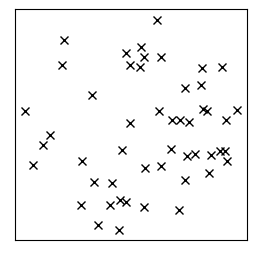

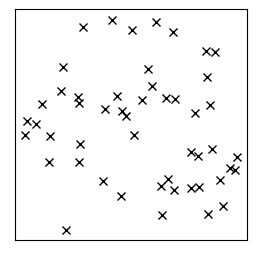

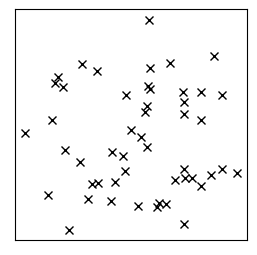

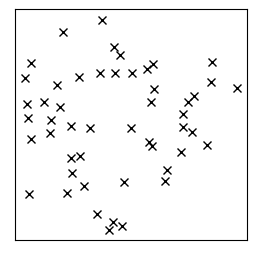

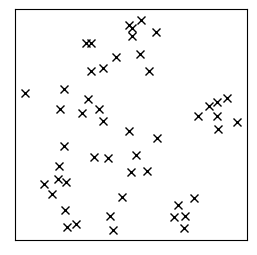

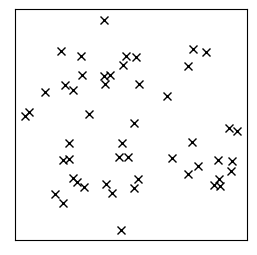

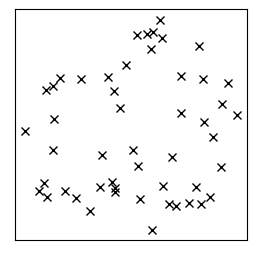

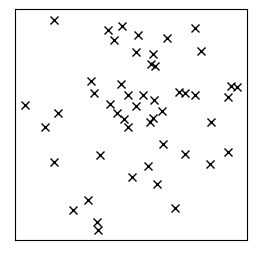

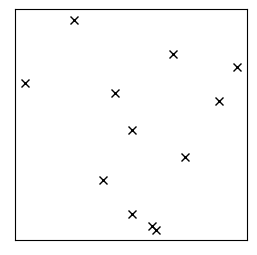

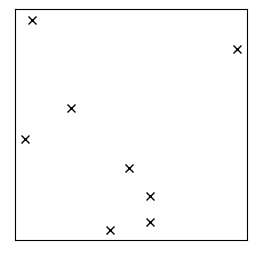

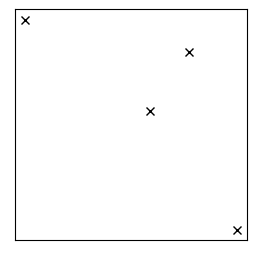

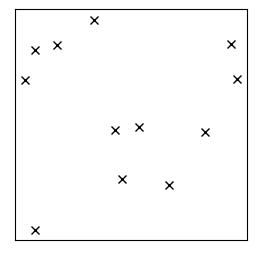

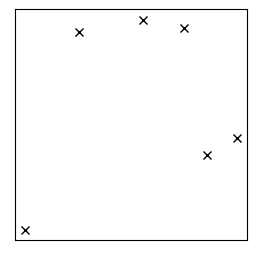

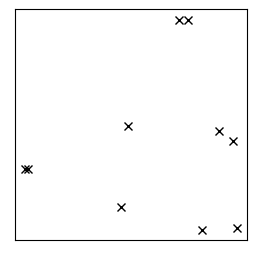

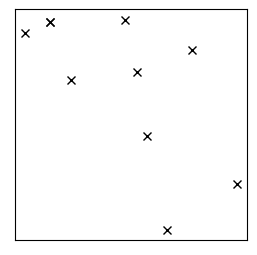

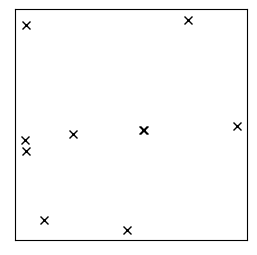

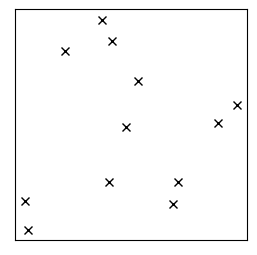

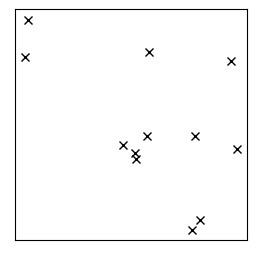

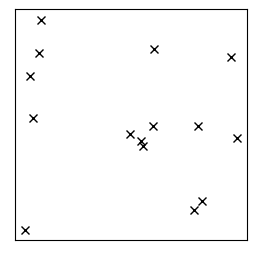

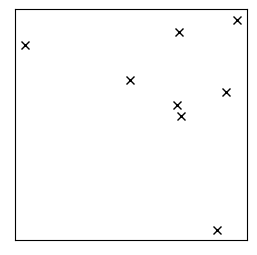

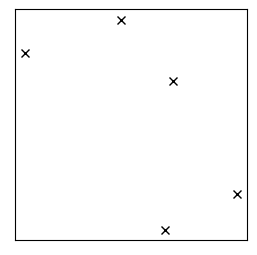

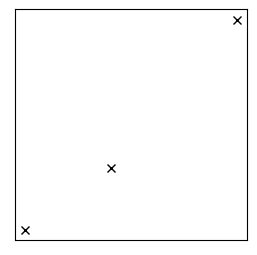

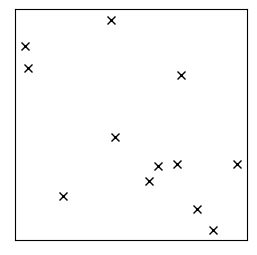

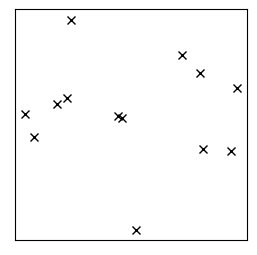

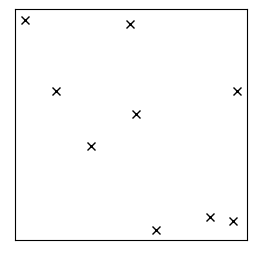

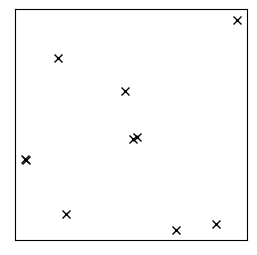

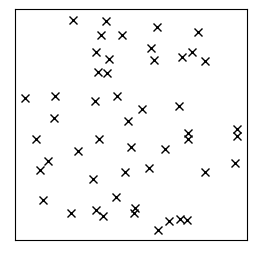

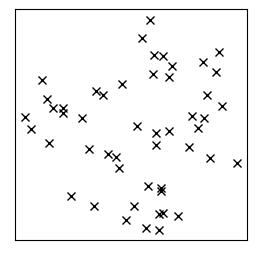

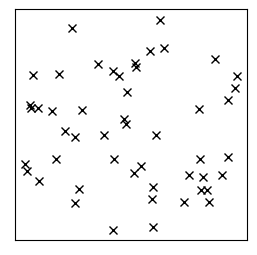

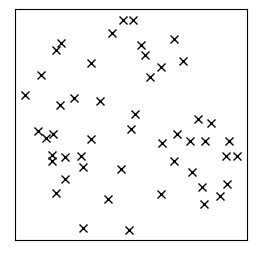

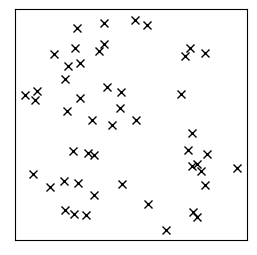

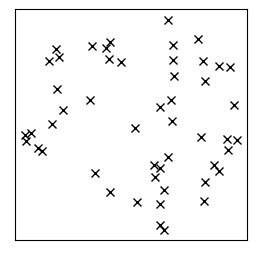

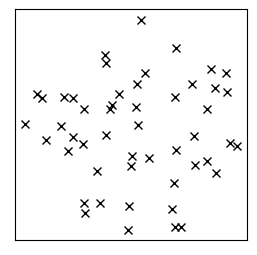

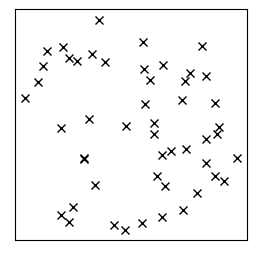

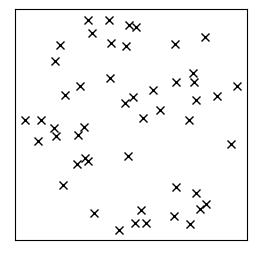

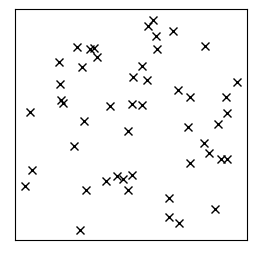

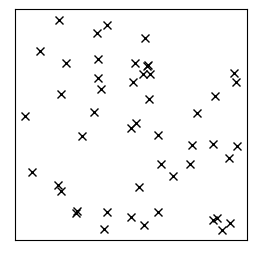

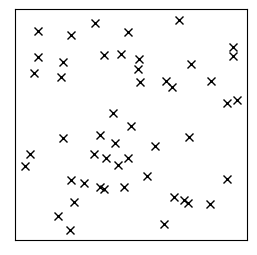

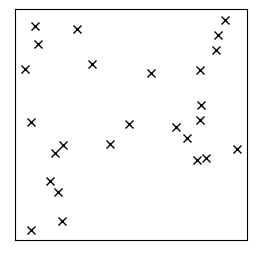

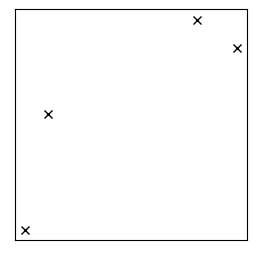

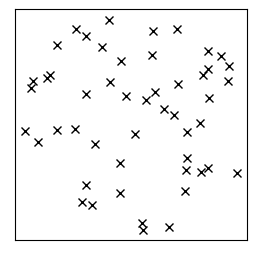

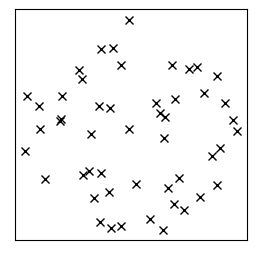

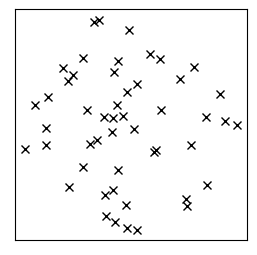

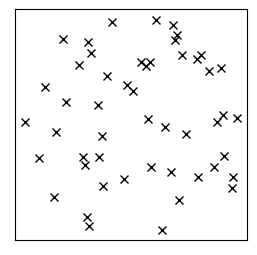

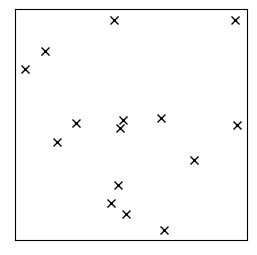

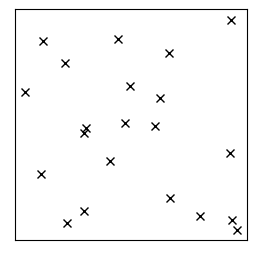

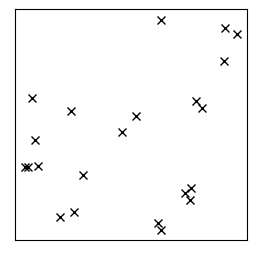

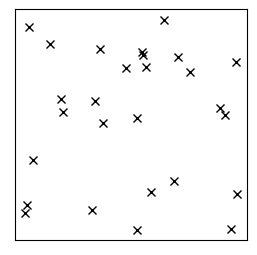

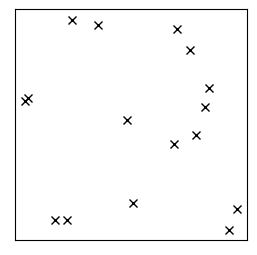

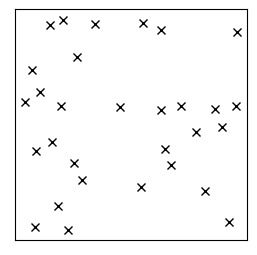

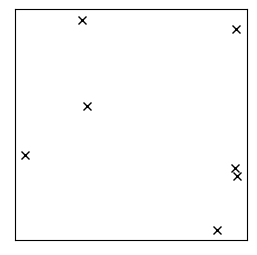

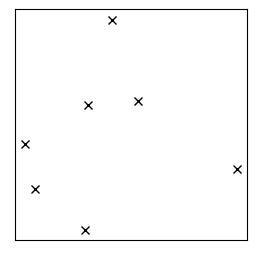

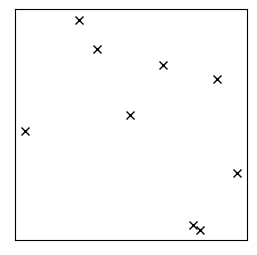

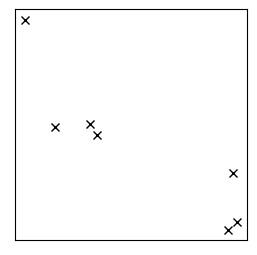

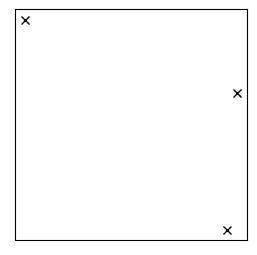

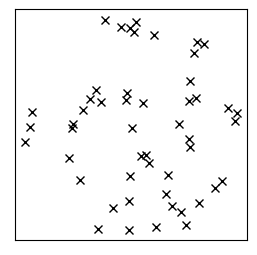

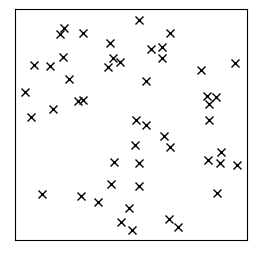

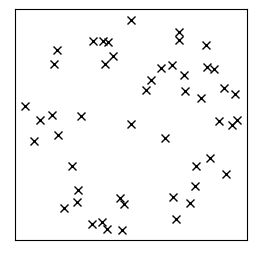

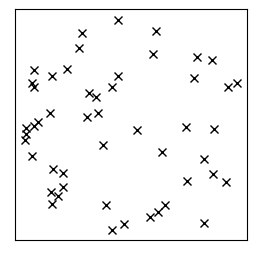

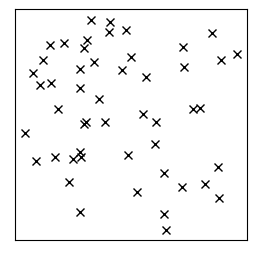

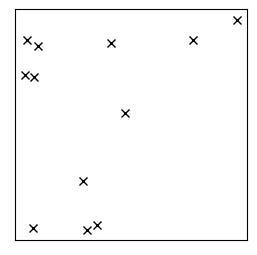

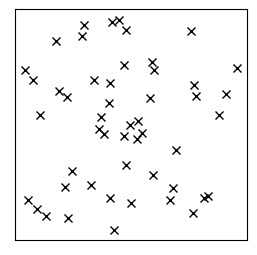

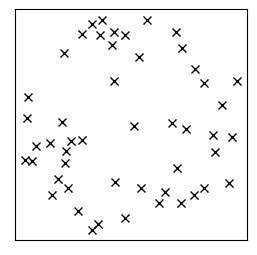

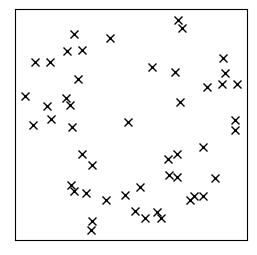

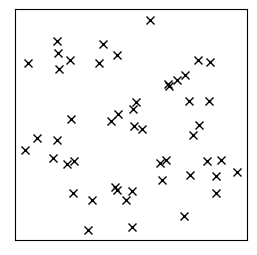

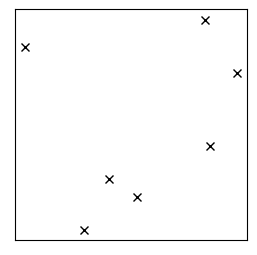

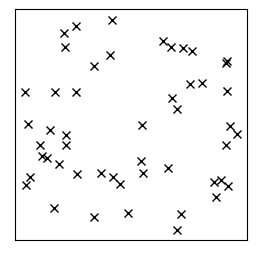

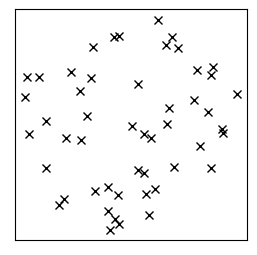

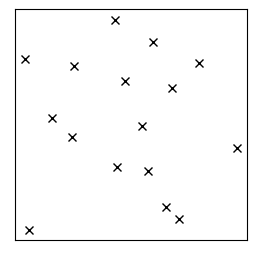

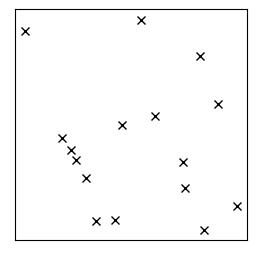

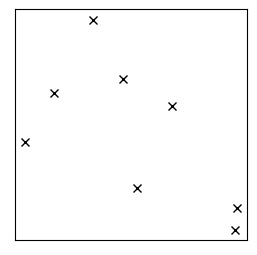

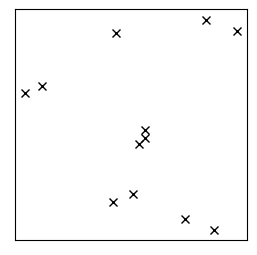

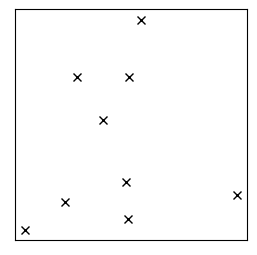

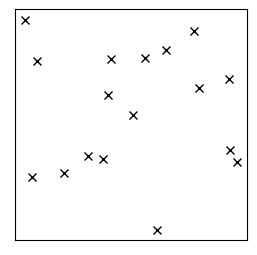

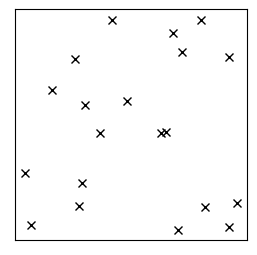

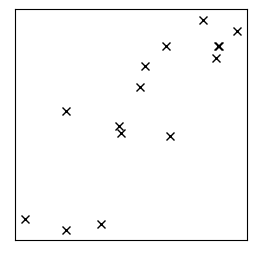

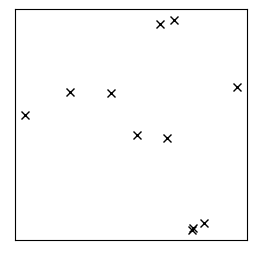

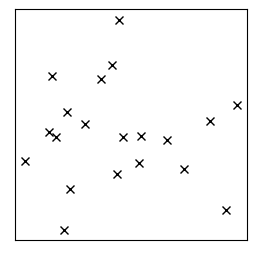

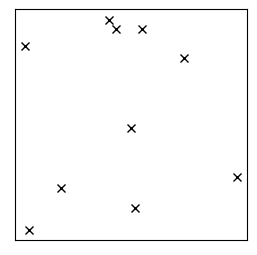

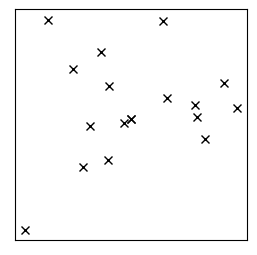

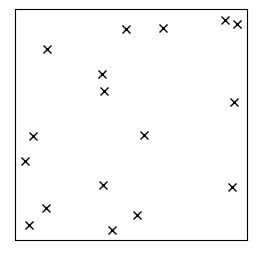

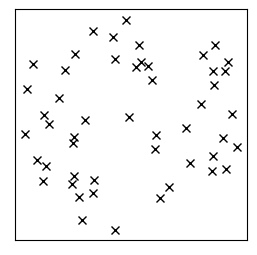

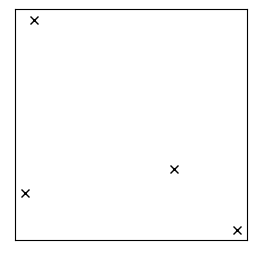

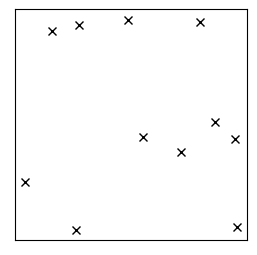

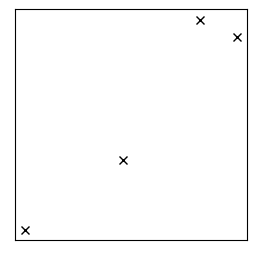

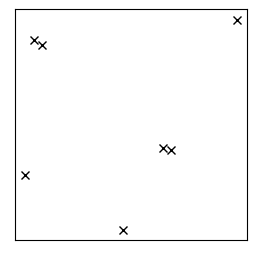

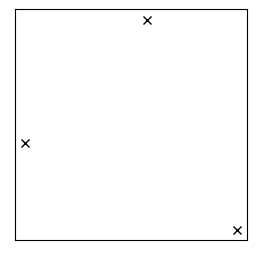

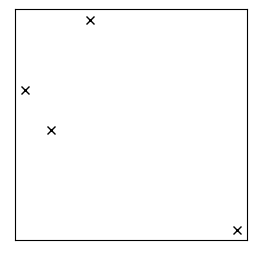

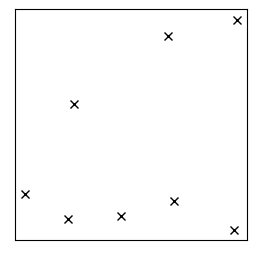

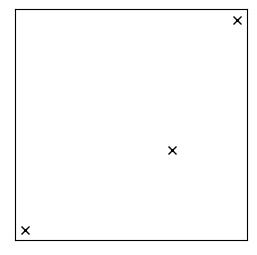

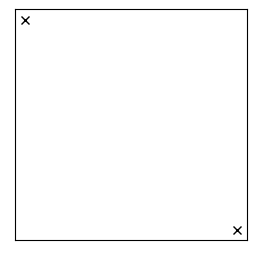

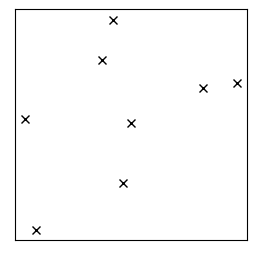

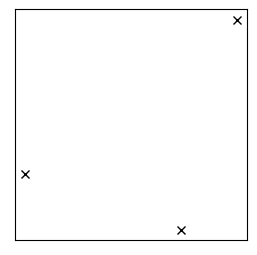

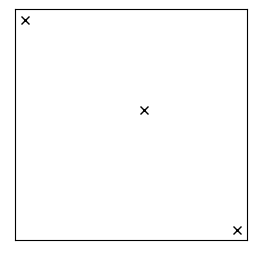

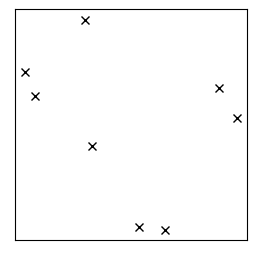

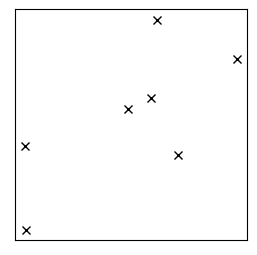

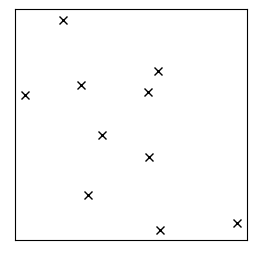

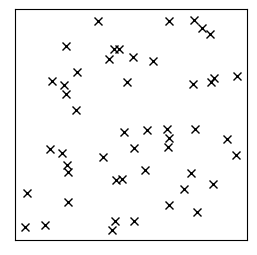

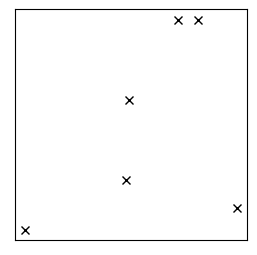

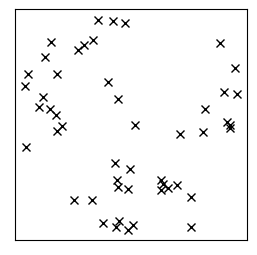

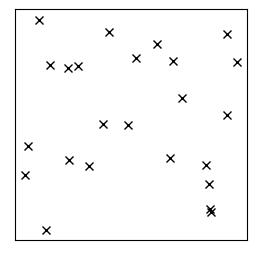

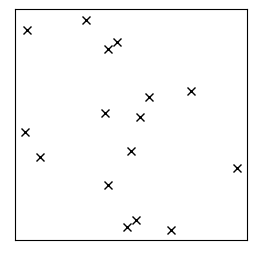

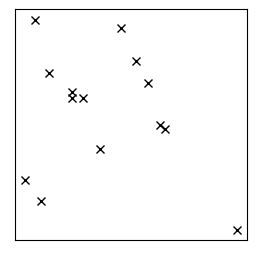

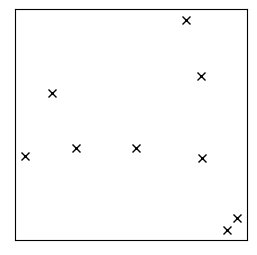

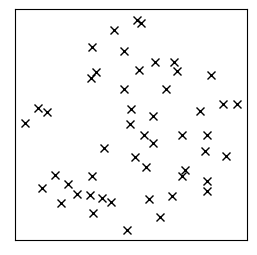

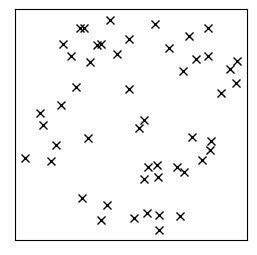

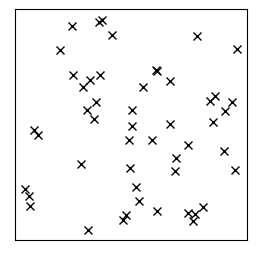

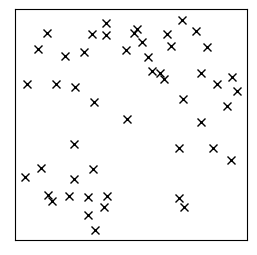

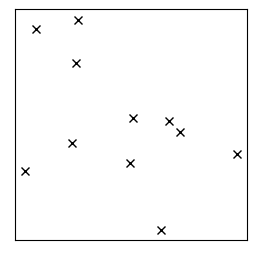

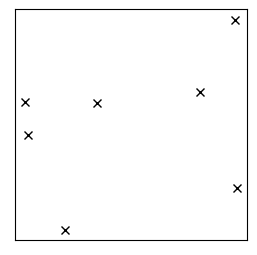

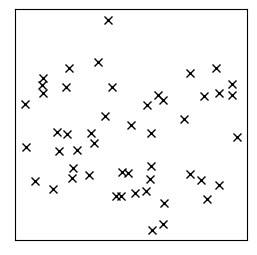

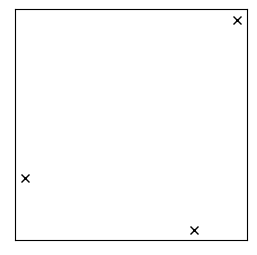

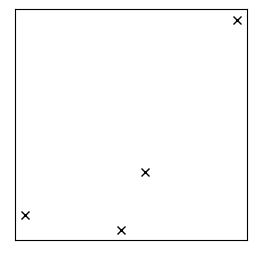

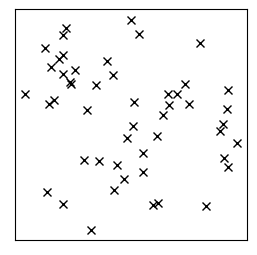

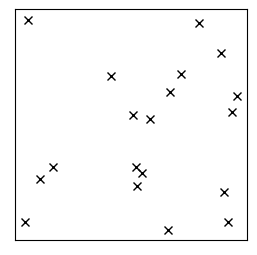

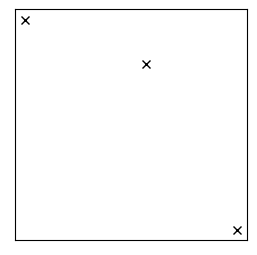

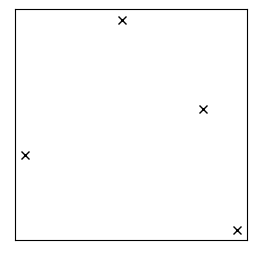

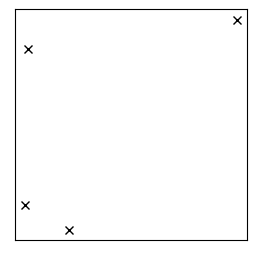

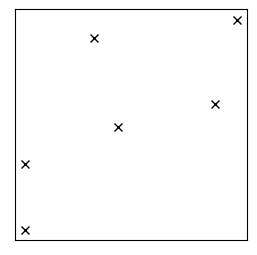

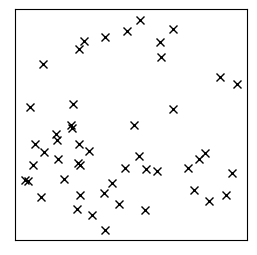

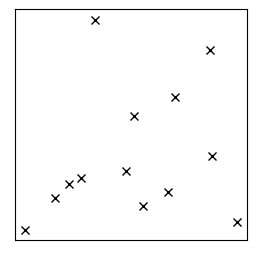

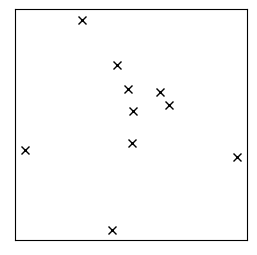

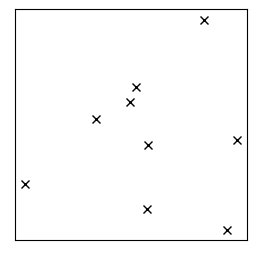

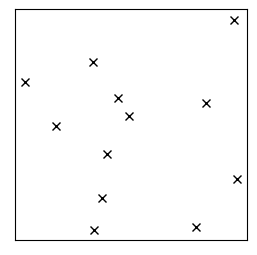

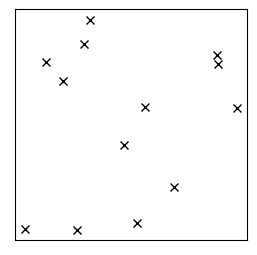

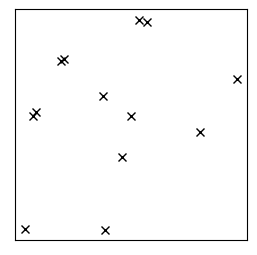

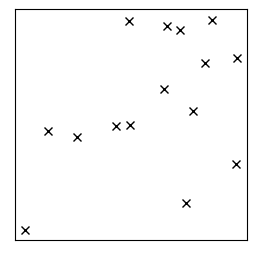

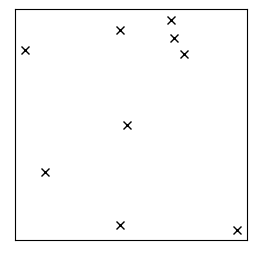

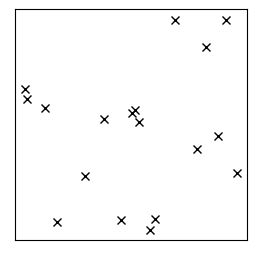

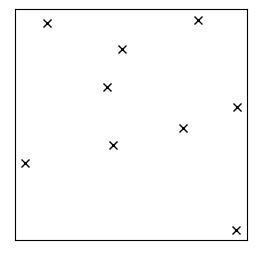

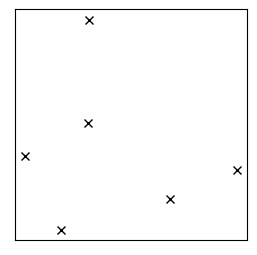

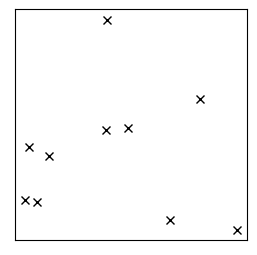

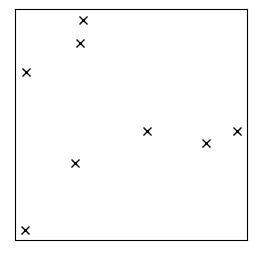

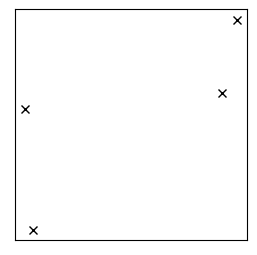

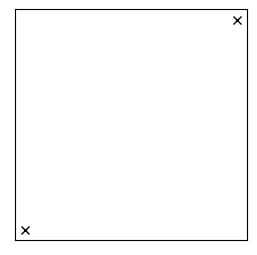

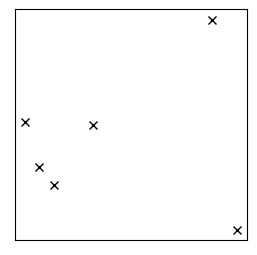

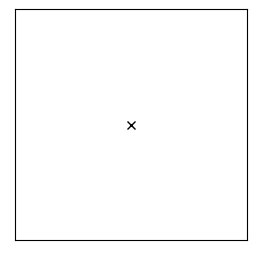

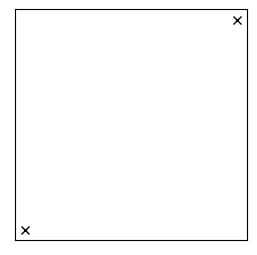

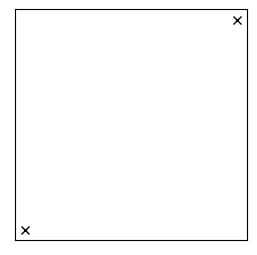

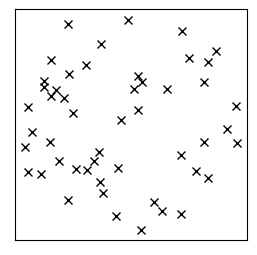

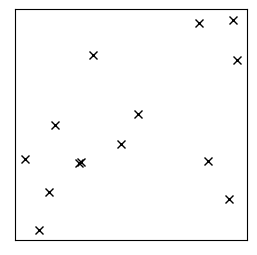

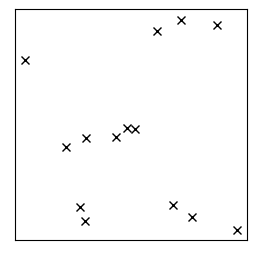

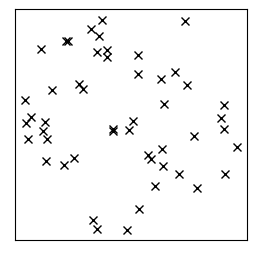

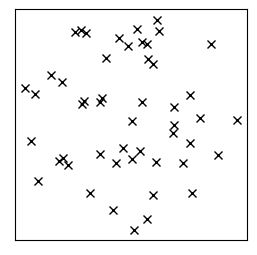

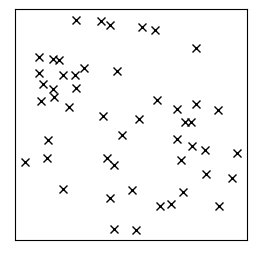

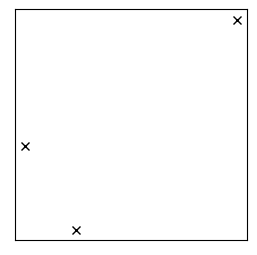

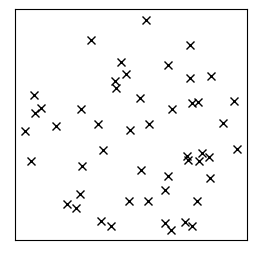

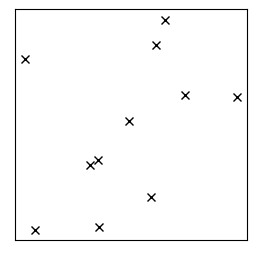

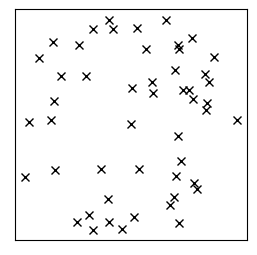

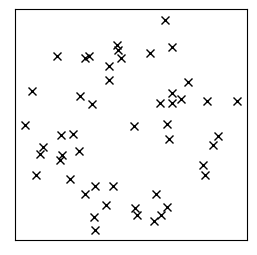

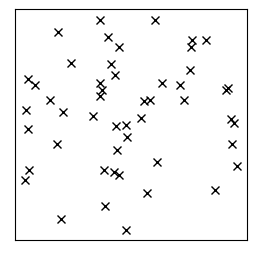

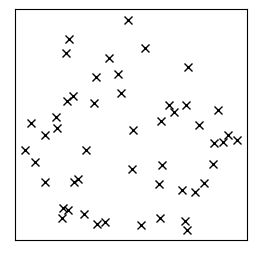

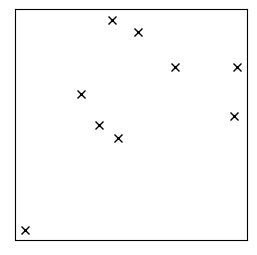

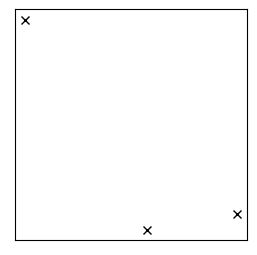

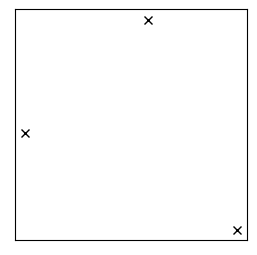

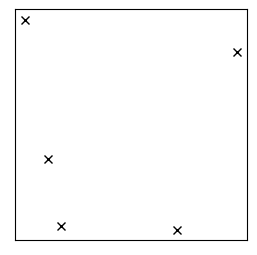

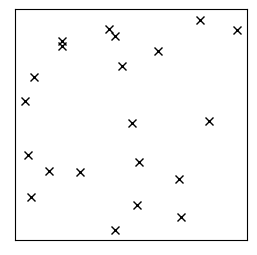

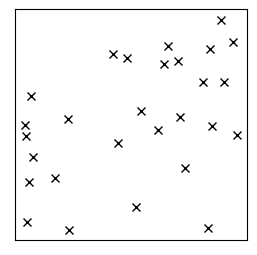

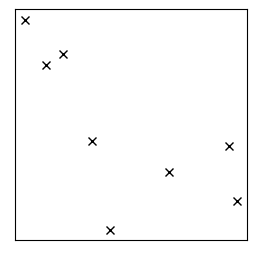

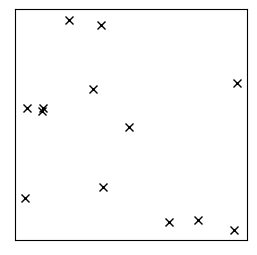

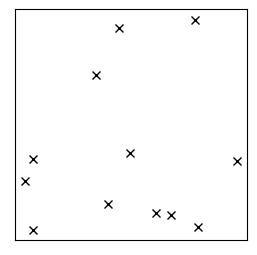

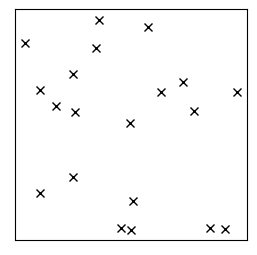

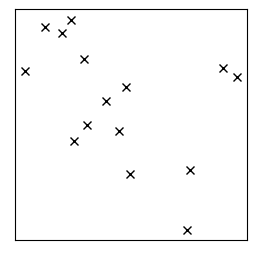

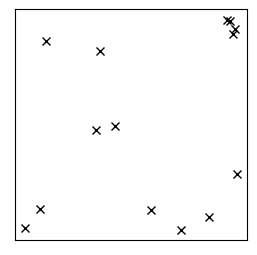

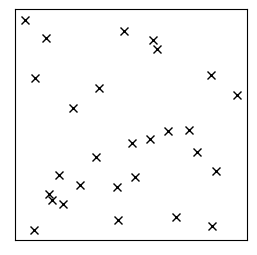

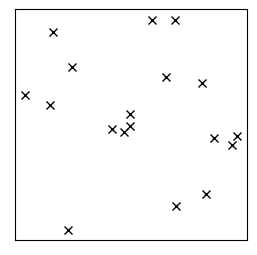

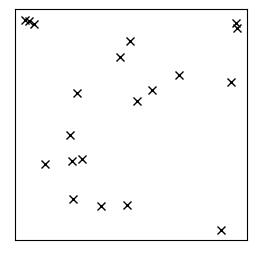

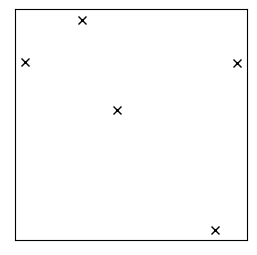

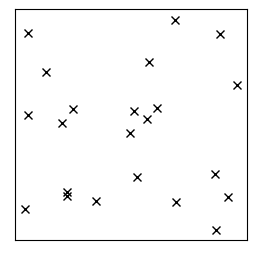

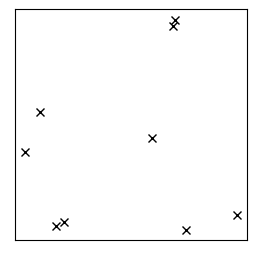

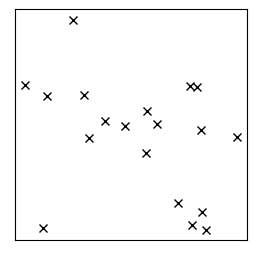

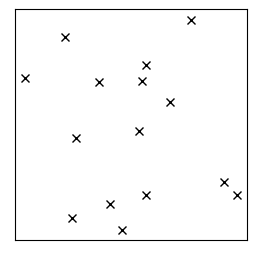

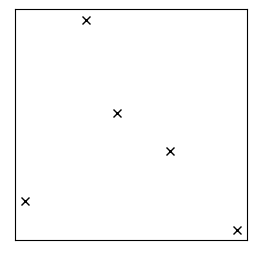

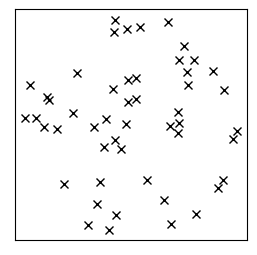

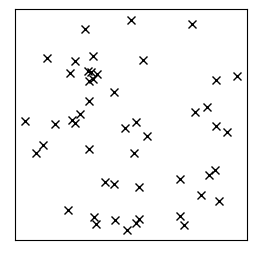

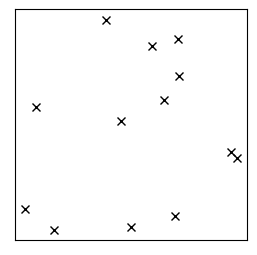

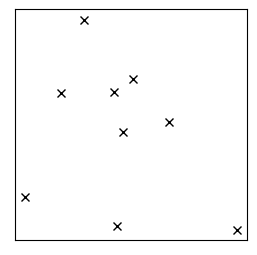

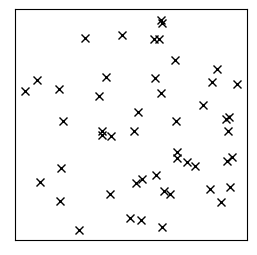

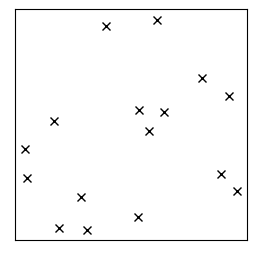

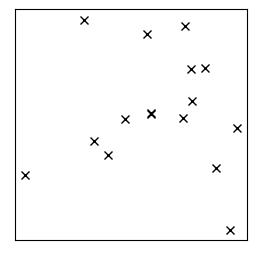

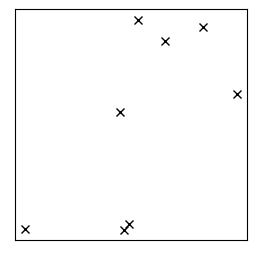

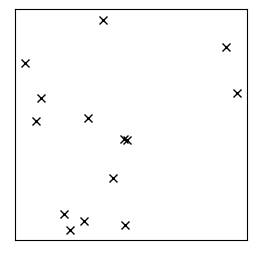

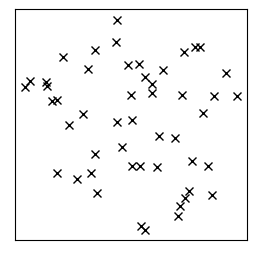

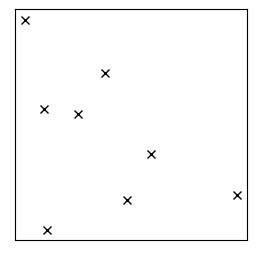

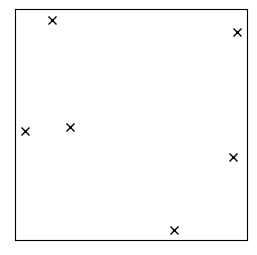

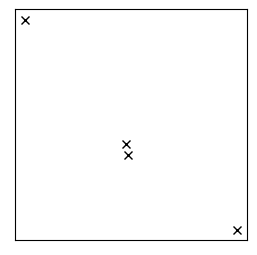

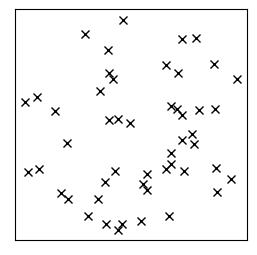

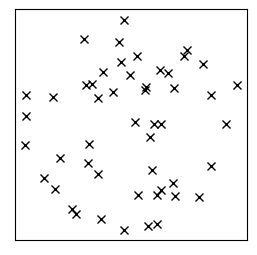

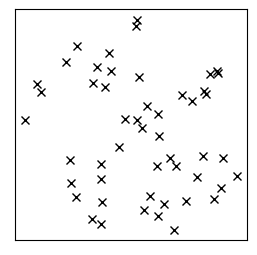

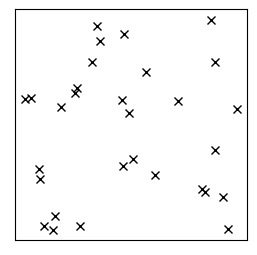

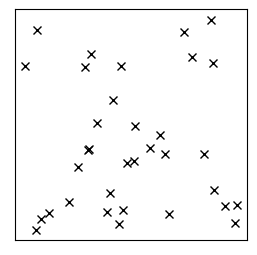

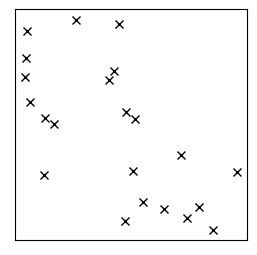

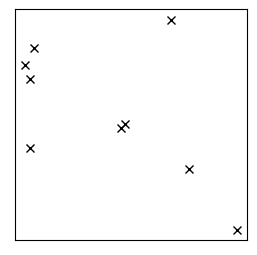

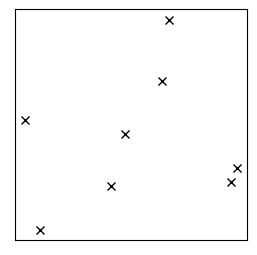

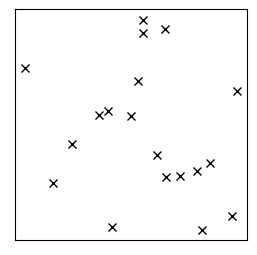

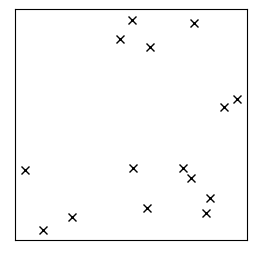

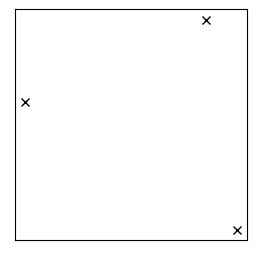

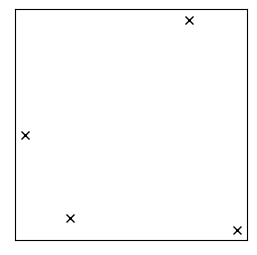

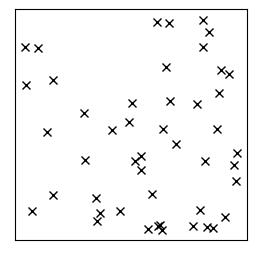

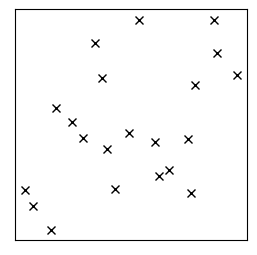

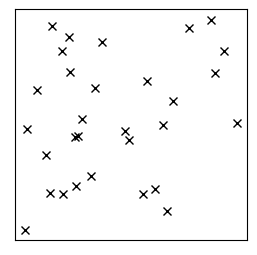

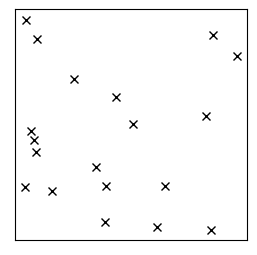

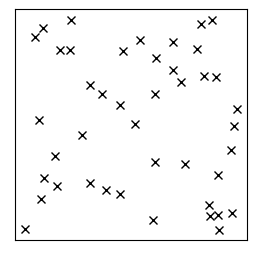

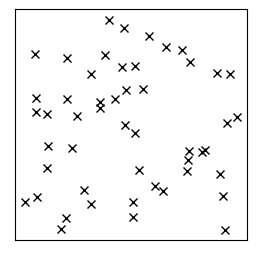

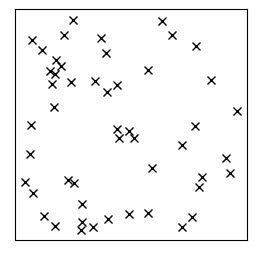

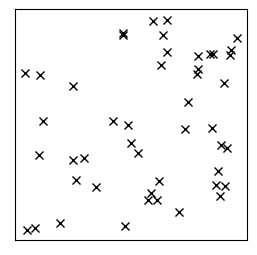

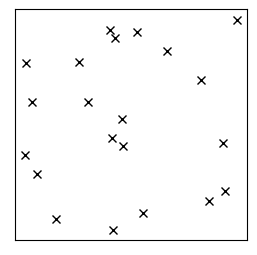

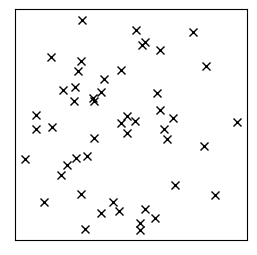

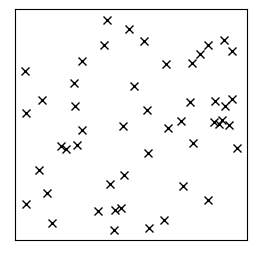

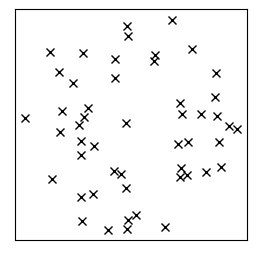

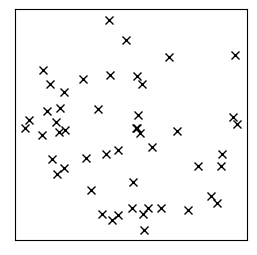

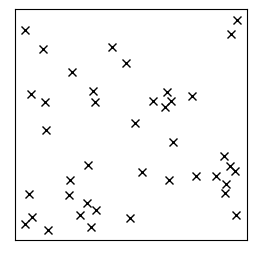

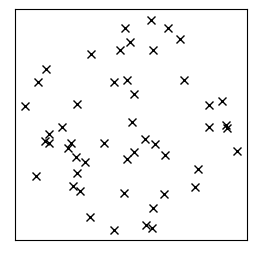

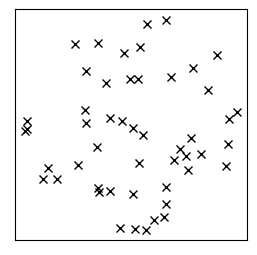

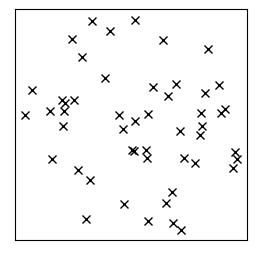

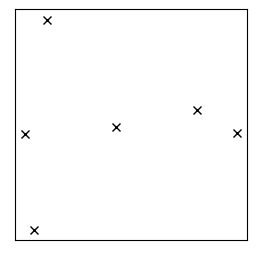

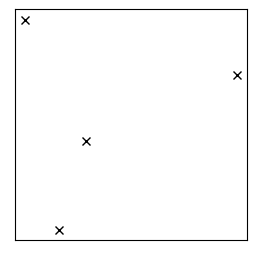

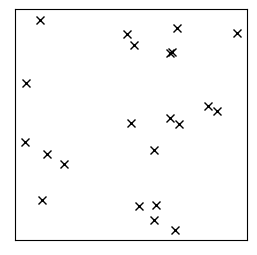

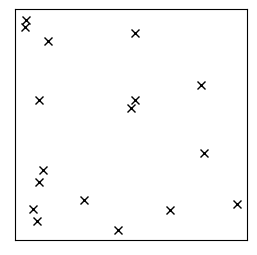

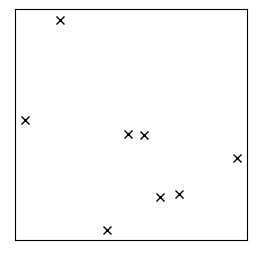

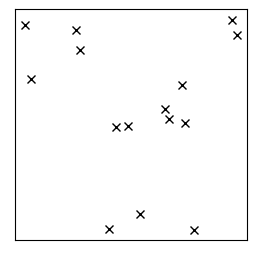

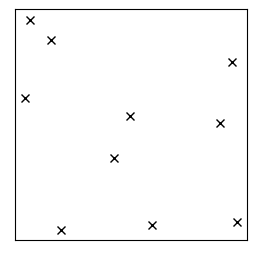

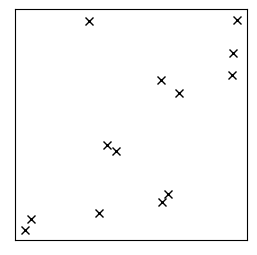

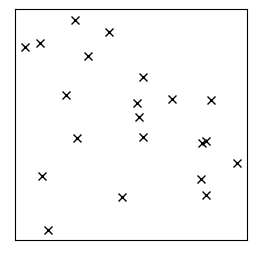

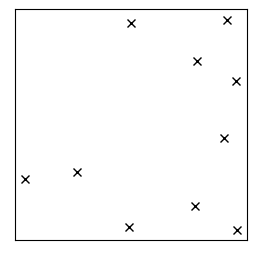

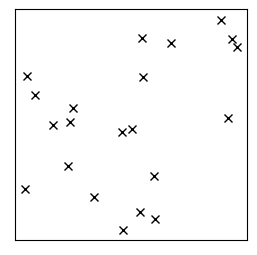

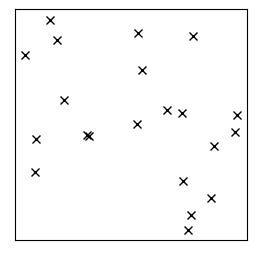

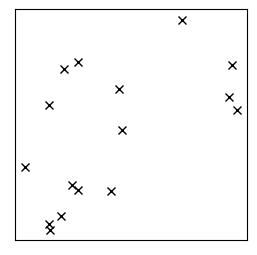

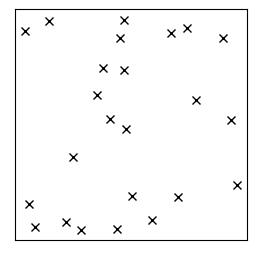

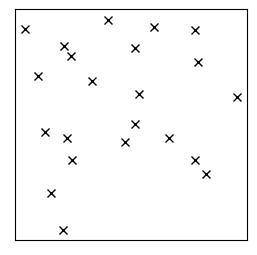

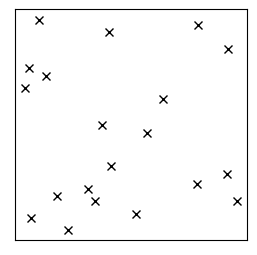

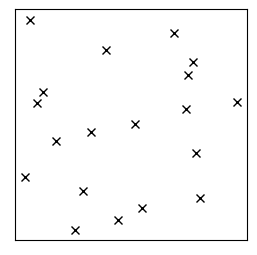

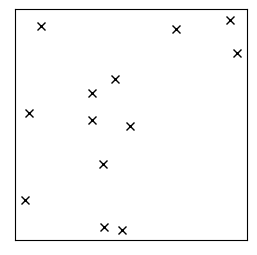

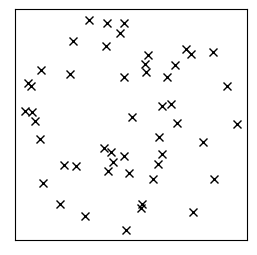

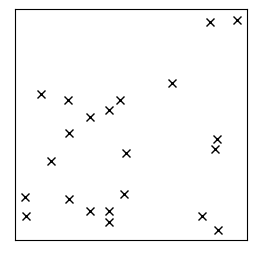

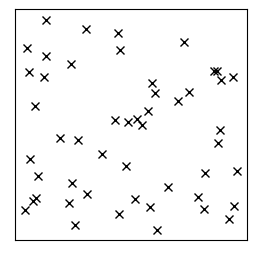

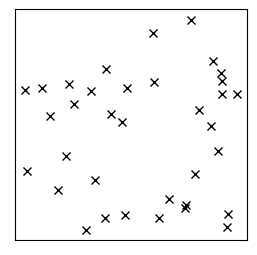

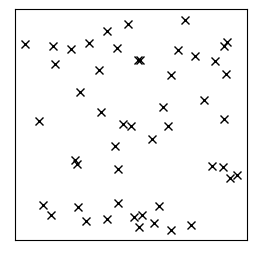

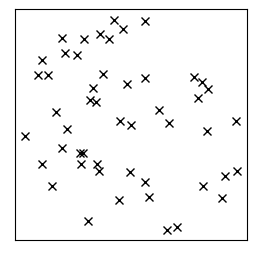

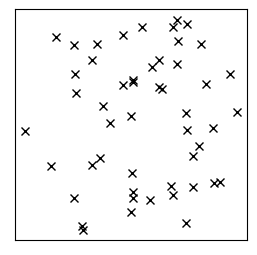

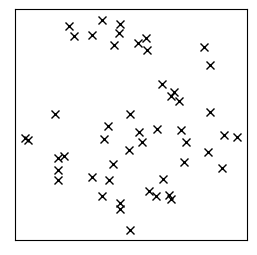

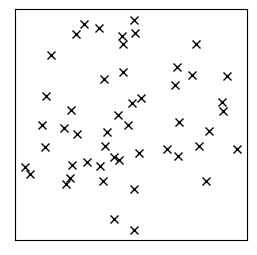

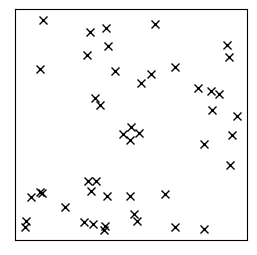

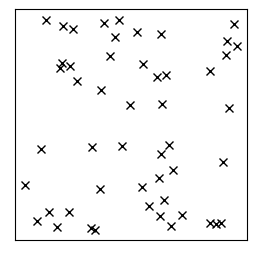

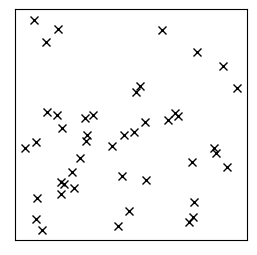

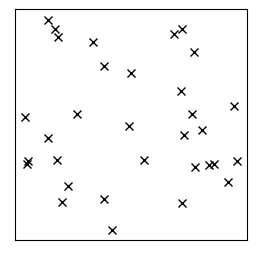

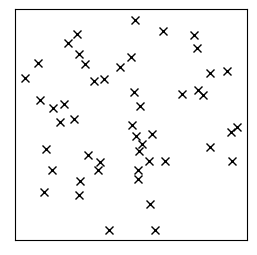

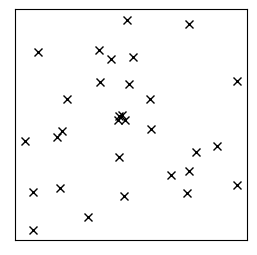

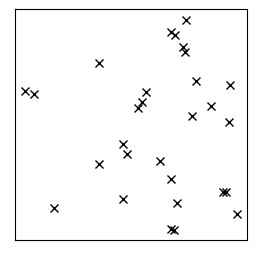

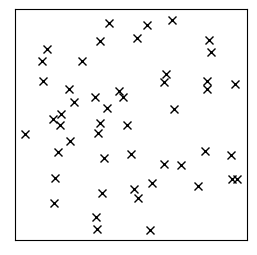

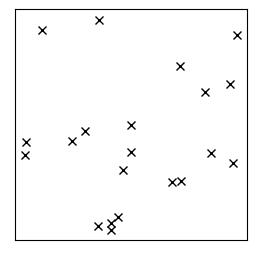

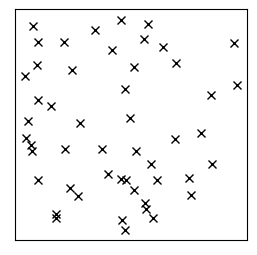

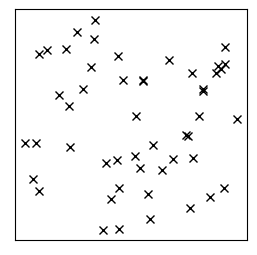

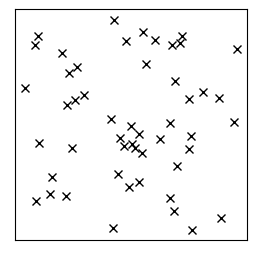

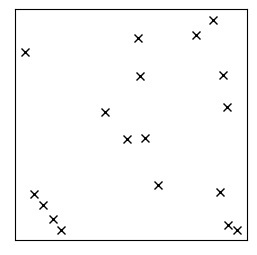

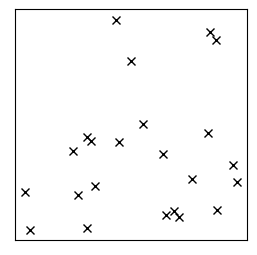

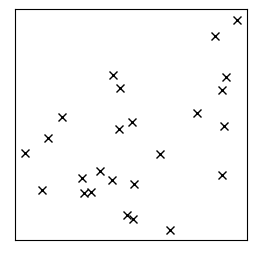

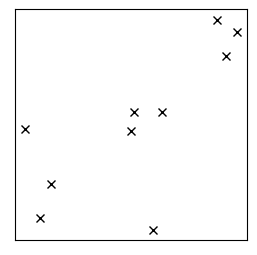

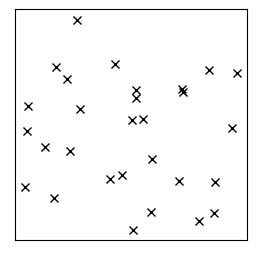

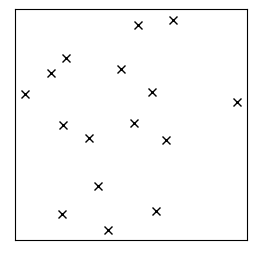

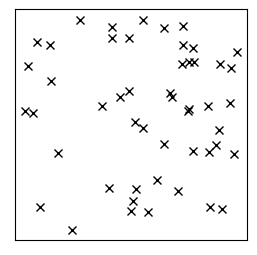

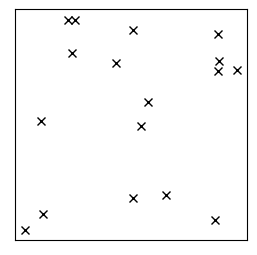

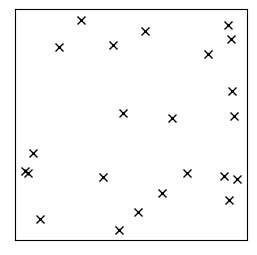

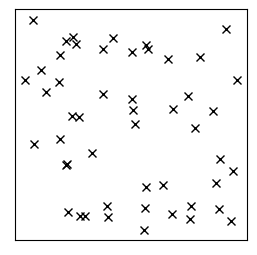

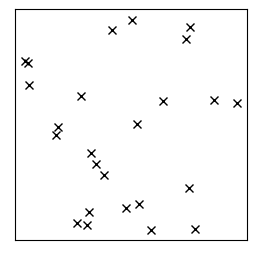

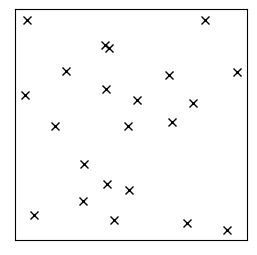

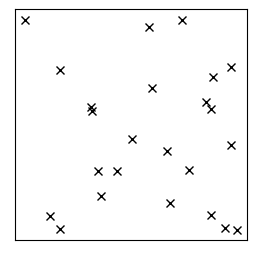

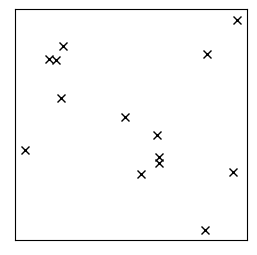

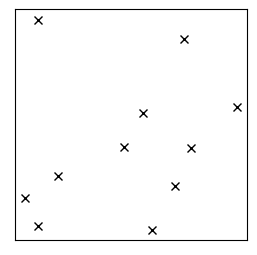

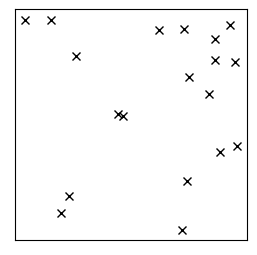

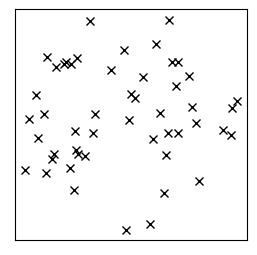

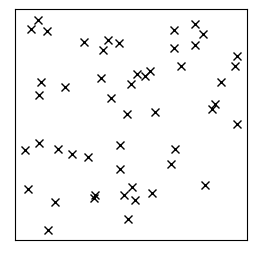

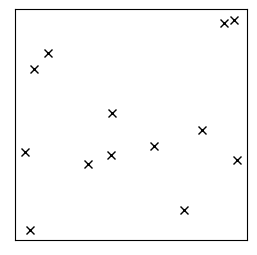

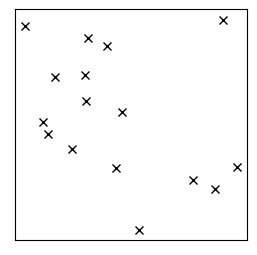

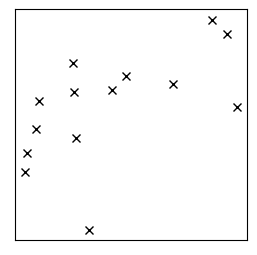

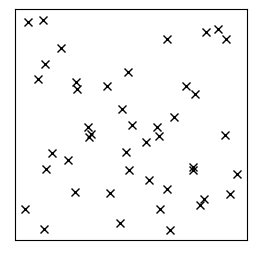

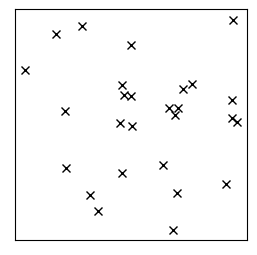

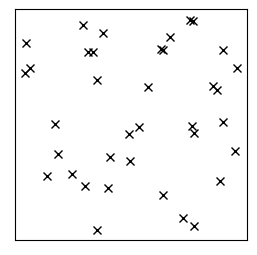

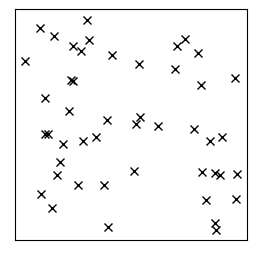

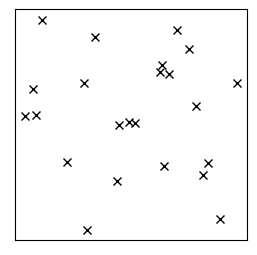

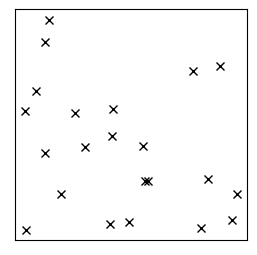

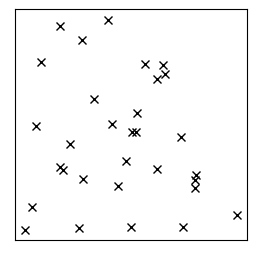

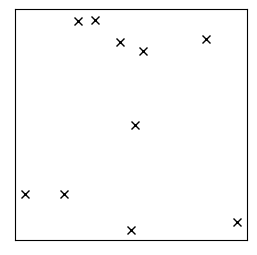

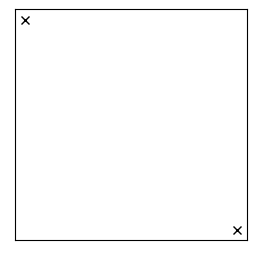

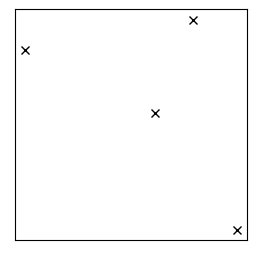

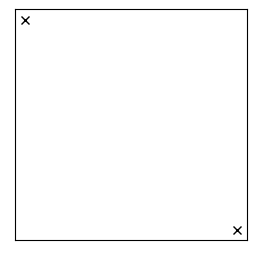

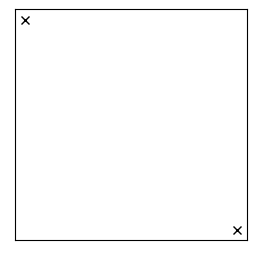

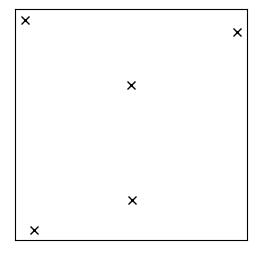

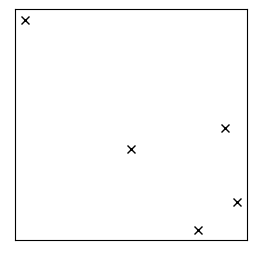

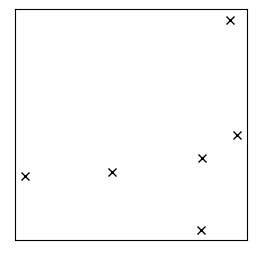

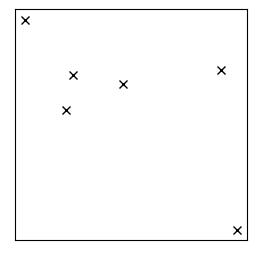

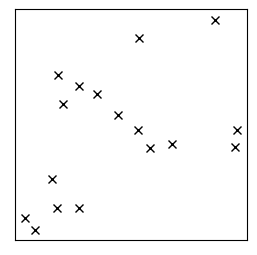

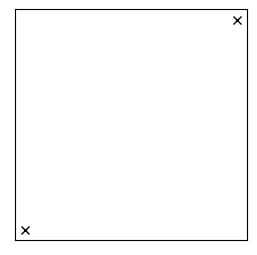

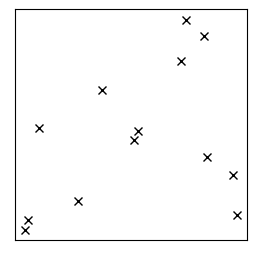

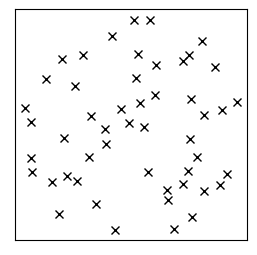

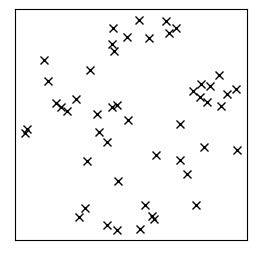

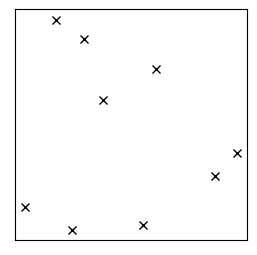

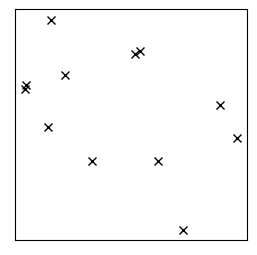

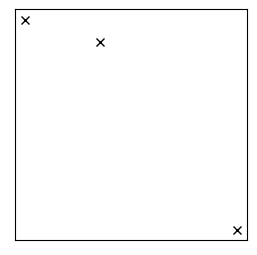

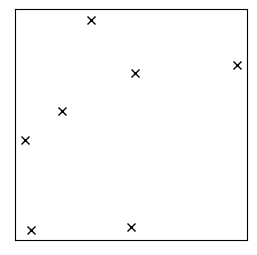

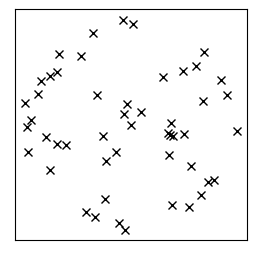

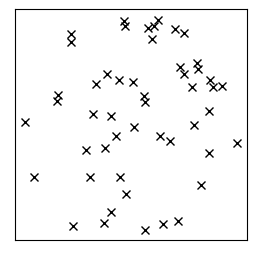

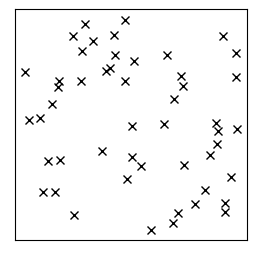

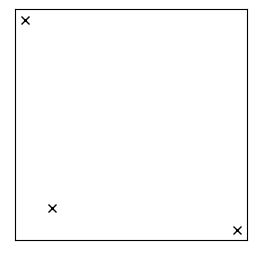

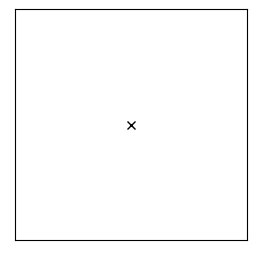

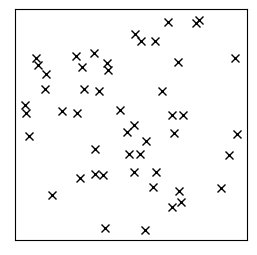

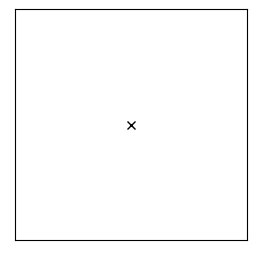

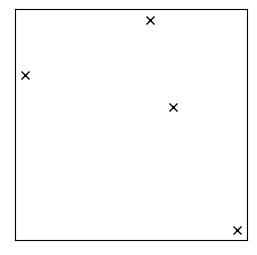

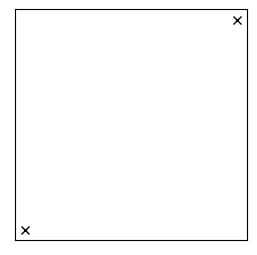

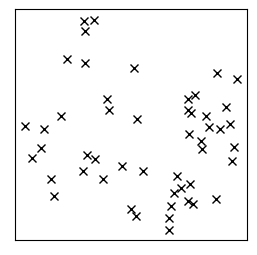

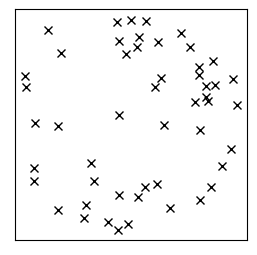

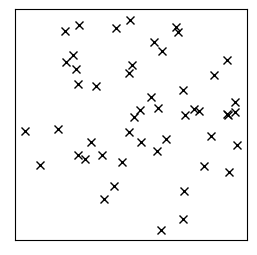

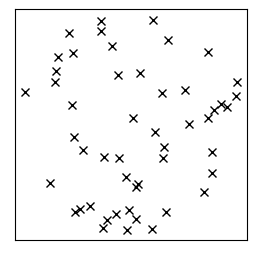

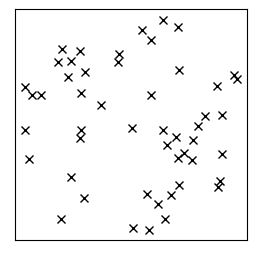

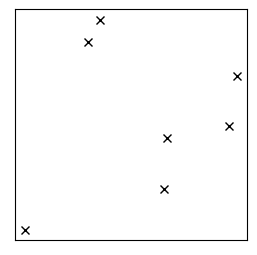

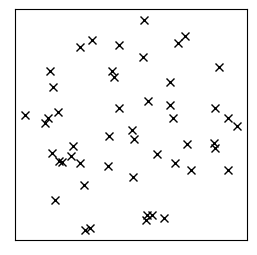

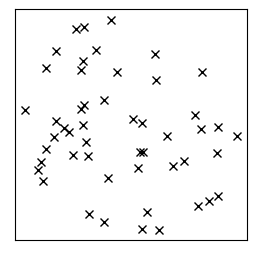

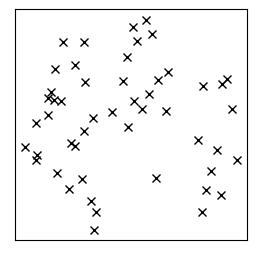

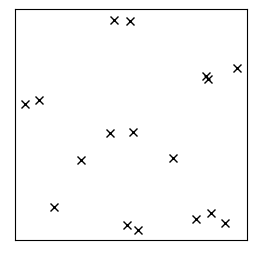

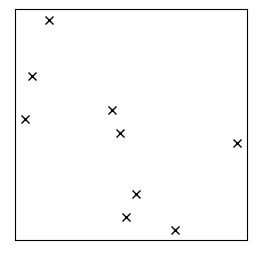

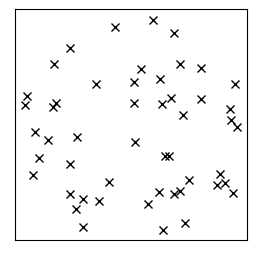

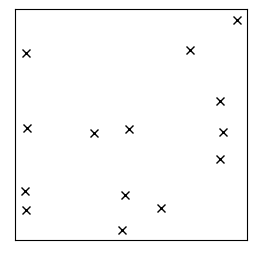

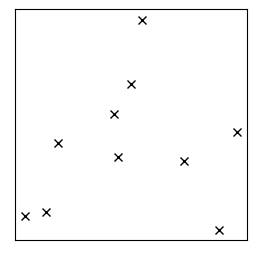

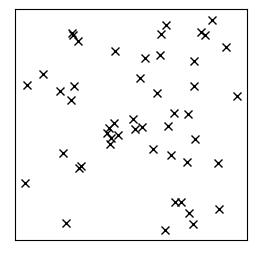

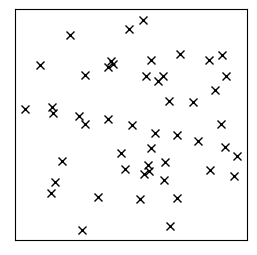

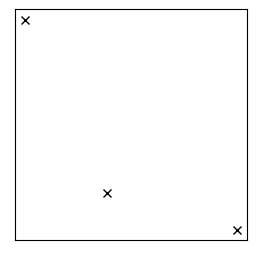

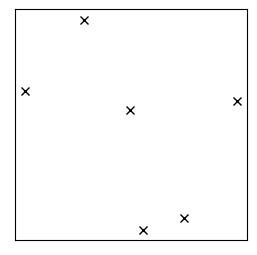

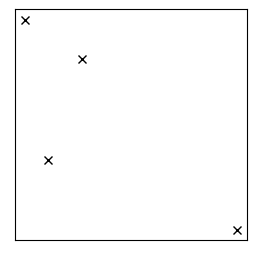

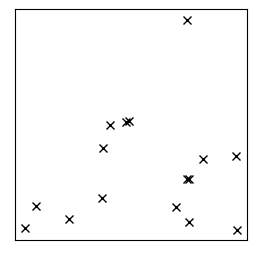

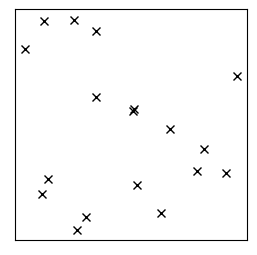

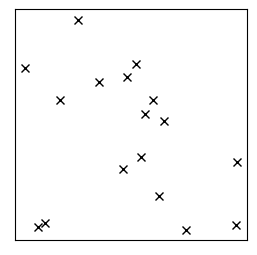

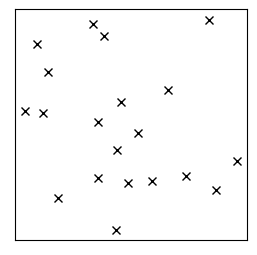

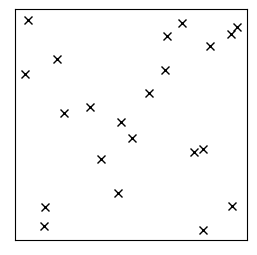

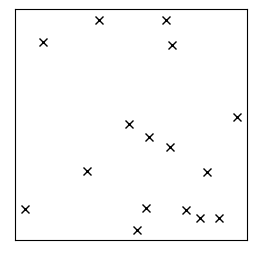

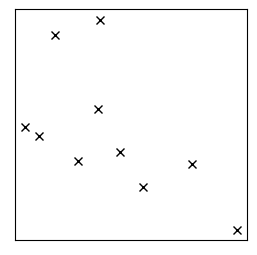

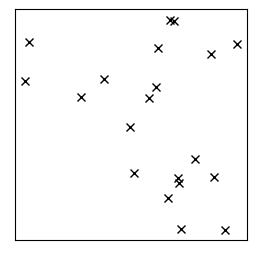

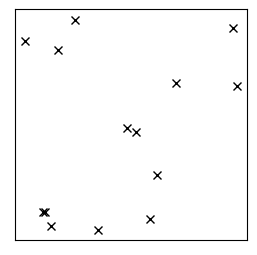

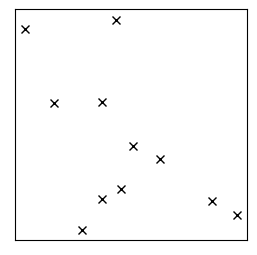

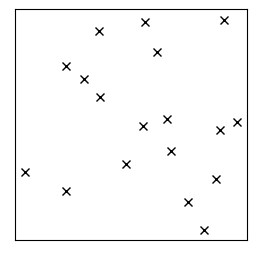

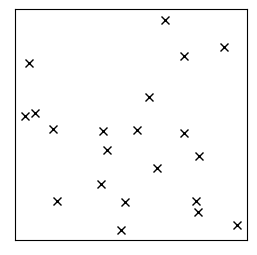

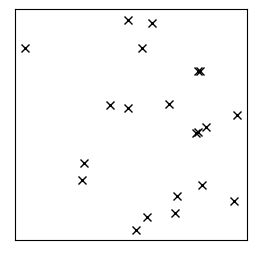

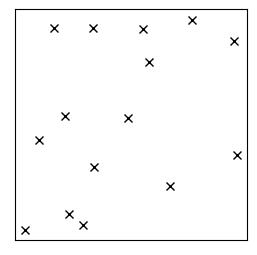

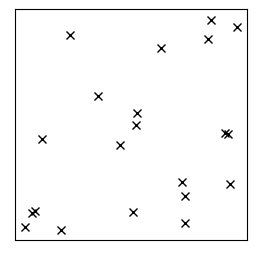

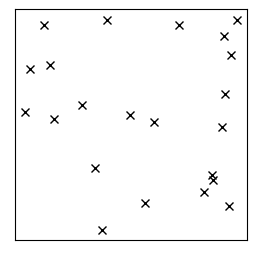

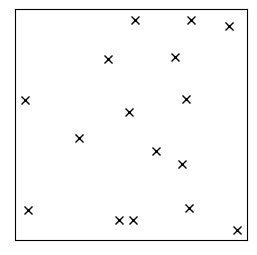

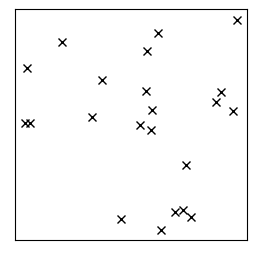

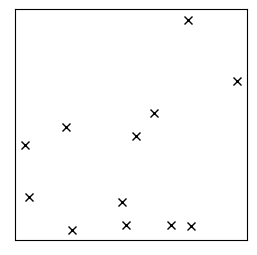

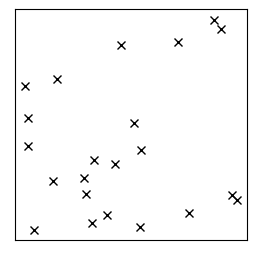

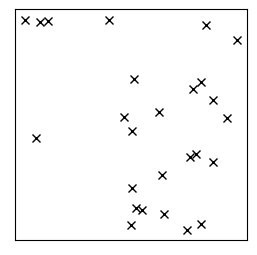

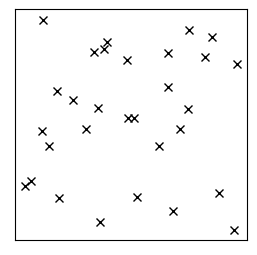

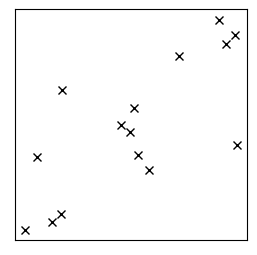

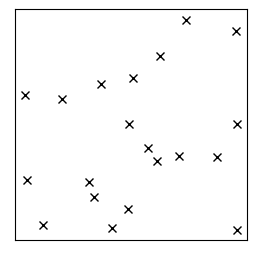

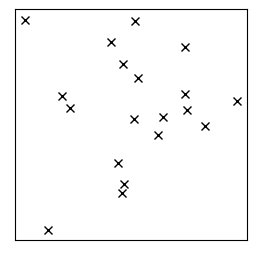

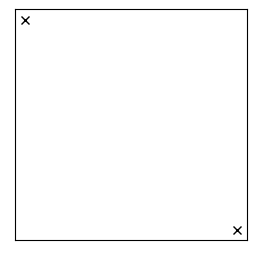

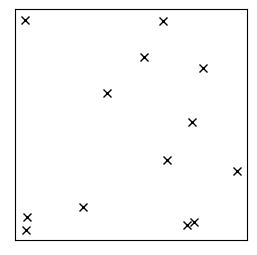

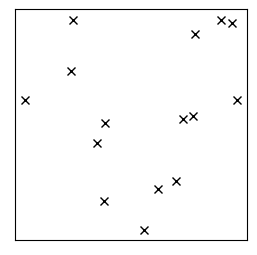

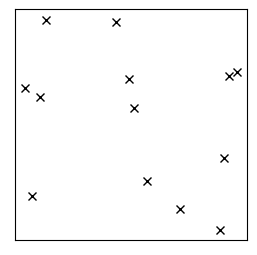

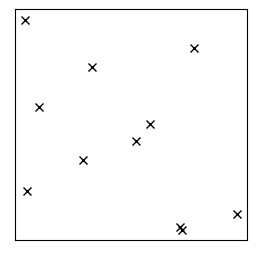

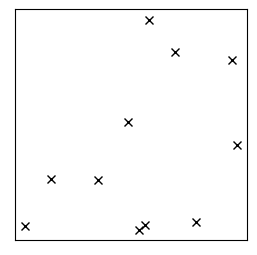

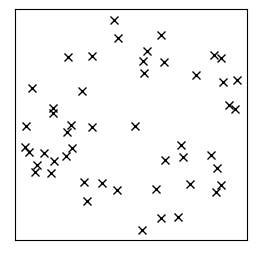

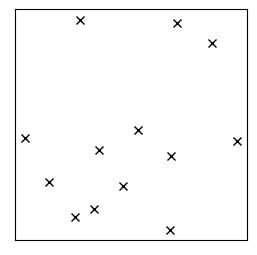

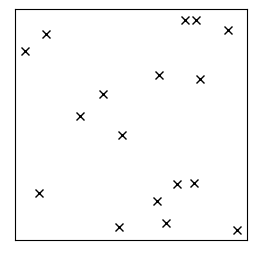

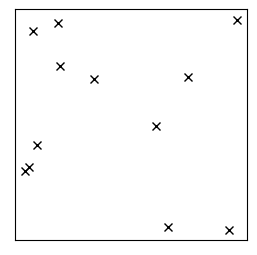

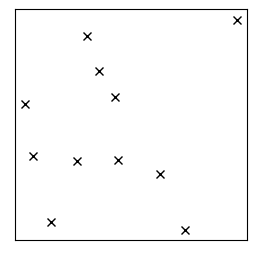

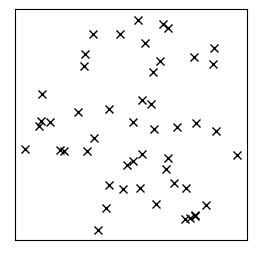

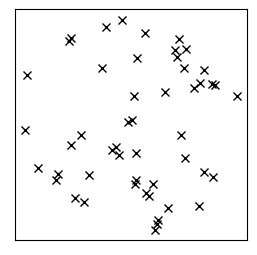

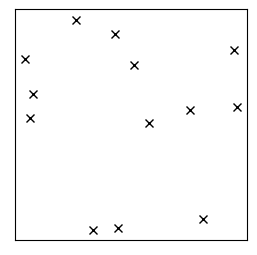

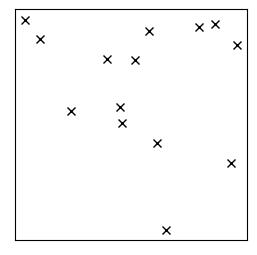

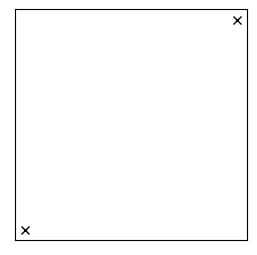

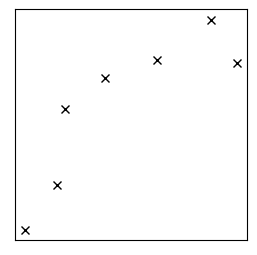

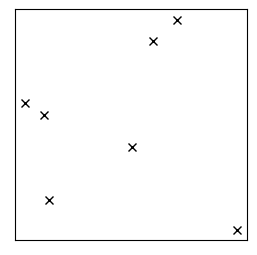

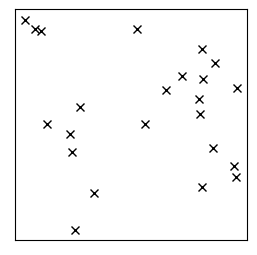

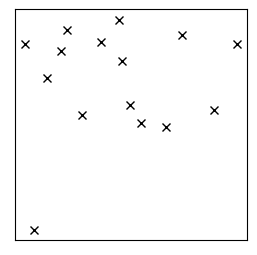

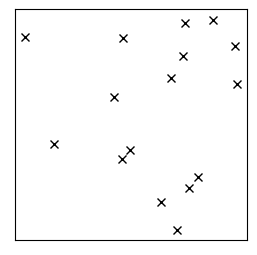

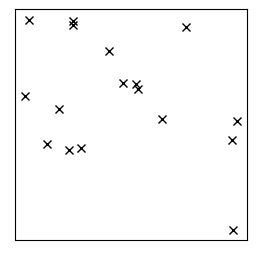

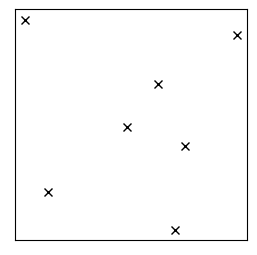

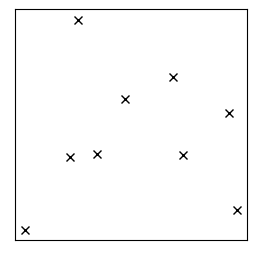

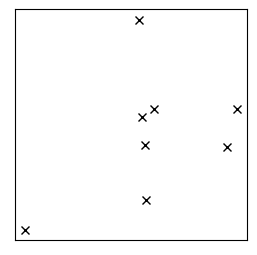

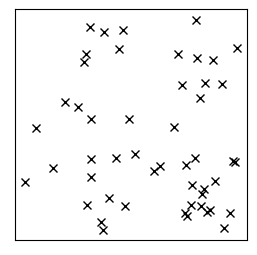

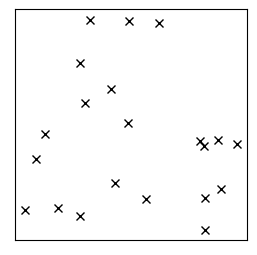

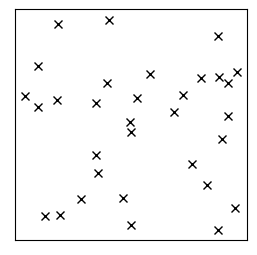

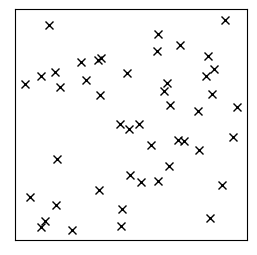

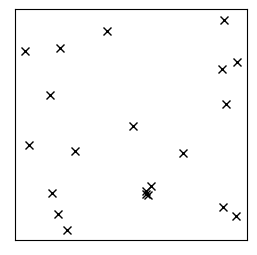

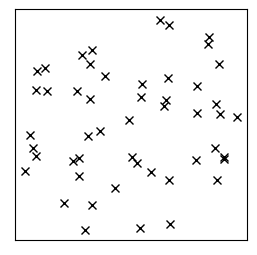

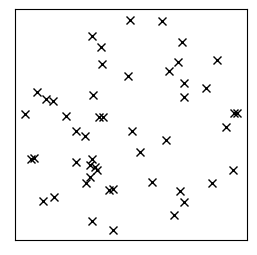

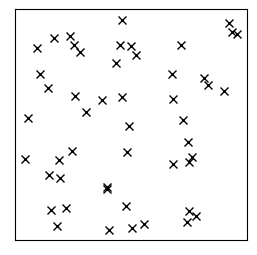

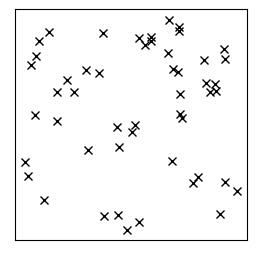

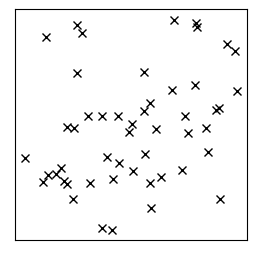

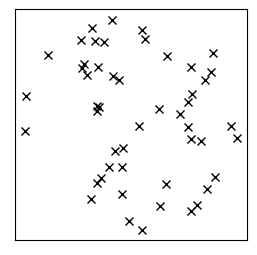

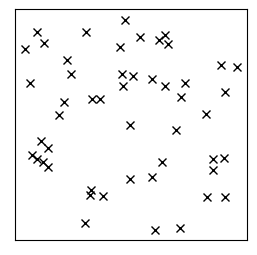

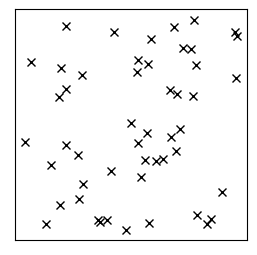

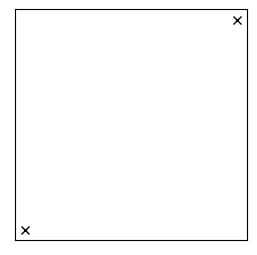

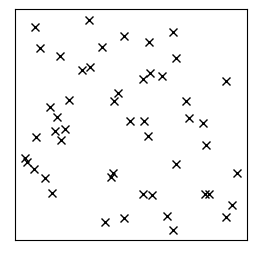

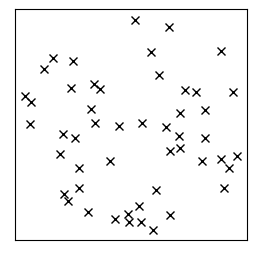

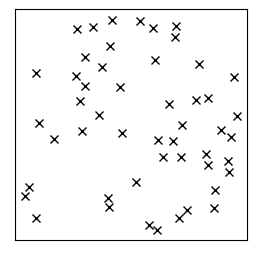

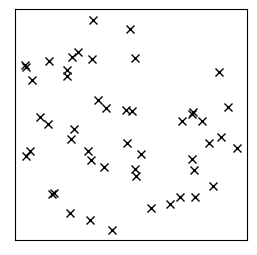

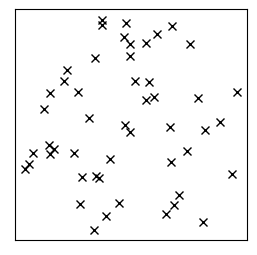

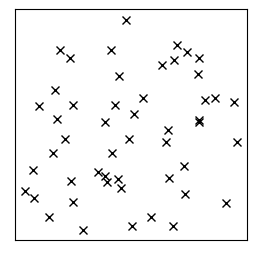

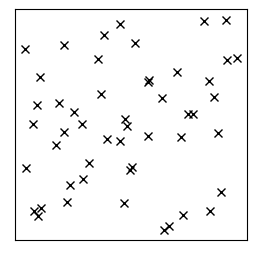

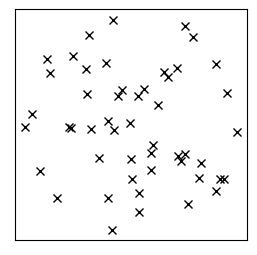

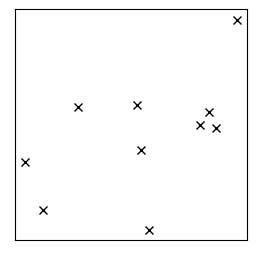

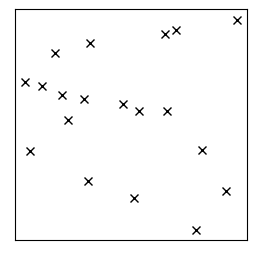

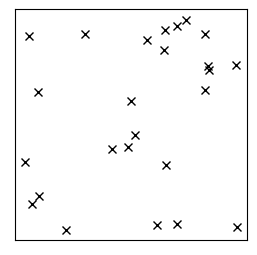

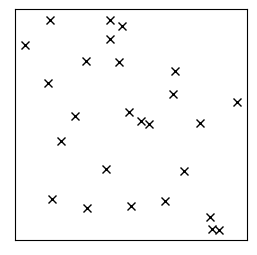

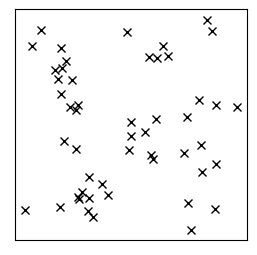

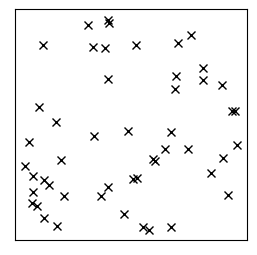

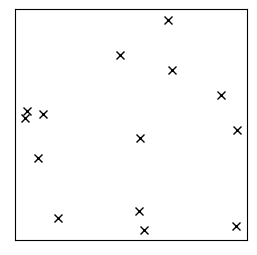

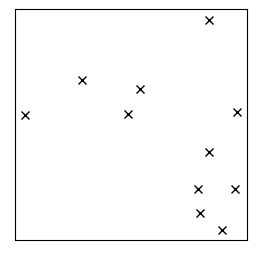

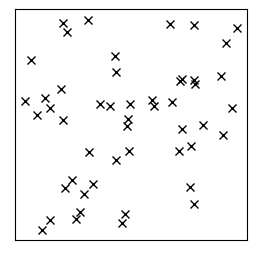

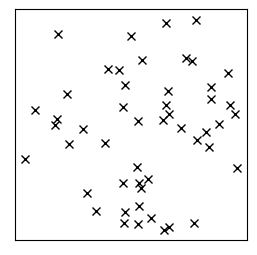

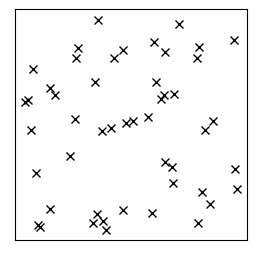

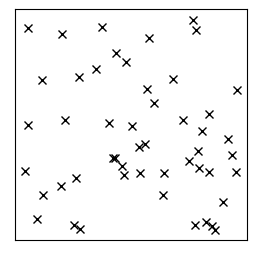

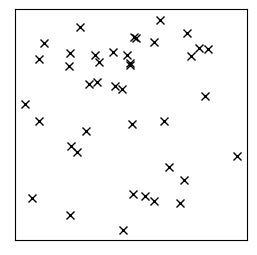

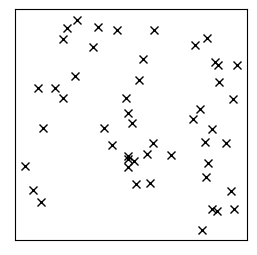

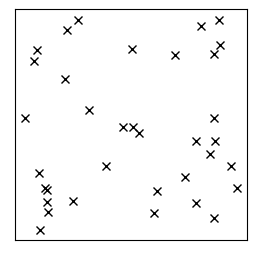

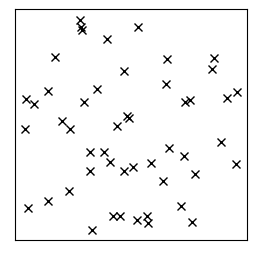

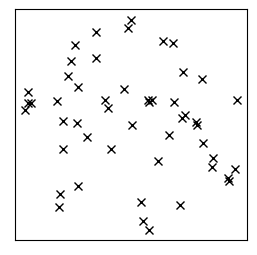

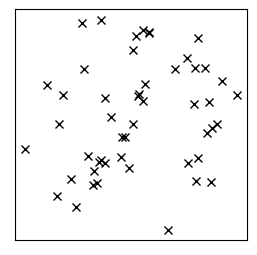

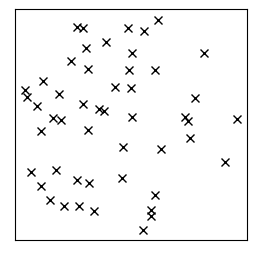

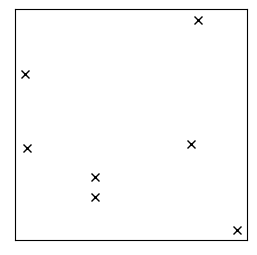

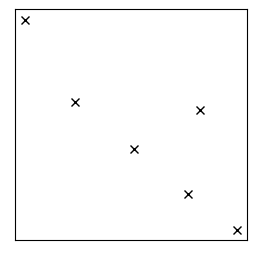

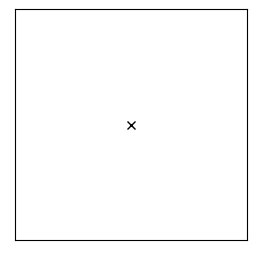

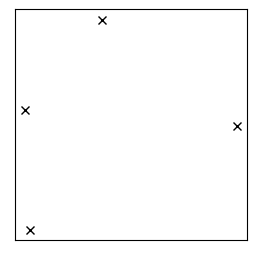

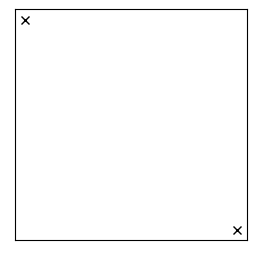

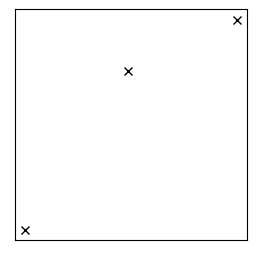

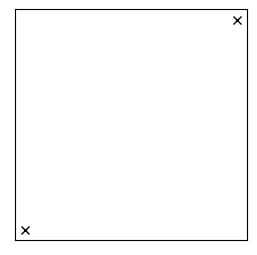

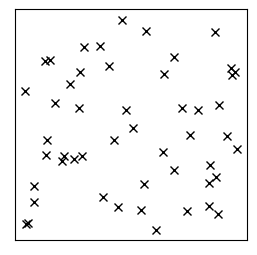

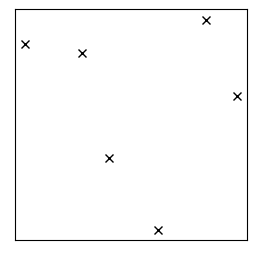

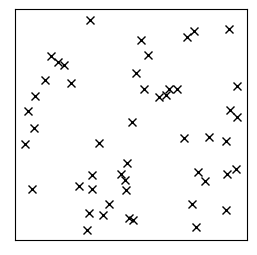

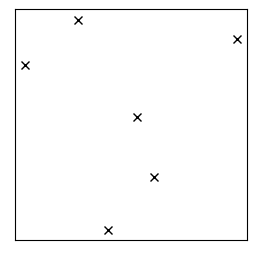

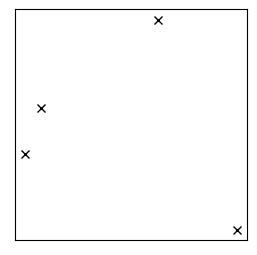

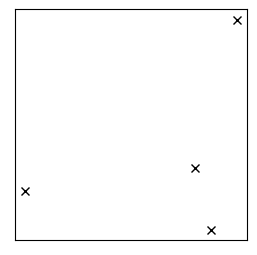

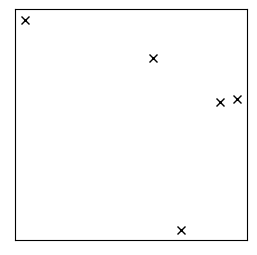

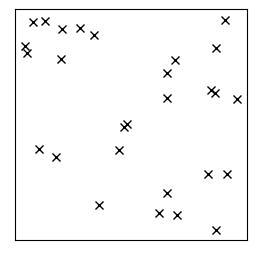

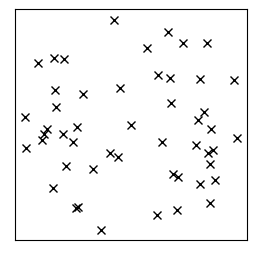

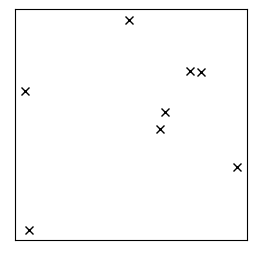

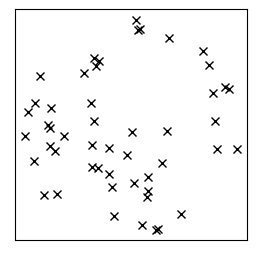

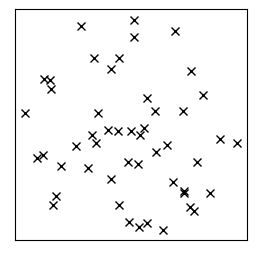

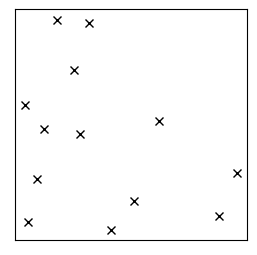

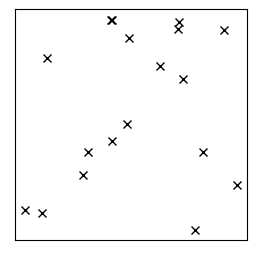

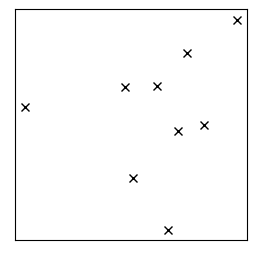

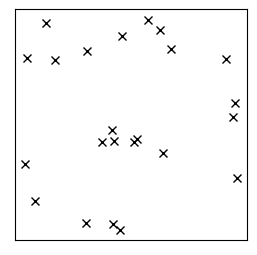

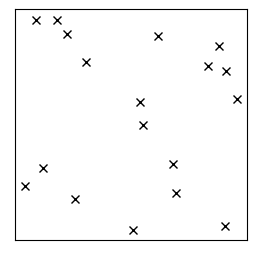

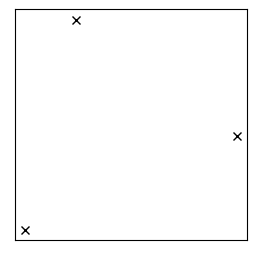

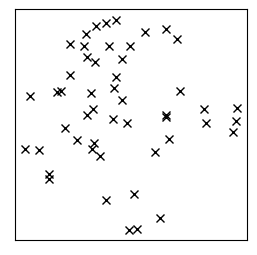

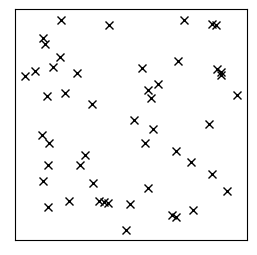

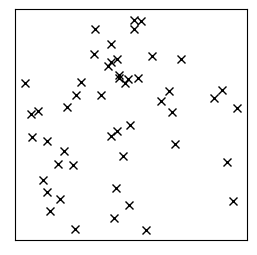

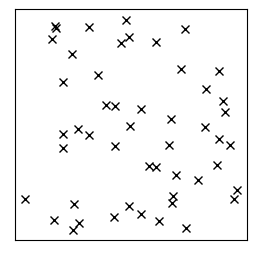

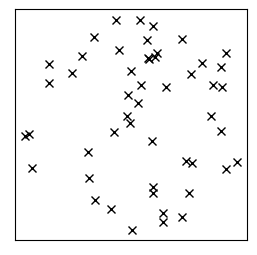

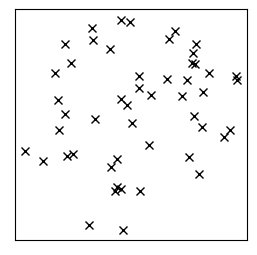

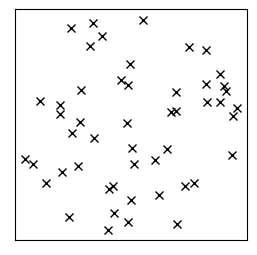

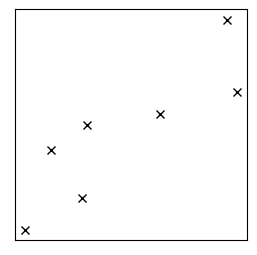

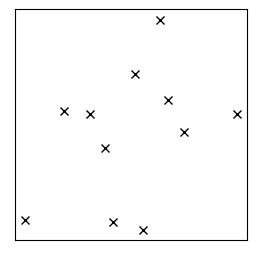

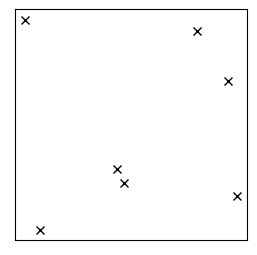

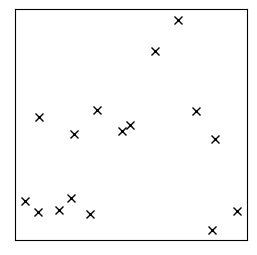

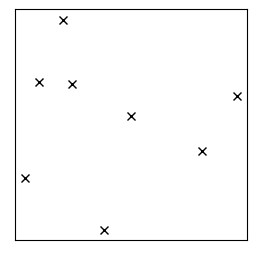

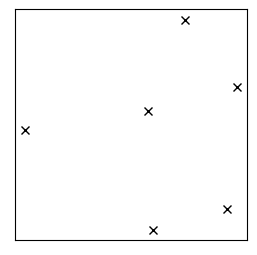

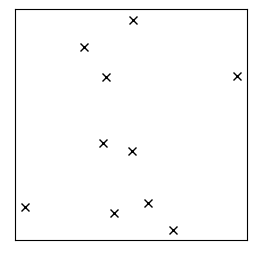

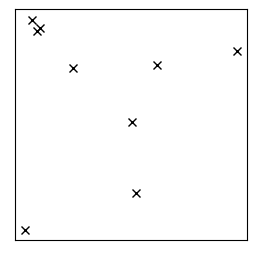

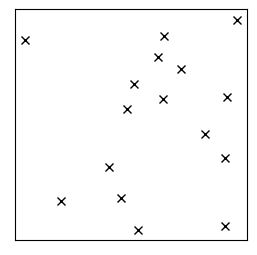

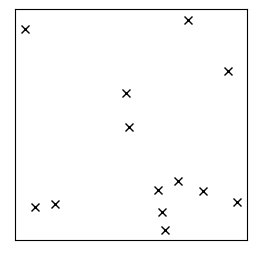

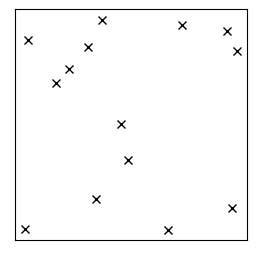

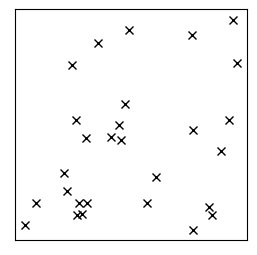

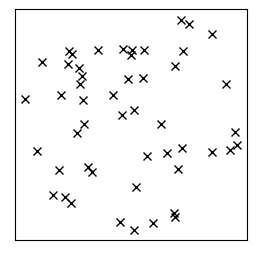

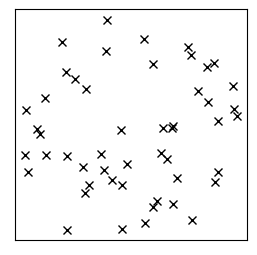

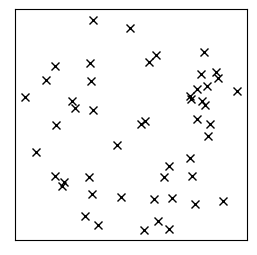

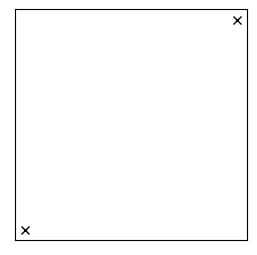

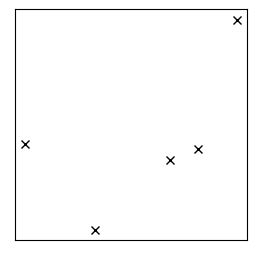

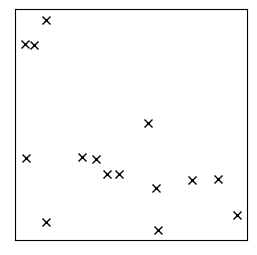

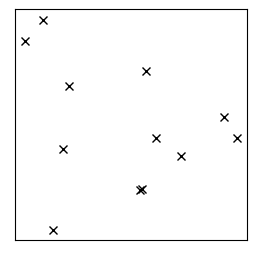

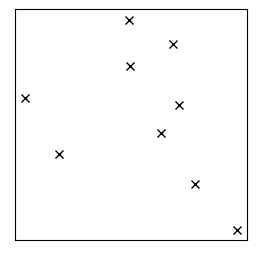

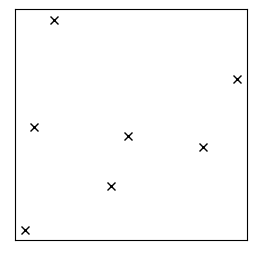

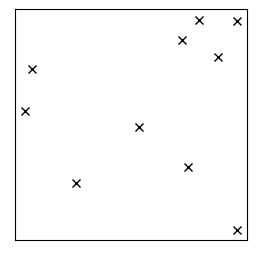

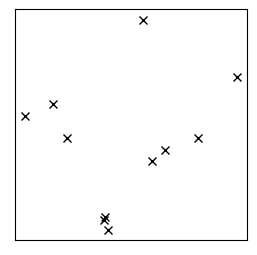

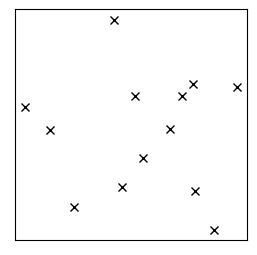

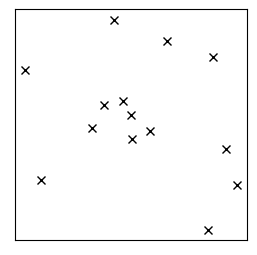

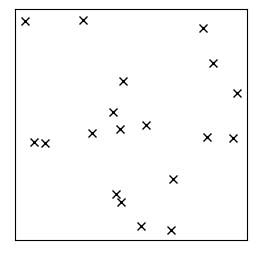

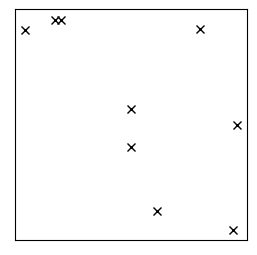

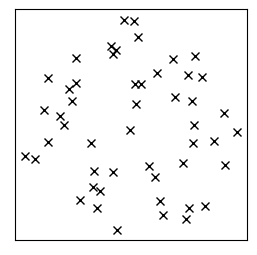

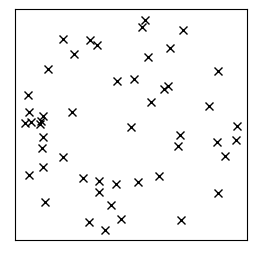

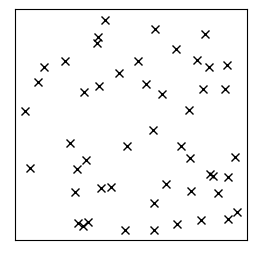

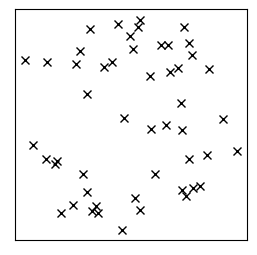

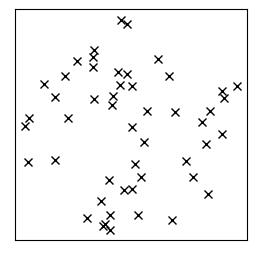

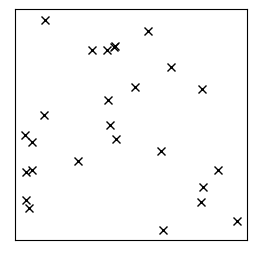

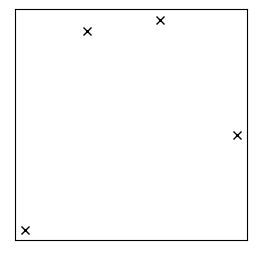

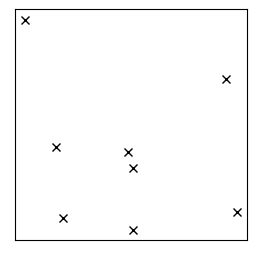

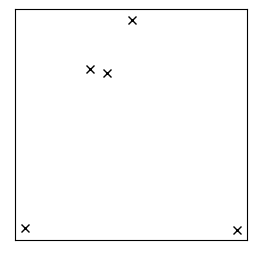

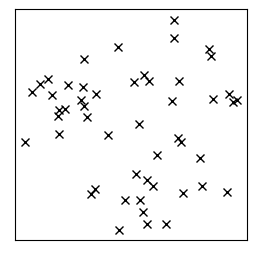

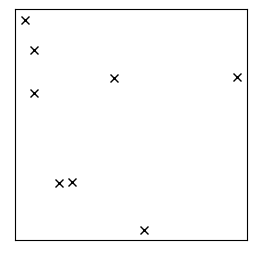

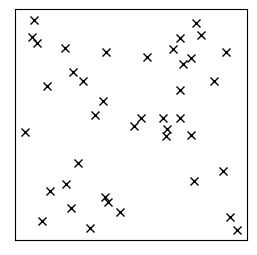

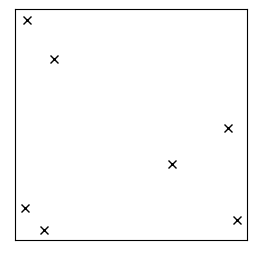

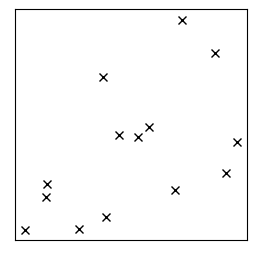

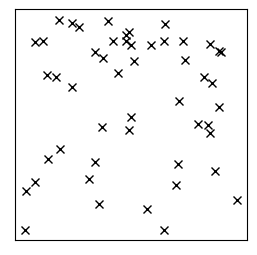

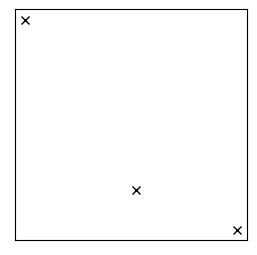

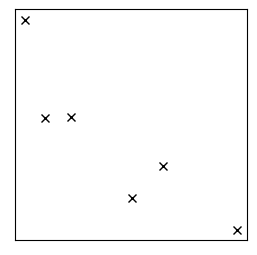

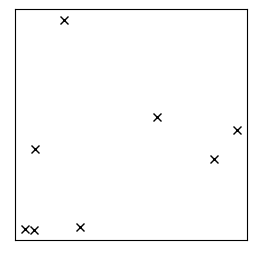

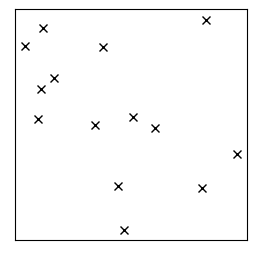

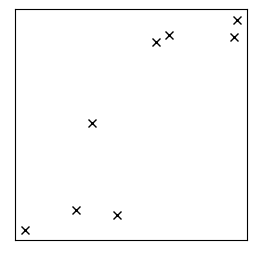

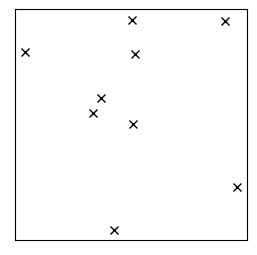

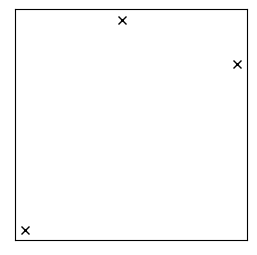

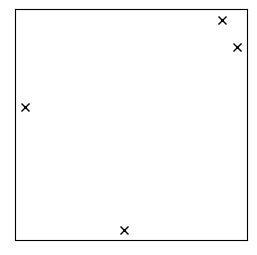

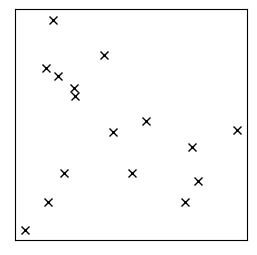

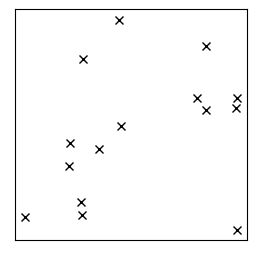

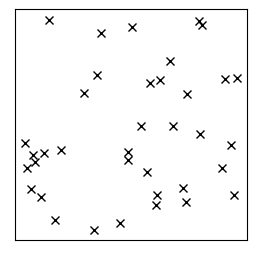

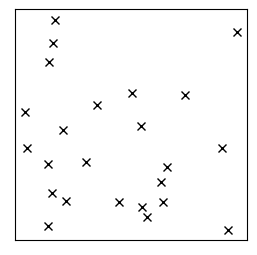

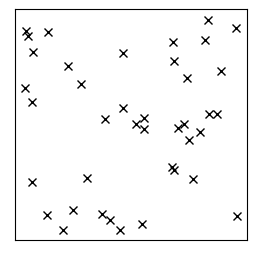

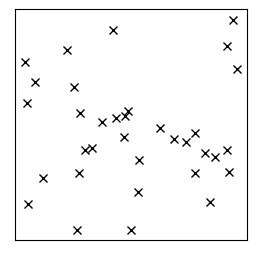

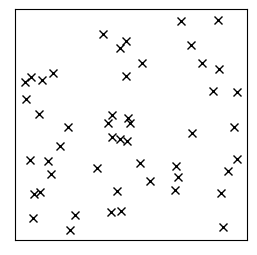

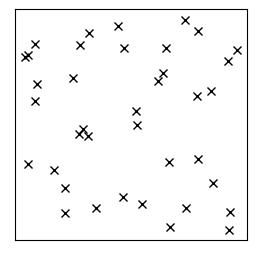

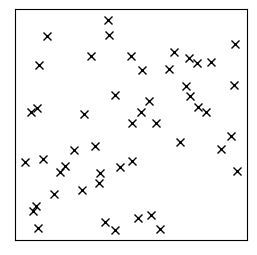

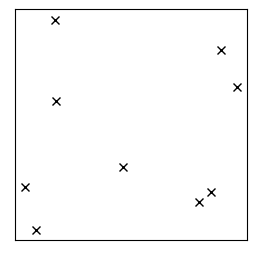

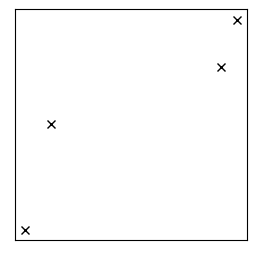

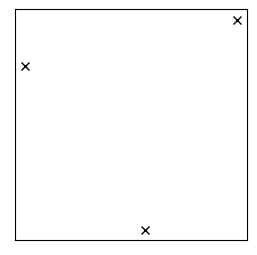

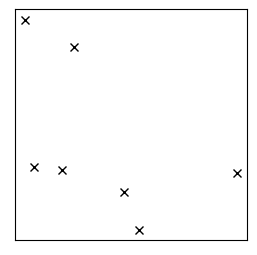

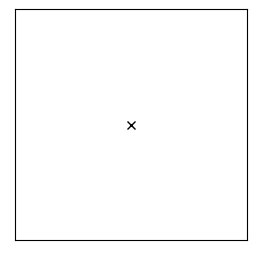

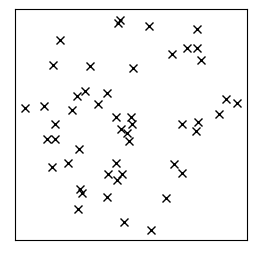

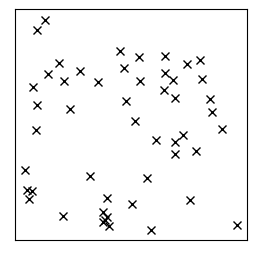

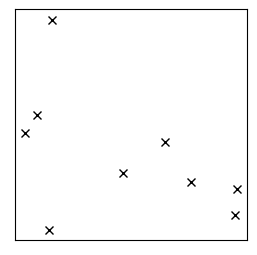

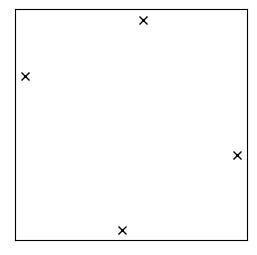

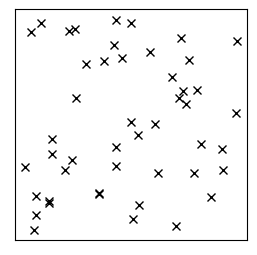

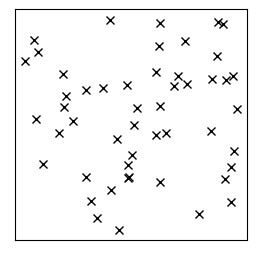

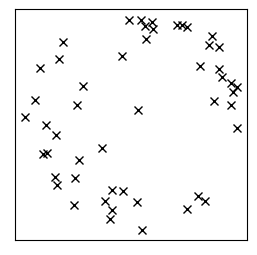

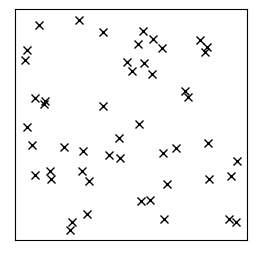

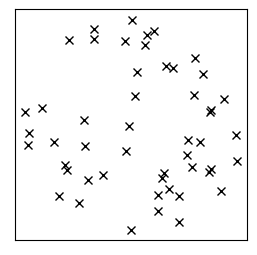

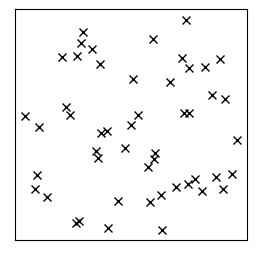

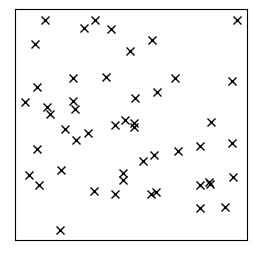

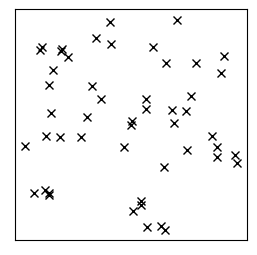

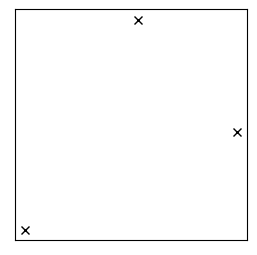

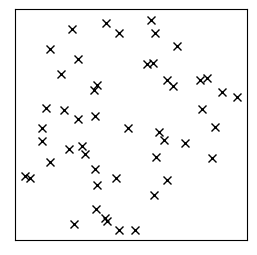

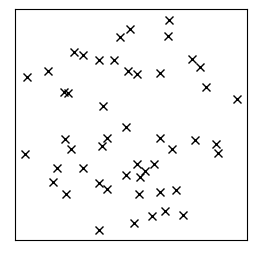

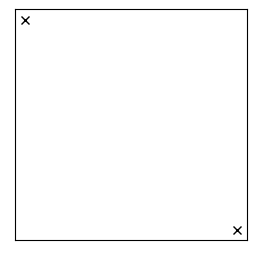

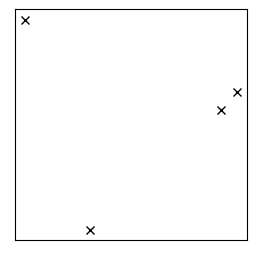

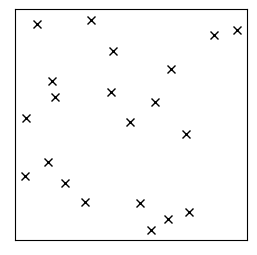

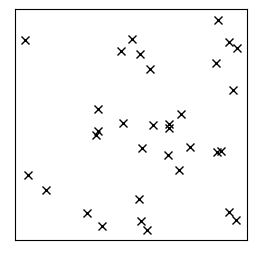

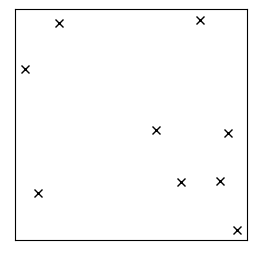

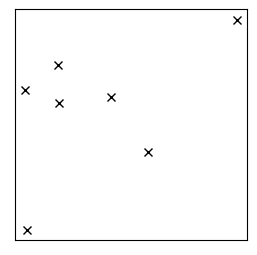

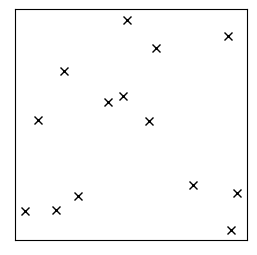

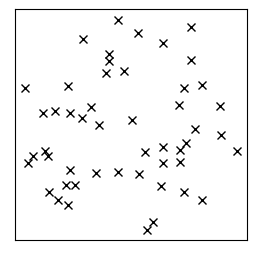

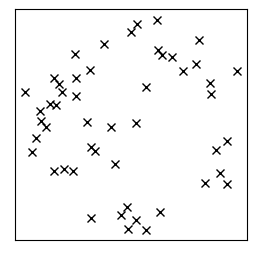

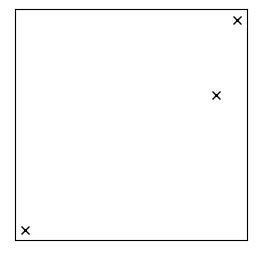

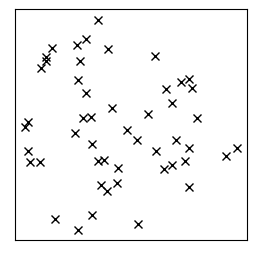

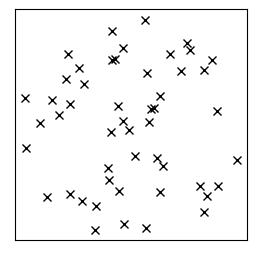

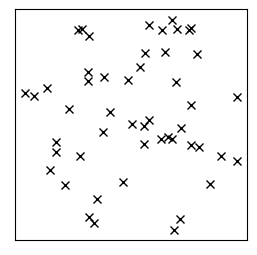

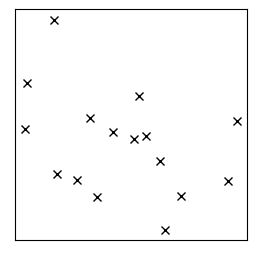

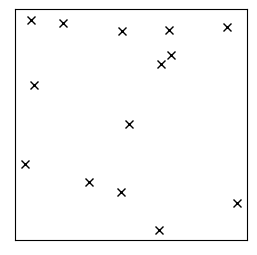

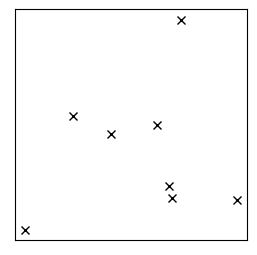

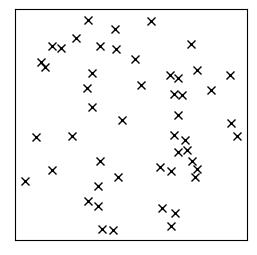

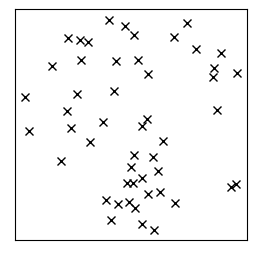

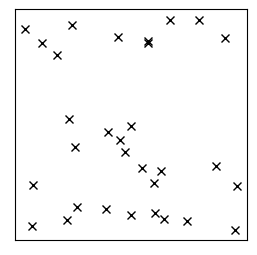

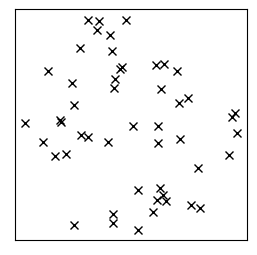

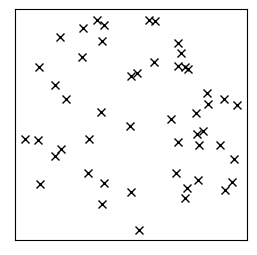

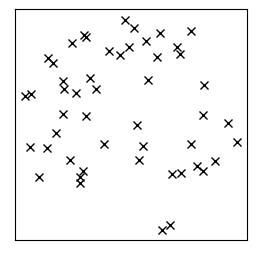

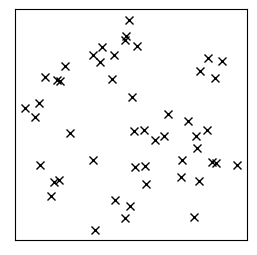

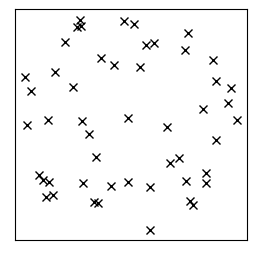

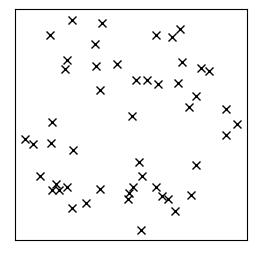

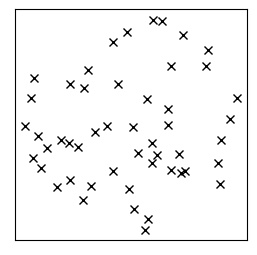

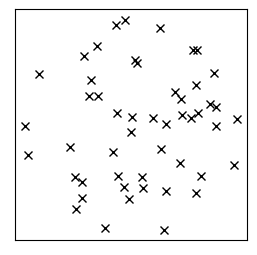

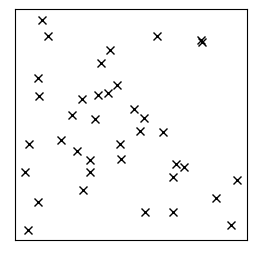

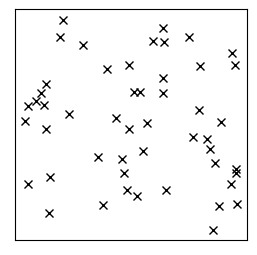

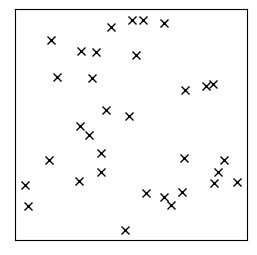

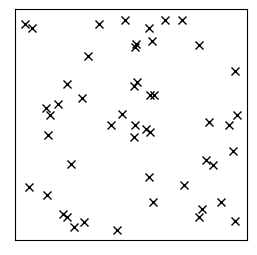

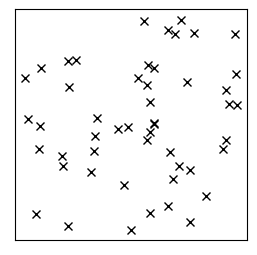

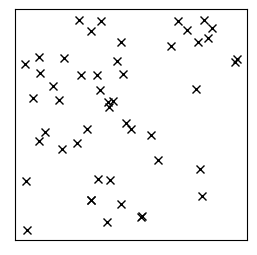

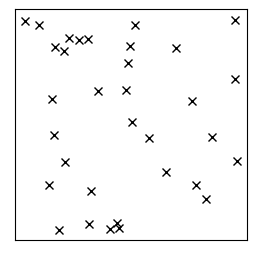

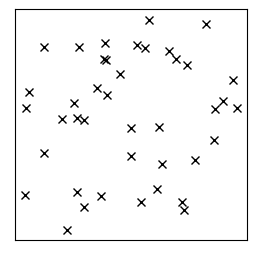

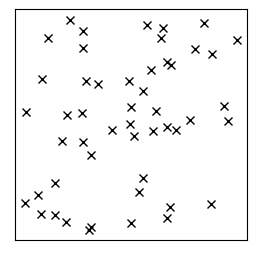

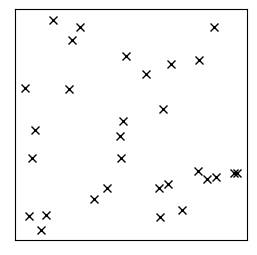

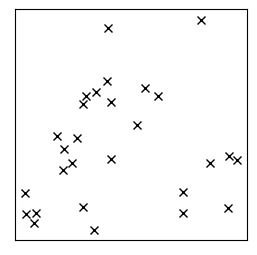

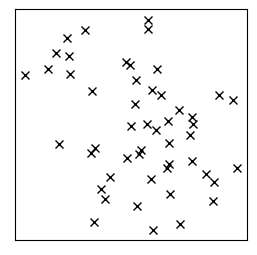

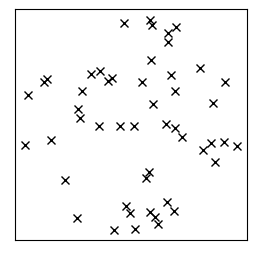

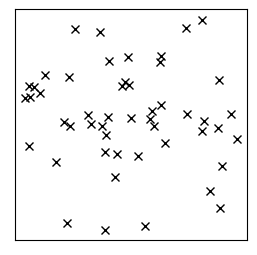

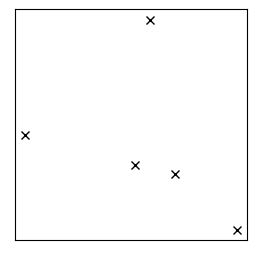

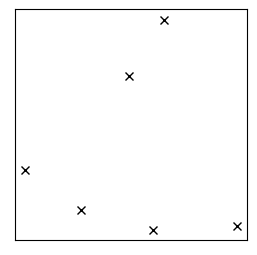

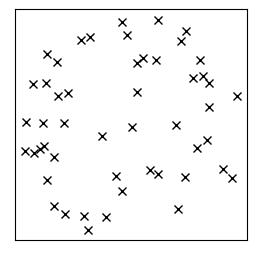

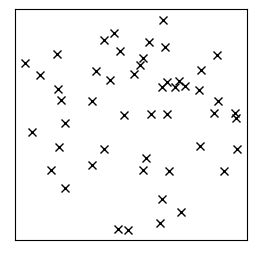

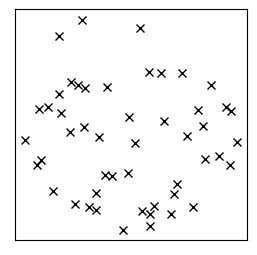

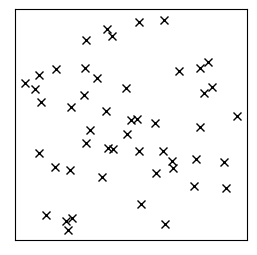

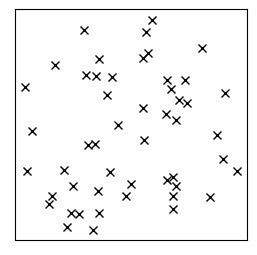

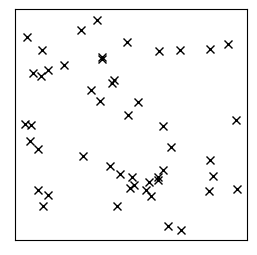

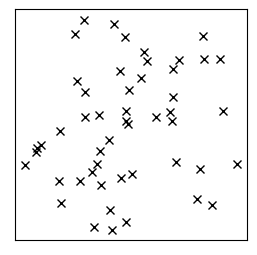

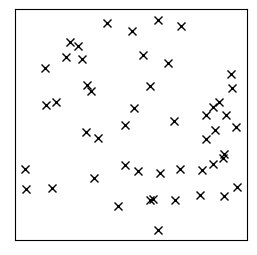

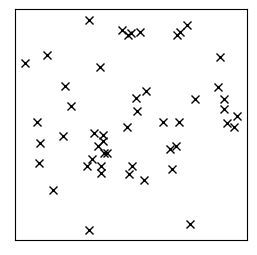

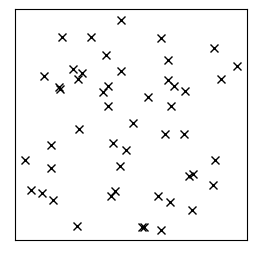

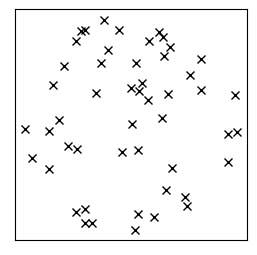

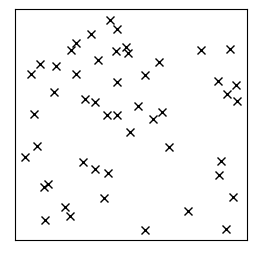

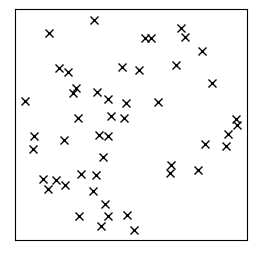

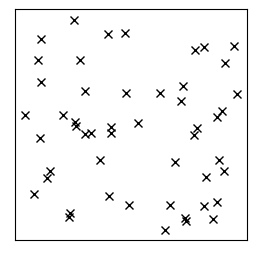

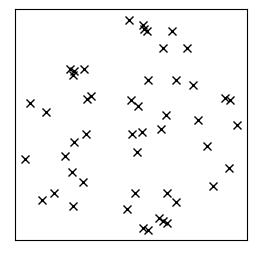

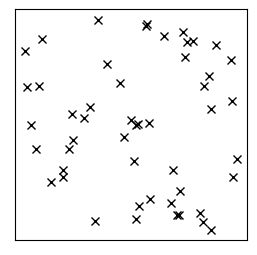

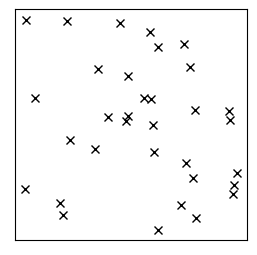

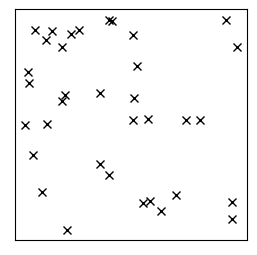

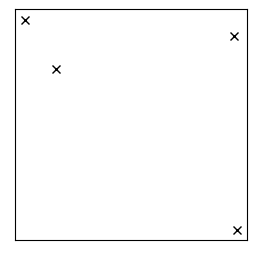

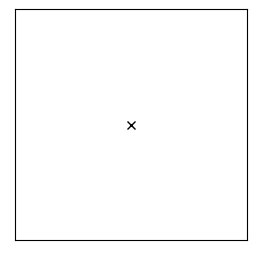

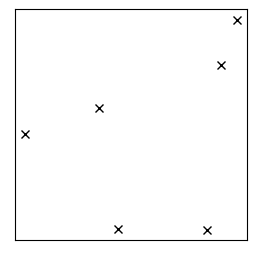

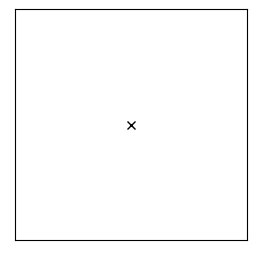

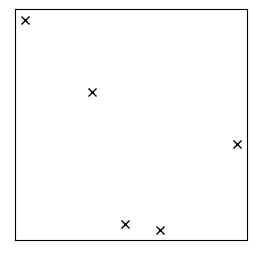

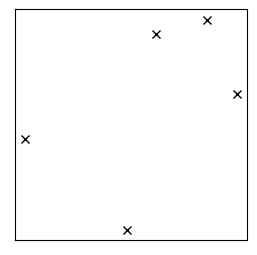

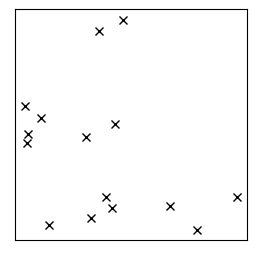

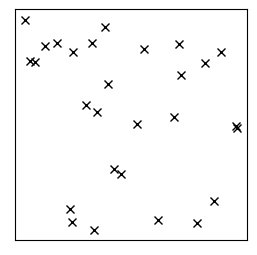

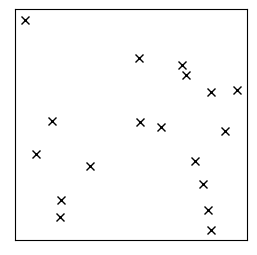

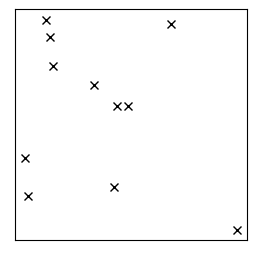

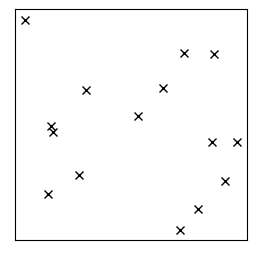

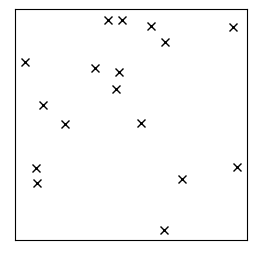

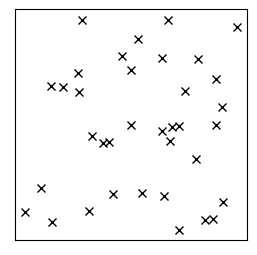

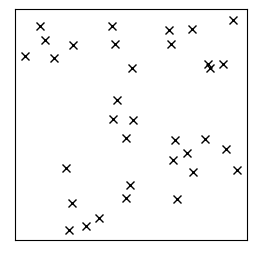

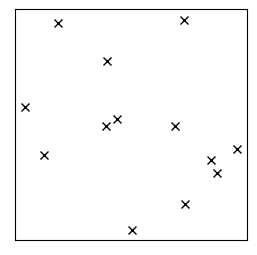

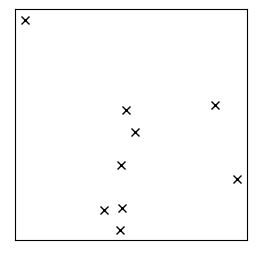

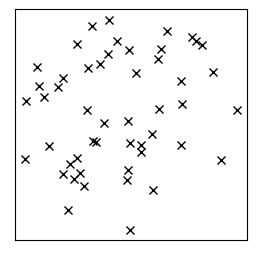

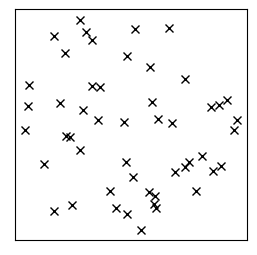

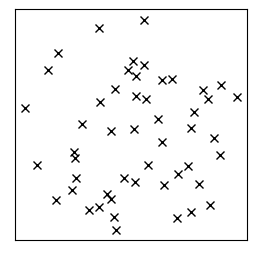

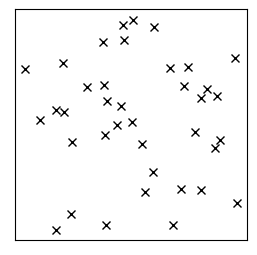

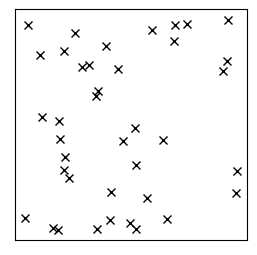

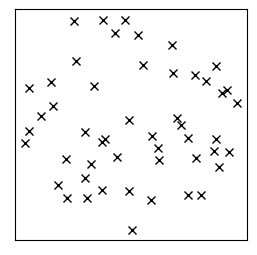

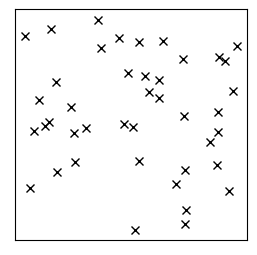

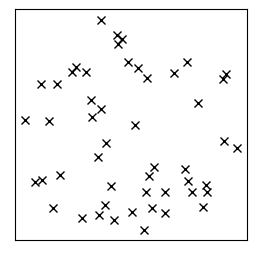

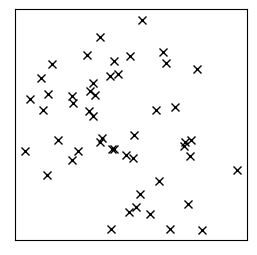

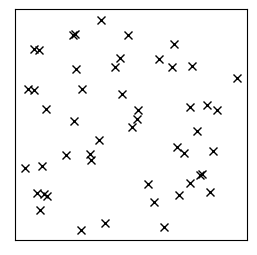

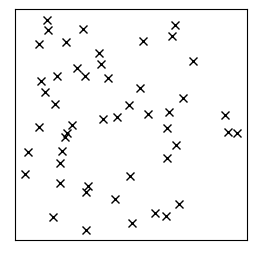

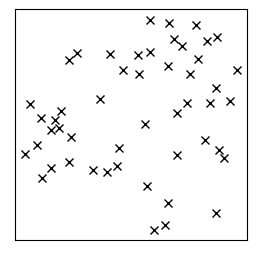

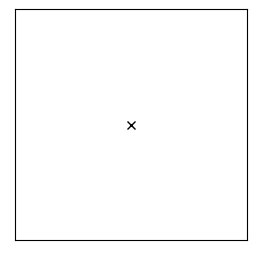

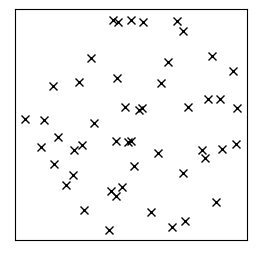

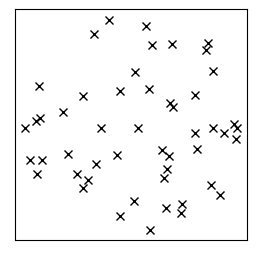

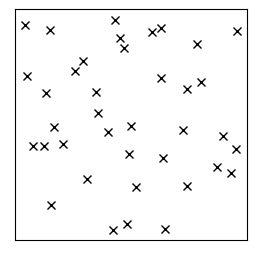

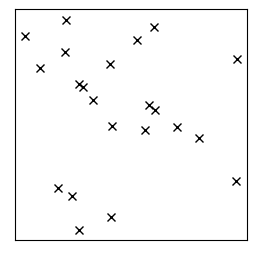

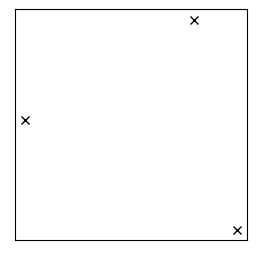

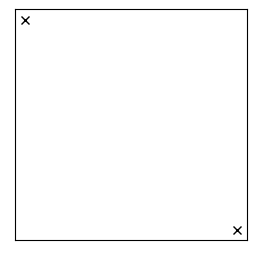

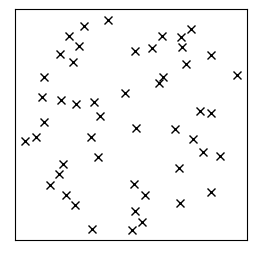

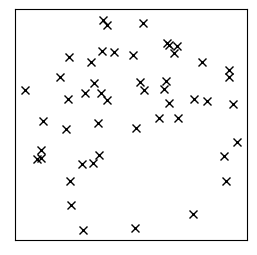

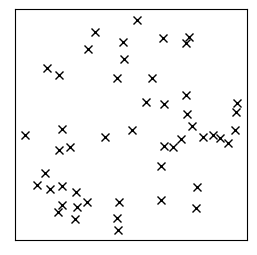

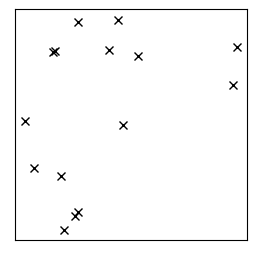

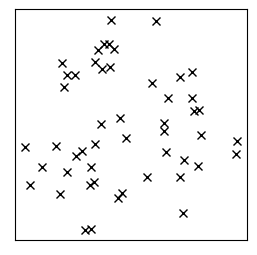

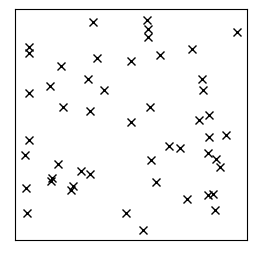

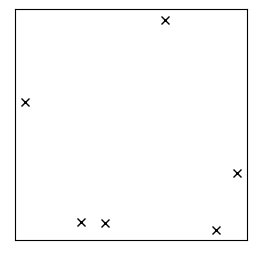

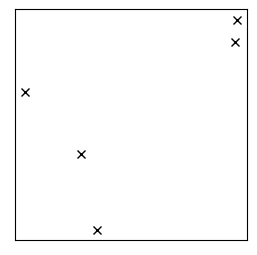

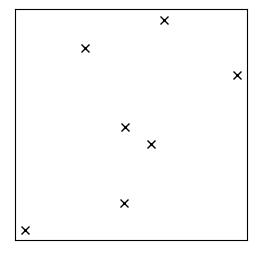

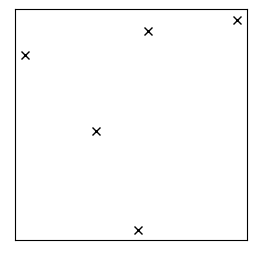

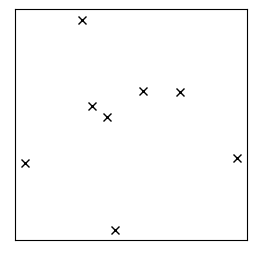

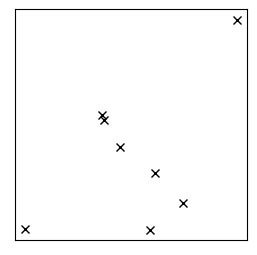

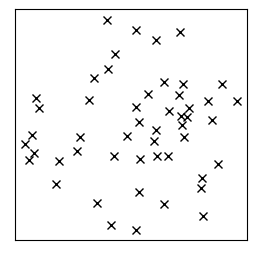

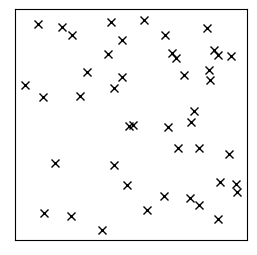

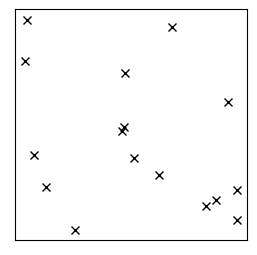

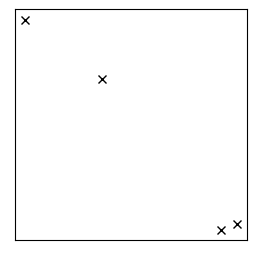

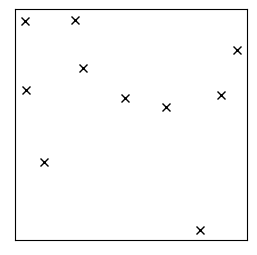

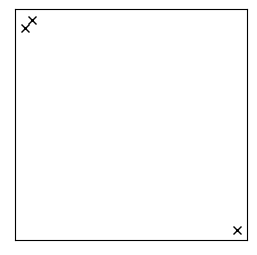

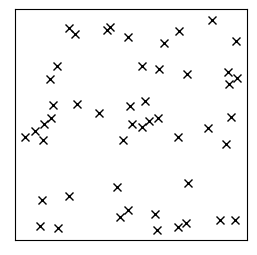

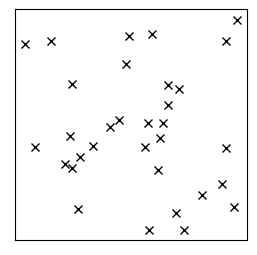

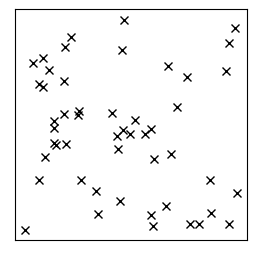

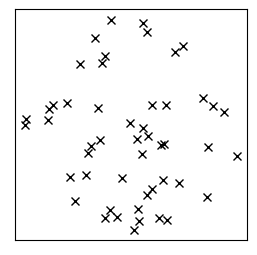

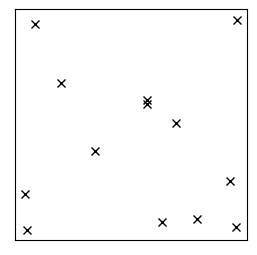

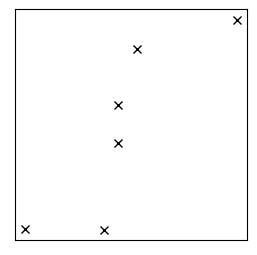

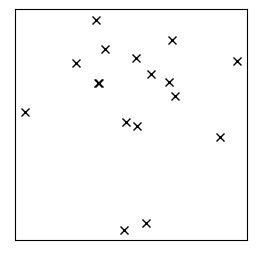

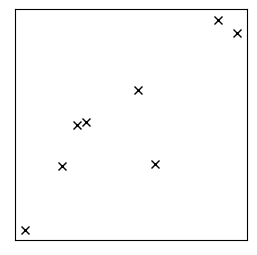

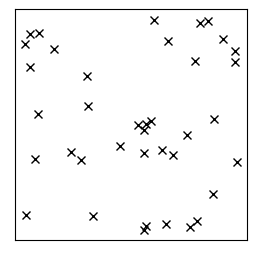

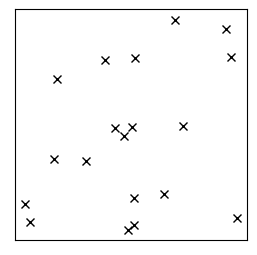

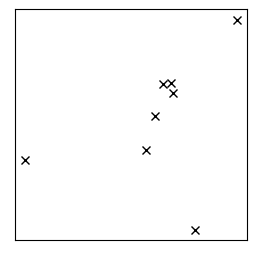

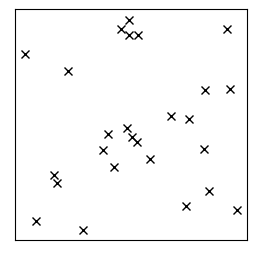

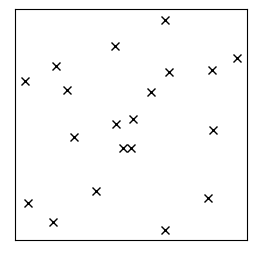

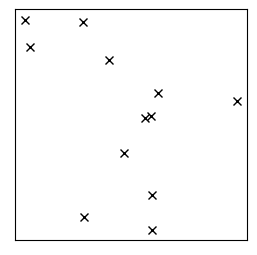

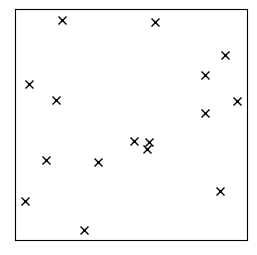

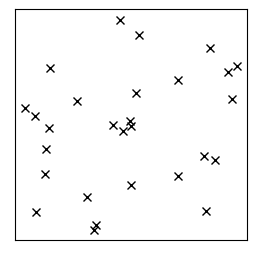

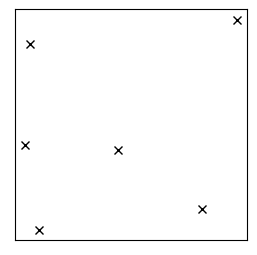

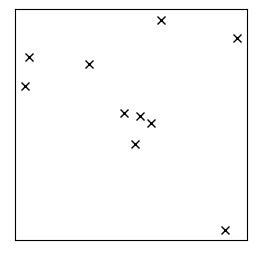

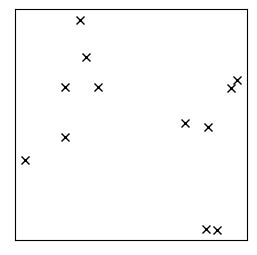

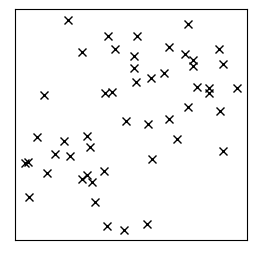

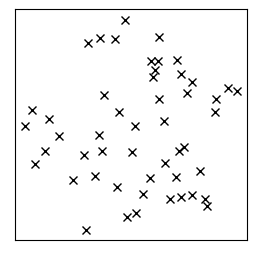

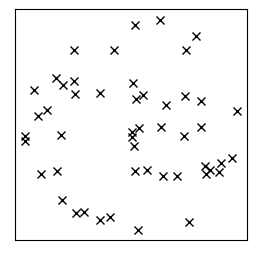

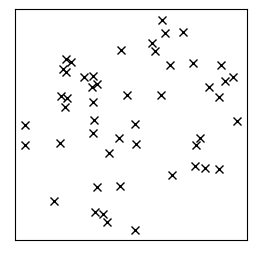

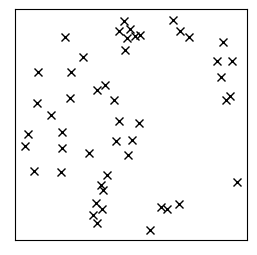

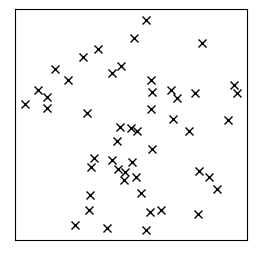

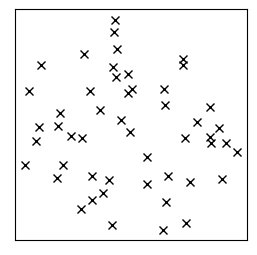

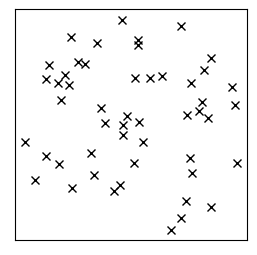

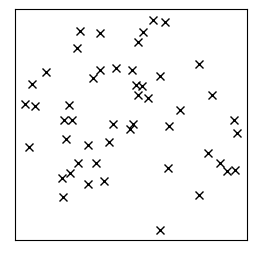

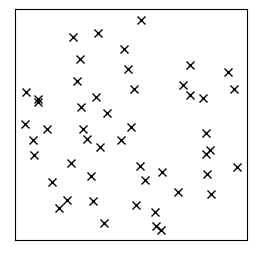

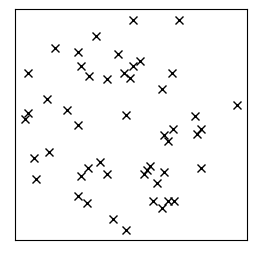

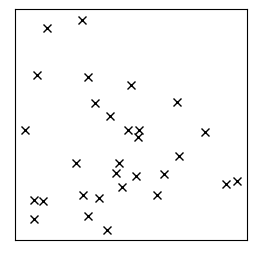

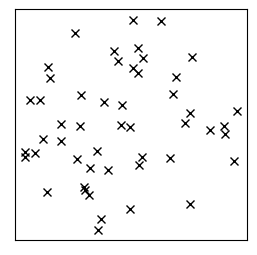

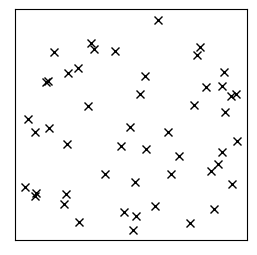

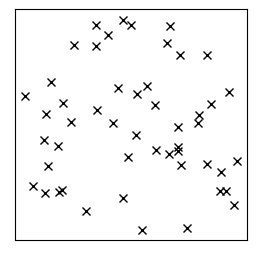

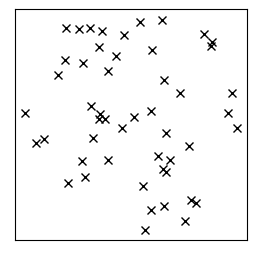

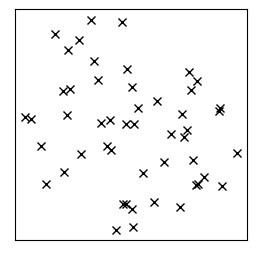

In [34]:
for i in range(len(rs)):
    plt.figure(figsize=(3,3))
    plt.xticks([]);plt.yticks([]);
    
    ra_gaia,dec_gaia = np.array(rs[i]['ra']),np.array(rs[i]['dec'])
    plt.plot(ra_gaia,dec_gaia,'kx')
    
    ix_finite = np.where(np.isfinite(ra_gaia) & np.isfinite(dec_gaia))
    d = angularSeparation(skypos[i][0],skypos[i][1],ra_gaia[ix_finite],dec_gaia[ix_finite])    
    try:
        ix_match = np.argmin(d)
    except ValueError:
        print(f"No matching Gaia source for {i}")
        raise


In [35]:
print('GAIA MATCH OFFSET')
g_m_o = []
for i in range(len(skypos)): 
    ix_match = np.argmin(rs[i][np.where(d*60*60 < 3)]['parallax_over_error'])
    ix = ix_finite[0][ix_match]
    gaia_match_offset=angularSeparation(skypos[i][0],skypos[i][1],rs[i][ix]['ra'],rs[i][ix]['dec'])*60*60
    g_m_o.append(gaia_match_offset[0])
    print(f"{gaia_match_offset[0]} as")  

GAIA MATCH OFFSET
0.07563167897654338 as
6.926630167755912 as
6.786268604098917 as
0.4596933992078999 as
0.1702263784201409 as
0.12804313674263337 as
0.03163634720649184 as
0.010054218239319167 as
0.1011085656013858 as
0.15738302943510984 as
0.1983434159679707 as
0.07359386701075675 as
3.97830457022191 as
2.1313860193801295 as
0.5346489472768376 as
0.2524233757754188 as
0.14237225628059488 as
0.07947813746930793 as
2.279899037132109 as
0.24304636993918166 as
0.1503771789117686 as
0.42531503014473415 as
0.25239224564973306 as
0.6392667747042321 as
0.24616957557090266 as
0.07322624947221143 as
0.4605661990239588 as
0.07072964499016793 as
0.18522490043609874 as
0.9125821316859124 as
3.5445391927610235 as
0.6729847967474096 as
0.037712104951972504 as
0.8492238718862536 as
0.04678815473759554 as
0.5594509970946306 as
0.4173892720914885 as
0.43700227508223344 as
0.1586991904662431 as
0.05234778665777582 as
0.0771768660277472 as
0.16235951743923357 as
2.0382758035682427 as
1.0775507829600623 

0.06240560323781396 as
0.8153829492848099 as
0.4123145926210287 as
0.1938862935711699 as
0.119799003253061 as
0.15254694352120923 as
0.004891453328659759 as
0.08818498448399995 as
0.7447992586355933 as
0.07246936575535659 as
4.176038312854425 as
0.6406521712820454 as
0.28983747590221265 as
0.1309554006169353 as
0.31773126713655764 as
1.1411382007344257 as
0.0272489988828358 as
0.4283523727714414 as
0.14232229360171314 as
0.32162723933937226 as
0.2654462520560103 as
0.18764597572060993 as
0.2336106996739539 as
0.1701389716268515 as
0.1961328619943187 as
0.09837492361169181 as
0.07605765012099439 as
0.04455874958503976 as
0.21295935905065314 as
2.2404618288269305 as
0.363299987268238 as
0.2633984363744175 as
5.863445563320756 as
0.24264608729765177 as
0.07554439834213868 as
0.19735359822550652 as
0.06608623759211228 as
0.2377132087288617 as
1.8172309352079867 as
0.08423600217408028 as
0.17132594311021426 as
1.316133936648019 as
0.4138982166063267 as
0.19398038612970867 as
1.8213311994005

1.5531374478002047 as
0.1359322965675039 as
0.12650357636629053 as
0.4001060465712472 as
0.10677752676815191 as
0.19186447466083265 as
0.27472432997062524 as
0.5299393093621348 as
0.3239290360011921 as
0.0732393470954274 as
0.28941395264585495 as
0.10347290346585745 as
0.24707403940604716 as
0.3218924531015883 as
0.6811708880468196 as
0.061934067502371265 as
0.6344492362435826 as
0.1931109058267049 as
0.07672935859697165 as
0.07811411153056011 as
0.17124494963809286 as
0.13026478533807292 as
0.014985248688095037 as
0.22518488647406135 as
1.6680932031846685 as
0.27971672759711697 as
0.13874284833100037 as
0.34160466840471154 as
0.663161626890165 as
0.7555770803028411 as
0.32440295578048206 as
0.1458437181821409 as
0.1537833838979221 as
0.20056478328938188 as
0.35609426219216456 as
0.1594520802953088 as
0.11875286954655734 as
0.0476778525101171 as
0.26800446561309765 as
0.13393902984534936 as
0.15029254747218754 as
0.11903764930507431 as
0.11343300187282318 as
0.02407504409073542 as
0.15

In [36]:
d_pc = []
print('GAIA ID & DISTANCES')
for i in range(len(rs)):
    gaia_dr3_source_id=rs[i][ix]['source_id']
    par,par_err = rs[i][ix]['parallax'],rs[i][ix]['parallax_error']
    gaia_distance=1000/par
    d_pc.append(gaia_distance)
    print(gaia_dr3_source_id,'@',f'{gaia_distance} parsecs')
    

GAIA ID & DISTANCES
5993730701016767360 @ 206.1834827980052 parsecs
6021430250773733632 @ 8.497683642357682 parsecs
6021430250773348736 @ 8.512696256657831 parsecs
6018034958869558912 @ 12.910813532081397 parsecs
5934470975675881600 @ 591.1412911946335 parsecs
5934555088300288640 @ -- parsecs
5989819119685515520 @ 143.13634394647343 parsecs
6032588953787261952 @ 1218.9147024506344 parsecs
5948551390289505792 @ 950.6056778688076 parsecs
6032746832450438400 @ 307.29203923863275 parsecs
5958864671939134720 @ 157.449234274127 parsecs
5949241883598432768 @ 419.24553138250604 parsecs
5955305209181045120 @ 3603.161821613204 parsecs
5955961548920087296 @ 34.190875111779 parsecs
5956505910225013120 @ 268.832219294355 parsecs
5941174835489943552 @ 259.02686842087996 parsecs
5956341632000395648 @ 563.8032127489722 parsecs
6029047426917672960 @ 1334.423614337223 parsecs
5934097210481810432 @ 13.490298747284413 parsecs
5934224375858236160 @ 647.9237824152651 parsecs
4665953175026835584 @ 10943.5048

In [37]:
gpoe=[]
for i in range(len(rs)):
    gaia_parallax_over_err = rs[i][ix]['parallax_over_error']
    gpoe.append(gaia_parallax_over_err)

In [38]:
skypos

[(244.7416, -41.666),
 (245.0077, -37.524),
 (245.009, -37.5231),
 (245.8916, -39.2295),
 (246.3631, -50.6983),
 (246.7205, -50.5957),
 (243.9664, -47.5741),
 (253.3125, -29.5206),
 (263.6997, -47.3669),
 (253.7688, -28.7106),
 (264.0925, -42.7465),
 (264.153, -45.2957),
 (264.2594, -44.3248),
 (264.4762, -42.5697),
 (267.8235, -42.839),
 (248.1816, -48.1603),
 (268.263, -43.4038),
 (256.7824, -29.4799),
 (248.33, -52.1344),
 (248.5495, -51.5173),
 (60.343, -70.8621),
 (61.9332, -68.4196),
 (62.1285, -68.7022),
 (62.0298, -71.4496),
 (62.2984, -71.2948),
 (63.0189, -68.1525),
 (63.375, -69.2265),
 (248.7186, -47.9898),
 (248.8507, -51.1113),
 (64.8065, -71.3531),
 (65.0564, -70.0959),
 (66.4721, -66.8995),
 (66.4705, -67.5722),
 (66.4436, -69.9937),
 (72.8589, -68.4398),
 (72.8977, -67.8696),
 (73.5421, -70.379),
 (265.1167, -44.0297),
 (75.1644, -70.6238),
 (75.7377, -68.5667),
 (76.8662, -69.8789),
 (88.1558, -71.5155),
 (88.3604, -71.5615),
 (88.7143, -70.5079),
 (89.3423, -67.4283)

In [45]:
 
### LEGAL VOTable fields defined in:
### https://github.com/astropy/astroquery/blob/main/astroquery/simbad/data/votable_fields_dict.json
import time
r2s=[]
for i in range(len(rs)):
    time.sleep(1)
    Simbad.add_votable_fields("otype","parallax","sp")
    time.sleep(1)
    r2 = Simbad.query_region(coord.SkyCoord(skypos[i][0],skypos[i][1],
                            unit=(u.deg, u.deg)),#, frame='icrs'),
                            radius=35/60/60*u.deg)
    time.sleep(1)
    print(skypos[i])
    #time.sleep(1)
    r2s.append(r2)

(244.7416, -41.666)
(245.0077, -37.524)
(245.009, -37.5231)
(245.8916, -39.2295)
(246.3631, -50.6983)
(246.7205, -50.5957)
(243.9664, -47.5741)
(253.3125, -29.5206)
(263.6997, -47.3669)
(253.7688, -28.7106)
(264.0925, -42.7465)
(264.153, -45.2957)
(264.2594, -44.3248)
(264.4762, -42.5697)
(267.8235, -42.839)
(248.1816, -48.1603)
(268.263, -43.4038)
(256.7824, -29.4799)
(248.33, -52.1344)
(248.5495, -51.5173)
(60.343, -70.8621)
(61.9332, -68.4196)
(62.1285, -68.7022)
(62.0298, -71.4496)
(62.2984, -71.2948)
(63.0189, -68.1525)
(63.375, -69.2265)
(248.7186, -47.9898)
(248.8507, -51.1113)
(64.8065, -71.3531)
(65.0564, -70.0959)
(66.4721, -66.8995)
(66.4705, -67.5722)
(66.4436, -69.9937)
(72.8589, -68.4398)
(72.8977, -67.8696)
(73.5421, -70.379)
(265.1167, -44.0297)
(75.1644, -70.6238)
(75.7377, -68.5667)
(76.8662, -69.8789)
(88.1558, -71.5155)
(88.3604, -71.5615)
(88.7143, -70.5079)
(89.3423, -67.4283)
(56.1968, -71.7036)
(57.6572, -69.3492)
(58.1708, -69.4257)
(58.2899, -71.6783)
(58.4152

(75.2269, -81.3789)
(76.6351, -80.768)
(81.3406, -78.1385)
(81.5752, -83.6047)
(83.5471, -79.8289)
(83.2757, -80.8154)
(84.3024, -80.4629)
(89.7444, -78.2822)
(90.6435, -83.4503)
(91.5914, -83.2572)
(92.9334, -81.8229)
(94.1328, -79.4443)
(94.5534, -80.1967)
(227.3623, -70.4217)
(26.7075, -82.673)
(228.8095, -70.5206)
(116.693, -62.8054)
(217.7351, -80.7505)
(218.2757, -81.3396)
(12.5489, -83.7437)
(230.7022, -66.4175)
(234.6991, -66.8136)
(235.3125, -69.3821)
(270.2918, -35.7462)
(293.9047, -76.804)
(297.9923, -80.4769)
(263.0137, -36.2194)
(49.3104, -85.5405)
(49.325, -85.5422)
(236.4896, -52.5992)
(280.2097, -71.3654)
(70.0372, -83.3824)
(33.4591, -80.5827)
(36.0105, -80.0455)
(97.2459, -78.0069)
(236.8381, -49.0075)
(108.3439, -74.0541)
(109.9832, -76.6921)
(110.381, -72.724)
(112.9653, -73.606)
(114.0132, -75.4697)
(114.1703, -74.7016)
(115.0036, -72.2049)
(115.5212, -74.9482)
(116.4173, -72.3239)
(117.1106, -76.2416)
(117.3002, -76.703)
(118.5376, -76.5673)
(119.4796, -73.4731)
(

(107.7566, -75.168)
(79.2501, -78.2957)
(79.5204, -80.9643)
(245.8802, -28.1291)
(67.5997, -59.4683)
(198.334, -75.3526)
(24.4875, -82.9743)
(150.2855, -79.2186)
(199.4998, -72.9503)
(27.9946, -81.0193)
(31.6911, -81.2474)
(155.608, -82.2189)
(156.2342, -80.2423)
(157.3685, -80.5115)
(157.8735, -83.4234)
(54.99, -83.0885)
(25.0406, -86.6891)
(161.8966, -79.464)
(161.8146, -79.4685)
(203.2967, -77.5703)
(169.2337, -80.4643)
(207.0973, -75.795)
(208.9622, -77.8026)
(209.5776, -73.6388)
(210.4806, -75.2261)
(213.8755, -75.0751)
(65.5493, -57.4366)
(65.7605, -55.3091)
(130.9009, -77.0495)
(101.5575, -83.9912)
(101.7446, -87.0249)
(246.5592, -27.9831)
(215.4308, -73.314)
(311.6768, -81.7237)
(352.6407, -84.9223)
(219.416, -75.5496)
(219.7387, -72.0519)
(220.624, -64.9765)
(224.0456, -73.5253)
(248.87, -64.0328)
(249.7847, -61.7846)
(226.2006, -73.5579)
(230.9334, -72.4769)
(318.3313, -81.8225)
(220.7944, -65.7191)
(85.2302, -69.1753)
(12.2245, -88.4146)
(14.7246, -86.0559)
(223.423, -79.623

In [46]:
spectral_type=[]
for i in range(len(r2s)):
    try:
        spec_type = r2s[i]['SP_TYPE']
        spectral_type.append(spec_type)
        
    except TypeError:
        spec_type = 0
        spectral_type.append(spec_type)
len(spectral_type)

1000

In [47]:
for i in range(len(spectral_type)):
    try:
        print(spectral_type[i].value)
    except:
        pass
    #val = i.value
    #if val.startswith('M'):
        

['K0/1']
['M3V' 'M5:']
['M3V' 'M5:']
['DA2' '']
['G5III']
['ApSi']
['F0V']
['']
['']
['' 'F6V' '']
['' 'A2mA3-A8' '']
['K1/2III']
['' '' '' 'M3.5']
['G1V']
['']
['']
['G6/8(III)']
['']
['M4e' '']
['ApSi']
['M3.2' '']
['F2V']
['M0']
['?+L0:e']
['' '' 'G2' '']
['B9IV' '']
['K5']
['' '' '']
['M6Ve']
['']
['K1III']
['G2V']
['K1III']
['']
['G0' '']
['']
['F0/2IV/V' '']
['K5' '' '']
['M' '' '' '']
['F5IV' '']
['M6.0' '' '']
['F3V']
['K0III' '']
['F6wF3V' '']
['sdO9VIIHe40']
['']
['']
['' '' '']
['' '' '']
['F0V']
['']
['G8/K0(III)']
['K3/5(III)' '']
['']
['sdB']
['Fm_dD']
['']
['M2.5']
['']
['']
['' 'M4.0' '']
['']
['F7V' '' '']
['G5III']
['G1V']
['K3III']
['']
['']
['']
['ApEuCrSr']
['' 'K']
['G8III/IV']
['M3.5']
['A1V']
['']
['' 'F2']
['']
['F0V']
['']
['' '' '' '' '' 'C' '' '' '' '' '' '' '']
['A2V' '']
['']
['A/F(pEu)']
['']
['']
['']
['']
['' 'F6/7V' '']
['']
['']
['K0IIICNIV/V']
['']
['']
['G6/8III' '']
['' '']
['DA']
['' '']
['' '' '']
['']
['F5V' '']
['F3/5V' '']
['G8III']
['']
['']


### TARGET TABLE

In [50]:
ID=[]
position = []
distance=[]
for i in range(len(rs)):
    
    name = rs[i][ix]['source_id']
    ID.append(name)
    ra = rs[i][ix]['ra']
    dec = rs[i][ix]['dec']
    pos = (ra,dec)
    position.append(pos)
    dist = d_pc[i]
    distance.append(dist)

target_table = pd.DataFrame({
                    'Gaia ID': ID,
                    'Position': position,
                    'Distance (pc)': distance,
                    'Spectral Type': spectral_type,
                    'Gaia Match Offset':g_m_o,
    })
#target_table.to_csv('target_table_v2.csv')

In [ ]:
#target_table
spectral_type

In [ ]:
path = '/Users/katborski/Documents/GitHub/QPPs/sector_39/'

In [55]:
# open data & create list of datafiles
event_files = []
for visit in os.listdir(path):
    vis_path = path+visit
    event_files+=[vis_path]

#datafiles = fits.open(event_files)

# create list of distances in parsecs, previously defined as d_pc
distances = d_pc

In [56]:
len(event_files)

1001

In [ ]:
n_flares=[]
max_energies = []
max_energy_errors = []
min_energies = []
min_energy_errors = []
ontimes = []
for i in range(len(event_files)-1):
    # 9,19,27 & 31 produce different indexing errors
    # 14,15 & 30 produce empty/corrupt fits file errors
    flare_data = []
    try:
        if 'M' not in spectral_type[i]:
            pass
        else:
            flaring_frame, ontime = dataClean(event_files[i])
            q_frame = generate_Qcurve(flaring_frame)
            flare_ranges = find_flare_ranges(flaring_frame,q_frame,3,quiescence=None)   
            ### flare_ranges contains 2 elements: 
            ###    [0] = flare_ranges,
            ###    [1] = flare_flux
        
            flare_total_energies = energycalculation2(flaring_frame,q_frame,flare_ranges,distance[i],binsize=20)
            ### flare_total_energies has 2 elements: 
            ###     [0] = integrated energy
            ###     [1] = integrated energy error
        
            n_flares = len(flare_ranges[0])
            max_flare_energy = max(flare_total_energies[0])
            max_flare_energy_error = max(flare_total_energies[1])
            min_flare_energy = min(flare_total_energies[0])
            min_flare_energy_error = min(flare_total_energies[1])
            ### compute basic stats
        
    except:
        print(event_files[i])

    #flare_total_energies = energycalculation2(flaring_frame,q_frame,flare_ranges,binsize=20)
    #qpp_data = qpp_find(flaring_frame,flare_ranges[0],flare_ranges[1])
        ### qpp_data contains 5 elements: 
        ###    [0] = large_flare_data,
        ###    [1] = large_flare_time,
        ###    [2] = large_flare_det, 
        ###    [3] = large_flare_params, 
        ###    [4] = large_flare_fits
    #residuals, res_fits = fit_residuals(qpp_data[0],qpp_data[4])
    #flare_table = FlareTable(flaring_frame,flare_ranges,flare_total_energies)
print(len(ranges))

In [ ]:
### Build Table 

flare_stat_table = pd.DataFrame({
                        'Gaia ID': ID,
                        'Position': position,
                        'Distance (pc)': distance,
                        'Spectral Type': spectral_type
                        'Time on Source': ontimes,
                        'Number of Flares': n_flares,
                        'Max Flare Energy': max_energies,
                        'Max Flare Energy Error': max_energy_errors,
                        'Min Flare Energy': min_energies,
                        'Min Flare Energy Error': min_flare_energy_errors
})

    

In [ ]:
flare_stat_table